<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Content</h3>

* [1. Libraries](#1)
* [2. Reading the Data](#2)
    - [1.1 An Overview from the Data](#2.1)
* [3. Exploratory Data Analysis](#3) 
    - [3.1 Total Orders on E-Commerce](#3.1)
    - [3.2 Product category analysis](#3.2)
    - [3.3 E-Commerce Around Brazil](#3.3)
    - [3.4 E-Commerce Impact on Economy](#3.4)
    - [3.5 Payment Type Analysis](#3.5)
* [4. RFM, Cohort analysis, CLV](#4)    
* [5. Customer Segmentation](#5)

<a id="1"></a>
<font color="darkslateblue" size=+2.5><b>1. Libraries</b></font>

In [95]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import datetime
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

from collections import Counter
from operator import attrgetter
from PIL import Image

# Utilities
from viz_utils import *
from custom_transformers import *
from ml_utils import *

# DataPrep
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib


In [96]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import datetime
import datetime as dt
from operator import attrgetter
import squarify
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lifetimes
from sklearn.cluster import DBSCAN
np.random.seed(42)

import random
random.seed(42)

In [97]:
plt.rcParams['figure.figsize'] = (12, 7) 
plt.rcParams.update({'font.size': 12})
# plt.rcParams["figure.dpi"] = 1000 
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

<a id="2"></a>
<font color="darkslateblue" size=+2.5><b>2. Reading the Data</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

For this task we have differente data sources, each one describing a specific topic related to e-commerce sales. The files are:

    olist_customers_dataset.csv
    olist_geolocation_dataset.csv
    olist_orders_dataset.csv
    olist_order_items_dataset.csv
    olist_order_payments_dataset.csv
    olist_order_reviews_dataset.csv
    olist_products_dataset.csv
    olist_sellers_dataset.csv
    product_category_name_translation.csv
    
The relationship between these files are described on the documentation. So let's read the datasets and make an initial analysis with all of them. This step will help us a lot to take right decisions in a future exploratory data analysis.

In [98]:
# Reading all the files
raw_path = 'Customer Segmentation/'
olist_customer = pd.read_csv(raw_path + 'customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'sellers_dataset.csv')
trans = pd.read_csv(raw_path + 'product_category_name_translation.csv')

In [99]:
cus=olist_customer
geo=olist_geolocation
orders=olist_orders
items=olist_order_items
pm=olist_order_payments
rv=olist_order_reviews
prod=olist_products
sellers=olist_sellers

In [100]:
trans = trans.set_index('product_category_name')
dict_name = trans.to_dict()['product_category_name_english']

In [101]:
prod['product_category_name'] = prod['product_category_name'].map(dict_name)

<a id="2.1"></a>
<font color="dimgrey" size=+2.0><b>2.1 An Overview from the Data</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [102]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

Now let's use a homemade function found on the module `viz_utils.py` for looking at each dataset and bring some detailed parameters about the data content. With this function we can get the following information for each dataset column:

    - Column name;
    - Null amount;
    - Null percentage among the respective dataset;
    - Data type;
    - total categorical entries;

In [103]:
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col

df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview

dataset_name                        feature  qtd_null  \
0        olist_customer                    customer_id         0   
1        olist_customer             customer_unique_id         0   
2        olist_customer       customer_zip_code_prefix         0   
3        olist_customer                  customer_city         0   
4        olist_customer                 customer_state         0   
0     olist_geolocation    geolocation_zip_code_prefix         0   
1     olist_geolocation                geolocation_lat         0   
2     olist_geolocation                geolocation_lng         0   
3     olist_geolocation               geolocation_city         0   
4     olist_geolocation              geolocation_state         0   
0          olist_orders  order_delivered_customer_date      2965   
1          olist_orders   order_delivered_carrier_date      1783   
2          olist_orders              order_approved_at       160   
3          olist_orders                       order_id         0   
4          olist_orders                    customer_id         0   
5          olist_orders                   order_status         0   
6          olist_orders       order_purchase_timestamp         0   
7          olist_orders  order_estimated_delivery_date         0   
0     olist_order_items                       order_id         0   
1     olist_order_items                  order_item_id         0   
2     olist_order_items                     product_id         0   
3     olist_order_items                      seller_id         0   
4     olist_order_items            shipping_limit_date         0   
5     olist_order_items                          price         0   
6     olist_order_items                  freight_value         0   
0  olist_order_payments                       order_id         0   
1  olist_order_payments             payment_sequential         0   
2  olist_order_payments                   payment_type         0   
3  olist_order_payments           payment_installments         0   
4  olist_order_payments                  payment_value         0   
0   olist_order_reviews           review_comment_title     88285   
1   olist_order_reviews         review_comment_message     58247   
2   olist_order_reviews                      review_id         0   
3   olist_order_reviews                       order_id         0   
4   olist_order_reviews                   review_score         0   
5   olist_order_reviews           review_creation_date         0   
6   olist_order_reviews        review_answer_timestamp         0   
0        olist_products          product_category_name       623   
1        olist_products            product_name_lenght       610   
2        olist_products     product_description_lenght       610   
3        olist_products             product_photos_qty       610   
4        olist_products               product_weight_g         2   
5        olist_products              product_length_cm         2   
6        olist_products              product_height_cm         2   
7        olist_products               product_width_cm         2   
8        olist_products                     product_id         0   
0         olist_sellers                      seller_id         0   
1         olist_sellers         seller_zip_code_prefix         0   
2         olist_sellers                    seller_city         0   
3         olist_sellers                   seller_state         0   

   percent_null    dtype  qtd_cat  
0        0.0000   object    99441  
1        0.0000   object    96096  
2        0.0000    int64        0  
3        0.0000   object     4119  
4        0.0000   object       27  
0        0.0000    int64        0  
1        0.0000  float64        0  
2        0.0000  float64        0  
3        0.0000   object     8011  
4        0.0000   object       27  
0        0.0298   object    95664  
1        0.0179   object    81018  
2        0.0016   object    90733  
3        0.0000   object    99441  
4 

<a id="3"></a>
<font color="darkslateblue" size=+2.5><b>3. Exploratory Data Analysis</b></font>

So now we will go trough an exploratory data analysis to get insights from E-Commerce in Brazil. The aim here is to divide this session into topics so we can explore graphics for each subject (orders, customers, products, items, and others).

<a id="3.1"></a>
<font color="dimgrey" size=+2.0><b>3.1 Total Orders on E-Commerce</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

We know that e-commerce is really a growing trend in a global perspective. Let's dive into the orders dataset to see how this trend can be presented in Brazil, at least on the dataset range.

Looking at the dataset columns, we can see orders with different `status` and with different timestamp columns like `purchase`, `approved`, `delivered` and `estimated delivery`. First, let's look at the status of the orders we have in this dataset.

___
* _How many orders we have for each status?_
___

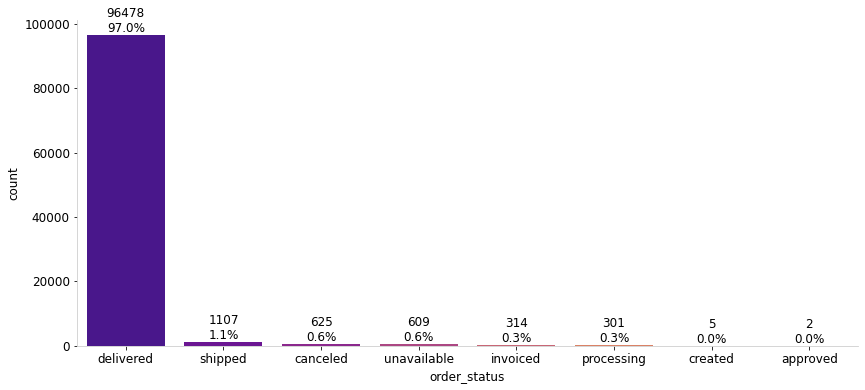

In [104]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

By the time this dataset was created, the highest amount of orders went from delivered ones. Only 3% of all orders came from the other status.

___
* _Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?_
___

For the next plots, let's dive into the real evolution of e-commerce in terms of purchase orders. For this, we have to extract some info on the `order_purchase_timestamp` following the topics:

    1. Transform timestamp columns;
    2. Extract time attributes from these datetime columns (year, month, day, day of week and hour);
    3. Evaluate the e-commerce scenario using this attributes.

In [105]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_year_month2'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))

df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_year_month2 order_purchase_date  \
0                    201710                    2017-10            20171002   
1                    201807                    2018-07            20180724   
2                    201808                    2018-08            20180808   
3                    201711                    2017-11            20171118   
4                    201802                    2018-02            20180213   

   order_purchase_day  order_purchase_dayofweek order_purchase_dayofweek_name  \
0                   2                         0                           Mon   
1                  24                         1                           Tue   
2                   8                         2                           Wed   
3                  18                         5                           Sat   
4                  13                         1                           Tue   

   order_purchase_hour order_purchase_time_day  
0                   10                 Morning  
1                   20                   Night  
2                    8                 Morning  
3                   19                   Night  
4                   21                   Night

So now we can purpose a complete analysis on orders amount of brazilian e-commerce during the period of the dataset. For that let's plot some graphs with the aim answear the following questions:

    1. Is there any growing trend on brazilian e-commerce?
    2. On what day of week brazilians customers tend to do online purchasing?
    3. What time brazilians customers tend do buy (Dawn, Morning, Afternoon or Night)?

In [106]:
joined = olist_orders.merge(olist_order_payments, how='left', on='order_id')
joined['order_purchase_timestamp'] = pd.to_datetime(joined['order_purchase_timestamp'])
joined['order_months'] = joined['order_purchase_timestamp'].dt.to_period('M')
joined['cohorts'] = joined.groupby('customer_id')['order_months'].transform('min')
cohorts_data = joined.reset_index()\
                     .groupby(['cohorts', 'order_months']).agg(ClientsCount = ('customer_id', 'nunique'),
                          Revenue = ('payment_value', 'sum'),
                          Orders = ('order_id', 'count')).reset_index()
cohorts_data['periods'] = (cohorts_data.order_months - cohorts_data.cohorts).apply(attrgetter('n')) # periods for which the client have stayed
cohorts_data['cohorts'] = cohorts_data['cohorts'].map(str)

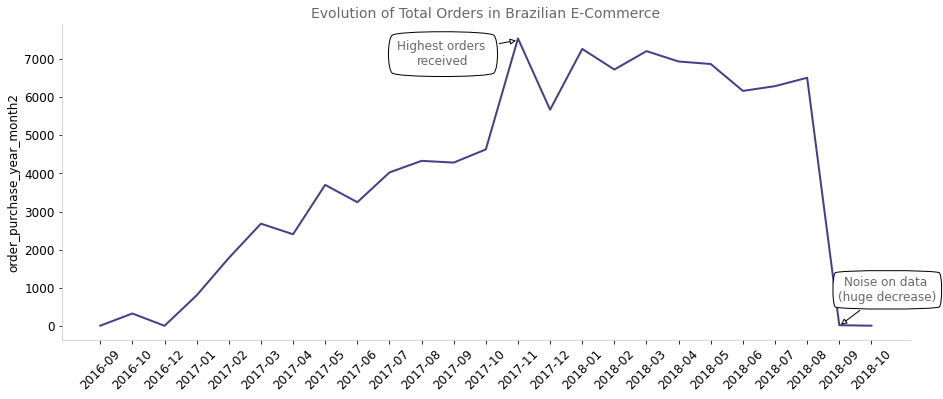

In [107]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month2'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')
pass

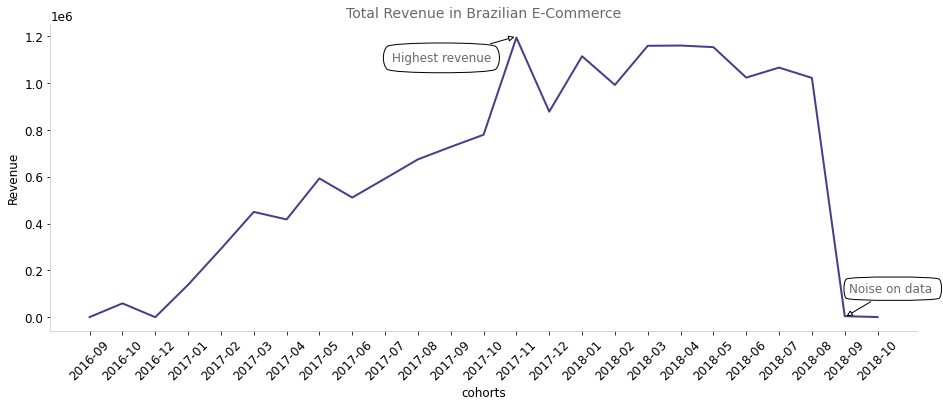

In [108]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])

sns.lineplot(x='cohorts', y='Revenue', data=cohorts_data, ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest revenue', (13, 1.2*1e6), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data ', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Total Revenue in Brazilian E-Commerce', size=14, color='dimgrey')
pass

* dynamics of two graphs are almost identical. Thus, it seems like the Average Order Amount was the same almost for each cohort. It could mean that the only way to get more revenue is to get more clients. Also, we know that we have most of non-recurring clients, thus maybe resolving this issue and stimulating customers to comeback would also result in revenue increase

* I suspect that we don't have the full data for the last several months, because we can see abnormal drop. Thus, these last months should be considered as noise

* Cohort of November-2017 looks like out of trend, since this cohort showed outstanding results. It can be due to Black Friday sales that often happen at Novembers, or maybe during the November of 2017 some experimental marketing campaigns were performed that lead to good results. Thus, this cohort should be investigated by the company in order to identify the reason behind such an outstanding result, and take it into account

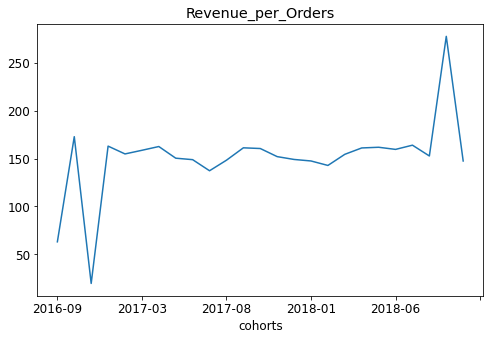

In [109]:
plt.figure(figsize=[8,5])
cohorts_data['Revenue_per_Orders'] = cohorts_data['Revenue']/cohorts_data['Orders']
cohorts_data.set_index('cohorts')['Revenue_per_Orders'].plot()
plt.title('Revenue_per_Orders')
pass

 The Revenue_per_Orders is the same for almost all the cohorts. But we have some outliers that are located at the start and end of the left graph. Those outliers probably should be ignored and we can assume that Revenue_per_Orders is the same for each cohort. Thus, it may imply that the company should work on increasing the number of clients

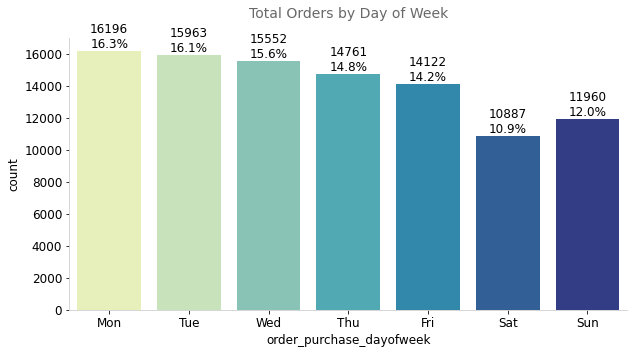

In [110]:
# Barchart - Total of orders by day of week
fig, ax2 = plt.subplots(1, figsize=[10,5])
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)
pass

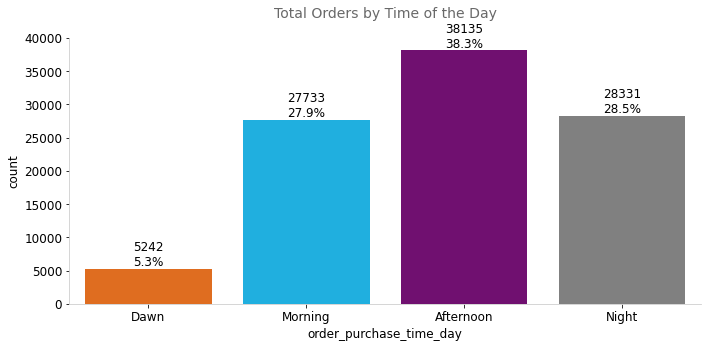

In [111]:
# Barchart - Total of orders by time of the day
fig, ax3 = plt.subplots(1, figsize=[10,5])
day_color_list = ['#FF6700', 'deepskyblue','purple', 'gray']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

By the chart above we can conclude:

* E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
* Weekends may not be the prefered days for brazilian's customers and they tend to buy more at afternoons.

_Obs: we have a sharp decrease between August 2018 and September 2018 and maybe the origin of that is related to noise on data. For further comparison between 2017 and 2018, let's just consider orders between January and August in both years_

___
* _E-commerce: a comparison between 2017 and 2018_
___

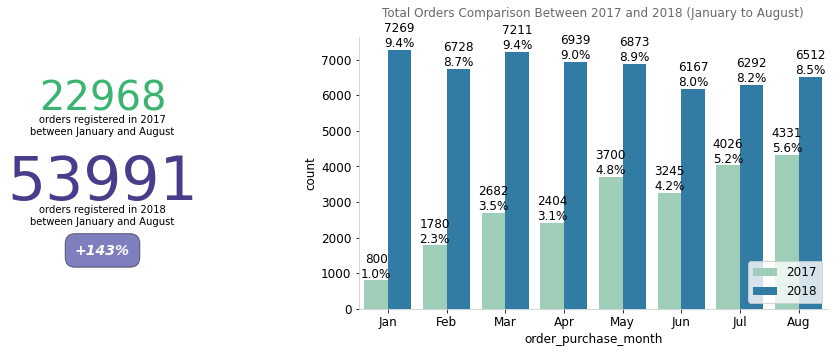

In [112]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
pass
# plt.shdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA7AAAAFwCAYAAACBypdfAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3XucTPX/wPHXh12Jyrp00yrfcs39UvStSSqUpotSElGR6uSXmpTCt3KLblPEoXuKL1+RL82XIhWjdHHZldwLuRWpJdal5fP743NmnJmd2R3ai919Px+Pedg58zmf8zmzM+u8z/tzUVprhBBCCCGEEEKIE12pwm6AEEIIIYQQQgiRCAlghRBCCCGEEEIUCRLACiGEEEIIIYQoEiSAFUIIIYQQQghRJEgAK4QQQgghhBCiSJAAVgghhBBCCCFEkZBU2A0QQgghCpNlWWWB/UA127a35ONx6gArbNuW/3tzYFnWu8BK27afL+y2iBNXQX1v84JlWWcDnwGNbNs+VNjtEcfGsqz/AS/Ytv1FYbdFGPKfqBBCiBOOZVl7XU/LAQeBw87z+2zbnpjDvtcAo23brpGH7ekADADqYi6aZwH9bNvenlfHyEvOxf1AoDNwJvAbMBcYbNv25sJsW25s276rII/n3FhYBexzNu0F/gP4bNs+HHfHo/uPAKrYtt0z/1r591iWNQDoAlQDdgIjbdse6Xr9AuBdoBmwAXjAtu0FzmtNgRHOa+Vt2y7r2u8kYFfU4coBL9m2/Vi+nVACLMsaBVwHnAFsBobYtj3J9fpFwBtALWAFcI9t2yuc19pivu9Nga22bdeJqrs5MAqoB+wBxti2PSKH5gwEXgsFr5ZlTcbczBqaF+daWCzL+gXoaNv2wr9RRynM7+dX27ab5lnjjr89sb7PzwHDgUsLp1UimnQhFkIIccKxbfuU0AP4GbjetS1u8JofLMvqArwDPA9UBhoCpYEFlmWdFmefPL1BfCz1WZalgP8CbYBbgQpAE+AH4Iq8bFdesyyrdCEd+rDr89YEuBq4t5Dakh+OYG5mpADXA/0sy7rJ9fpUIAhUAoYC/7UsK8V57SAwCbg/ulLbtg9GfVdTnfIf5NuZJG4PcC3m898LGGdZVjMAy7JOBmYArwMVMe2d7vqe7XVeezJO3VOA2Zj362rgUSfozcayrHLAHcC/8+Cc8k1e/806Bm2AU4AGlmU1KKQ25CYIVDuB21fiSAZWCCFEkeNcgL4I3IzJzE4C+gOnAdOBk1xZ3POAOoDf+XcfJsP2mG3bWbkcJ8k5zlO2bU9xNm+zLKsbsBroDTxrWdb9wG2YTN4dwEvOnfyXgK7AH8DIqLorAa8AbYG/gDcxWaIjceqb6pRpABwCZtu23S1Gs68DPMAFtm3/4mz7wzlW6NjnAuOAlpjs7DDbtsc7r43AZOqSnLrWAx2AbsD/YS7u77Zt+3On/NeY7G57oAbwKSabtdt5//4DXAacBCwD7rdte42z72RgB+b3cinQzrKs3jjZKcuyzsJkBltifs/ptm1f6ezbALCd9+NnTEZ8tqveXzAZ838Cy4E7bNveFOP9imDb9nbLsuYBF7rer2rAaKeNe4Dnbdse5wSBPkBZlnU7sBJ4GpPpvsjZdyFwxLbty53ni4GBtm1/HK9ep1xpzGf6bszn+hPgQdu2M0Ld0TFB9hDnvX3etu0X4pzTcNfTHyzLCjjH/K9lWQ0xWch/2rZ9AJhkWZYPuAl417btH5x96uf23gGdgI22bX8b60Wn3eMwN4EOY3oy9LZt+0/n9V8w2a4emM9gAPNZC2UuBwAPYb4vz+TUENu2B7qeLrQs6xvM52gJJmg6YNu27dT7EvAo5nP6hW3bXwFfWZbljXEOpZ22TXQy9Guc70A9YE6MplyGyeLuiPOeJPIdiflZjjUswWnLaNu2JyT4fr+I+Yz9w7Ks4UAd27a7uOp7A9hl2/YTUe3+AJPdnmNZ1hGgv23boyzLugXzmawKLMZk89fFOndHd8wNlLOdn/u6jhGR4Y3OjlqW1RN4CjgZeAHzXexo2/bC6Cx3dM8cy7L+BVhAeWAr5iZHZaK+z7ZtX2zbtrYsaz7mb9z3OZyLKCCSgRVCCFEUDcJclDXAdG28Anjctu1dmGDrJ1dmaBfmgrc3JmPiwWShEunyWR84i6iMknPh+iHmQjjkciANqIIJXHsDVzptvARzce82EdgNnA9cjAkY7syhvuGYzGoKcC7wWpw2Xw0sdAWvsXwArMFcNN4BvGxZlrt7XAfMhW+KU+4zTOB/ltMWO6q+bpguqucAZZwyITOBC5x9VwPjo/btCvwLOBX4Luq1fs7xqzhtfQbCXaQDmPfjdOAx4APLsv7h2vcOTAatErAd85nJlWVZqZjf69fO89KYC/+vMBfl1wD9LctqZdv2fzE3RsY7n7WLgYVAQ8uyTnPaeQFQy7KsspZlnYr5TH2ZU71OUx7D3Ny4DJPZ/At42dXU0kBzzE2D9sAwy7LOT+D8SmGC1x+cTfWAtbZt73cVS3e2H6vuZP/9RhuM+Sw0AGpjuuq6dQSuwpxXC8zvEedmgQW0wtzwuDbRRlmWdQqmO7D7nNNDr9u2fQRzQyDXc3a++68C3S3LSrYsqx7mb9C8OLs0wHyGc5Lbd+S4PsuO3N7vTpjPe2XgPeAG5/0KdRHvCLwfXalt27dibj61dT77o5ybHO9ifk9nAPOBmfGyu04PlpswfwsnAl0S7YVhWVZjzHfvNsz3IxXzdyKRfRthgvbGmAz9dcCWON/nkFVAo0TqF/lPMrBCCCGKoi7AnbZt/wZgWdZQTOZmWKzCURmhHy3LehNzITwul+NUATTwa4zXthN5wfSTbdtvOD/vtyzrNsxYwG1OG5/HBL1YlnUeJkC9wbbtv4BMZ8ze7Ry9eI2u7y+gOnCWM/b2yzhtruy0LSbLsmpiLsSusG37ILDYsqzxmOA5VOc8V4Z1KiYofsnJREwGRlmWdbIr6HnHtu3VTvmnMV3uejoZ7vGuYw/CZLDLOtk+gKm2bX/j/HzQsix3c/8C/gGca9v2T8ACZ7vH+ddv27YGPrEsay7mYjw0FnGKbdtLneP+G5Opiae0ZVkZzs8VMBfeM5znlwFlbdt+znm+1rKsdzC/q/nRFdm2/adlWcud/TI5GpS3xGSKljtlWuVS731AV9fnZxAmE3qP63BPO+/jd5Zlrcbc1Pkph/MEcyMkExMwgOm+uTuqzG7MDYWEOZ+rizHd1mNyPiOrnae/WJb1CtAnqtjLtm3/6tQ5CxNkgAlU3nB9zgZhemDk1i6F6bmw0D46Cc/fPef/Yj7XAzA3EgbYtr08TtkU4M94FSX4HTmWz7K77kTf723Oz5ucHgIdMEHr9cAGJwufiM7A9ND7bFnWs5iMeXOcG0JRbsP0DvkC8914HXPTZnYCx7oNmGbbduhG00DMTcNEZDnHuxCTXc7tOwPmd5iSaylRICSAFUIIUaQ4F6RnAe7uoJsw2b94+1yIyQo2xVy4JBE/AHT7DVCYiZCig8KznddDoidHqhq1zd3e84CywE5XwFYK0103Xn2PYLrmLbMsawemy+iEGG3eheluGE9VYGdUxm0TJusV4g7Y9zvltes5mK53oZ+jz7OcZVkVMFnbEZhAowpmLKbCBNlb45yn2zBMBulzJ4C3bdv2O+fws6tNoeO6PwPuDHQmJmiJ57Bt2ykAlmWVxwR5AaA15ndV3RXggglaPs2hvvmYXgF7nZ815obJyRwNeuPW63zGqwGzLMtyn2MpzHsXarP785fbOWJZ1qOY34XHuXGC08bosdynARkcm+6YGx9b4xWwLKsqpiv9PzHBYimyf6+if2+hm0RVicxy5tod3DEK8167e0vEO+e4gWaIZVlnYjLnPTE9GVKBDy3L+sW27bdj7PIHru7oMepLIvfvyLF8lt11J/J+R3//xmN6Rbzv+jdRVXH9XmzbPmxZ1lbi/23uDkx2MuD7LMua4WxLJICtihk6EDrWHsuyom9KxGTb9g+WZT2B+ftSx7Ks2ZhJ22LdqAw5lWP/Toh8IgGsEEKIIsXJAv6CuSj90dl8Lkcv9nSM3d7A3OW/1bbtvc7Fy9UJHG4FJpi7FXMhDIS7lXbAdLkLiT7udkwQEnKu6+fNmIvoilFBmFvEdicwuMcJblphxp4tsG3756j9PgV6WpZ1ZpwLsm3A6VEZVPf7dzyizzPTGQN7Lyaj0hpzsRm6EaBc5eOdP7Zt78ZkjPo43f4+d8YybiPy/QwdN+bYy2Nh2/Y+JyO92OlKuRlYbdt2vAlcYrV/PqZb9B7gCafMC5gANtRLIMd6nQv/m23bXhLjtYS6SkbtY2HGMF8e1b38B5wuzq6MXyOydxPPqW6FyeDHm/Qo5AXMTY36tm3/4YwzTHQm3py+T/HaNQKTCW9t27Z7ZvMfcA0hcLpV1ydOD44oNYE/bdue7Dzf5IwHbQ/ECmCXY7qrxnM3uX9H4tmH6T1wktObAszNvZBE3u/oz+9UYKTTNbotMSbvymHfbZi/y0D47+Q5xPjbYpmZry/DTN4UGnNbDki2LKuC893f52wLOQuTPQXzHqW66jsN03siJNa+YbYZ8z/eMpOVvYV5X+6NcU4hdXF1OxeFSwJYIYQQRdEk4GnLstJxuvABoWzkr8AZlmWd4rpoPRXY7QSv9TAXKhtyO4ht21mWZfXDdJndjhmrVhkzI3ESZgKeeKYAj1iW9QmmK+zjrno3WGaylectyxqMudi6ADjTjrMkhWVZnYCgbdvbXFm7WJNQ/Q+TXf6vZVkPYCYdOQUTYOzGvE/LgaGWZfXHjPvrjhmLdrzucro2bsOMU/2Ps/1U4AAmK1yexIMVACzLusFp/0an7YedRxAoZVnWw5jfQWvMxfbfXrrFGbfaFdjkfF5CE8g8jOlynoXJqCU53Tp/BS62LEu5bkYEMUHgH5hJeTTmArgiZowsoX9zqHccMMKyrHts295sWdYZQAvbtj86jnO6B7OUS6voGx62bS+3LGsd8C/ns3gjZvzpDGdfhZlcqIzr/TliR65n2hrTvXJ6Lk05FROk7bHMRGK+YziNKcCrrs9Zjt1ona64N2IC9ujM2VzgZMtMlvYOpuvpPo7+TkphzjcZM6FPWUzG+y/MWMjylmV1BKZhMoEdOdrlPNqXwDmWZZ1u2/bOGK//ne/INsyySF2cmy73EZntPOb32/nMz8T8jf0il7H0v2LG8Ic+0//BjO++HFiE+Zu3CzOZU7RumIDwGtc2helyfxvmpmMa0NmyrM8w3ZBvxLznYD4PX1iWNdapZzAmex2SBtxrmaEb5TE3b4Bwj5zTMd2a9zuP0JJZ2b7PznfgcswNAXECkEmchBBCFEVPYWZ8/QFzofIlJqgEczEzE5MZybDMbL+PYLKSe4ExHA2wcuXcqe+ByaT9wdFZKC+LcWHsNhoTyPwAfIO54HILLWuyGvjdadOZOdR3CbDEOYcPgF6usWvu9mrMhd5nmDG3ezDvSX3gM+f12zDB0i8cnZE5mMOxc/M+5oJ3K+Yi8lFn+1uYC+xfMO/bsa4XWReTOf8TM/71Rdu2v3YyhV5M4LALM/FKJ9u2f4xXUS5KW5a113lvt2OCz5sAnKClPaYb5ibnfMZytBvnZEym53fLsr5y9snAfD6X2bZ92OkiuQRYFfrMJFDv85hs+meWZf2JmezpeNfJHIbpnrosdJ7OeMiQWzEX6BmYGxAdbNv+w3mtNuYCfwkmkN2PuQHi1h0zTnM/OXsKk3XbjQl2p+Vc/CjbtqdjxkgGMd+ZT+KVtczkQ09hgqsNrnP2OXXtx3xH7sec8+3ATfbRWcnbOuf5IWaG5v3AR86+uzDv15POvkswQVe8GaD3Y8Yb3xH1Uuhmx3F/R5wJpXpiZr7+DZOhdmfsj/f9Ho+Z9Cm37sPDMJOHZViW1dsZB9wDM8HcTsywhBvtqNnenYCwG2b93F9cj+2Y33F3p2h/px0ZmPc7lPXGtu1lmBtW0zF/d7Y75xnKRL+NGZLxM2Y4QHgNYExPiJcw79l2zHcudEMk2/eZozNJxxvnLAqY0jpuzx0hhBBCiBxZrmU7CrstQpyILMs6GzN+t7Ft24csMznVTNtZMulEY1lWLUzW9CzbtjMLuz2JsCyrIuZGYFUnEM7LugOYCeM+y8t6xfGTLsRCCCGEEELkEyeguhDCazBfQoIzCRc0Z9yqD5hwogevzhCDuZhhJH7gm7wOXgFs2862HrAoXNKFWAghhBBCiHzmdGH+FnjVtu1Y40ILlTPcYjemW/uQQm5OIm7FdL3eghn72yXn4qK4kC7EQgghhBBCCCGKBMnACiGEEEIIIYQoEiSAFUIIIYQQQghRJEgAK4QQQgghhBCiSJAAVgghhBBCCCFEkSABrBBCCCGEEEKIIkECWCGEEEIIIYQQRYIEsEIIIYQQQgghigQJYIUQQgghhBBCFAkSwAohhBBCCCGEKBIkgBVCiGJKKVVbKZXmeuxRSj2slHpBKbVaKbVcKTVdKZXi2qehUmqRUuoHpdT3SqmyzvZOTvkflFLPF95ZCSGEEKIkU1rrwm6DEEKIfKaUKg1sBVoAtYHPtNZZSqnnALTW/ZRSScBS4E6tdbpSqjKQAaQAy4BmWuudSqnxwHta63mFcjJCCCGEKLEkAyuEECXDVcCPWutNWus5WussZ/vXQKrzc1tgudY6HUBrvUtrfRg4H1irtd7plPsUuKUA2y5OEMea1VdKVVZKfa6U2quUGh1V1zCl1Gal1N7CORshhBBFkQSwQghRMtwOTIqx/R5gtvNzLUArpT5RSi1VSj3ubF8P1FFKVXeytDcB1fK9xeKEo7Veo7VurLVuDDQDMoHpwFygvta6IbAWeNLZ5QDwL6BvjOo+Ai7O/1YLIYQoTpIKuwFCCCHyl1KqDHADR4OK0PYBQBYw0dmUBFwGXIQJTOYppZZorecppR4A/gMcAb7CZGVFyRbO6gObXNu/BjoCaK33AQuVUjWid9Zafw2glCqApgohhCguJAMrhBDF37XAUq31r6ENSqnugBfooo9OhrAFmK+1/k1rnQnMApoCaK0/0lq30FpfAqwB1hXoGYgTUSJZfSGEECJPSQArhBDFX2dcgYZS6hqgH3CDE6iGfAI0VEqVc7oKtwJWOvuc4fxbEbCANwuo7eIE5MrqfxC1PTqrL4QQQuQpmYVYCCGOw7p163TNmjULuxm5yszMpFq1avz0009UqFABgBo1anDw4EEqV64MQMuWLRk3bhwAEyZMYPjw4SilaN++Pc8/b1bM6dy5M+np6QA89dRT3H777YVwNuJEMWPGDMaMGcOcOXPC28aPH8+4ceOYN28e5cqViyj/7rvvsnjxYkaPHh1dFaeccgp798o8TkIIIfgEuCa3QjIGVgghjkNWVlbuhU4A5cqVY9euXRHb1q9fH7d8165d6dq1a7btkybF6ikqSqpJkybRuXPn8POPP/6Y5557jvnz52cLXoUQQogEVUmkkGRghRDiOKxatUrXrVu3sJshRIE71qx+9erV2bNnD4cOHSIlJYU5c+Zw4YUX8vjjj/Pvf/+bbdu2UbVqVXr27MkzzzxTWKclhBCi8C0BmudWSAJYIYQ4DhLACiGEEELkqYQCWJnESQghirGRI0dSv3596tWrxyuvvBK33HfffUfp0qWZOnUqAGvWrKFZs2Y0atSIRYsWAabb9NVXX01mZmbceoQQQggh8pMEsEIIUUytWLGCN954g2+//Zb09HQCgQDr1mVf/ebw4cP069ePdu3ahbe99tprjBgxgqlTp/Liiy8CMHbsWO68804Z4yhEgjIyMujYsSN16tShbt26LFq0iPT0dC655BIaNGjA9ddfz549ewD49ttvady4MY0bN6ZRo0ZMnz49XE+iN6KEEKIkkABWCCGKqVWrVtGyZUvKlStHUlISrVq1irgoDnn11Ve55ZZbOOOMM8LbkpOT2b9/P5mZmSQnJ5ORkcFHH31Et27dCvIUxAlIsvqJ69OnD9dccw2rV68mPT2dunXr0rNnT0aMGMH3339Phw4deOGFFwCoX78+ixcvJi0tjY8//pj77ruPrKyshG9ECSFESSEBrBBCFFP169dnwYIF7Nq1i8zMTGbNmsXmzZsjymzdupXp06dz//33R2x/8MEH8fv93H///fTv35/BgwczYMAAlFIFeQriBCNZ/cTt2bOHBQsW0KNHDwDKlClDSkoKa9as4fLLLwegTZs2TJs2DSB8owngwIED4e9aojeihBCipJAAVgghiqm6devSr18/2rRpwzXXXEOjRo3CF8ghDz/8MM899xylS5eO2H7uuefyxRdfsGjRIsqVK8e2bduoU6cOd955J506dWLt2rUFeSriBCFZ/cT99NNPnH766dx99900adKEnj17sm/fPurXr8/MmTMB+OCDDyJuKn3zzTfUq1ePBg0aMG7cOJKSkhK6EVUcxOpunZaWRsuWLWncuDHNmzfn22+/BeCFF14Id7euX78+pUuX5vfff+fAgQNcfPHFNGrUiHr16vH0008X8lkJIfKF1loe8pCHPORxjI+VK1fqoubJJ5/UY8aMidhWvXp1fd555+nzzjtPly9fXp9++ul6+vTpEWVuu+02vXbtWt2/f389e/ZsvWrVKn3HHXcUZNPFCWLlypW6Zs2a+rffftP79u3TLVu21L17944os2XLFn355ZfrrKws3b17d/3BBx9orbXetGmTbtWqlW7ZsqVOT0/XjzzyiP7iiy8K4zQKxHfffadLly6tv/76a6211g899JAeOHCgXrVqlW7Tpo1u2rSpfuaZZ3SlSpWy7bty5Up90UUX6f3792uttX7zzTd1kyZNtMfj0ffdd59++OGHC/RcCkK3bt30G2+8obXW+uDBg/qPP/7Qbdq00bNmzdJaa/2///1Pt2rVKtt+M2fO1K1bt9Zaa33kyBH9559/aq21PnTokL744ov1okWLCuYEhBB5YbFO4BpMMrBCCFGM7dixA4Cff/6ZDz/8kM6dO0e8vmHDBjZu3MjGjRvp2LEjtm1z0003hV+fP38+55xzDjVr1iQzM5NSpUpRunTpYjtmUeRMsvqJS01NJTU1lRYtWgDQsWNHli5dSp06dZgzZw5Lliyhc+fOXHDBBdn2rVu3LuXLl2fFihUA9OjRg6VLl7JgwQIqVapEzZo1C/Rc8lu87tZKqfAkV7t376Zq1arZ9p00aVL475pSilNOOQWAv/76i7/++kuGPQhRDCXlXkQIIURRdcstt7Br1y6Sk5MZM2YMFStWZNy4cQDZxr1G01ozdOhQpkyZAkCvXr3o0qULWVlZjB07Nt/bLk5MPXr0CAca/fv3JzU1NeL1xYsXc/vttwPw22+/MWvWLJKSkiJujAwYMIChQ4cyatQounTpQvXq1Rk0aBATJ04suBPJZ2eddRbVqlVjzZo11K5dm3nz5nHhhReyY8cOzjjjDI4cOcLQoUPD38MNGzZQrVo1kpKS2LRpE2vWrKF69eoA4X1CN6JCk2AVF+7u1unp6TRr1oyRI0fyyiuv0K5dO/r27cuRI0f46quvIvbLzMzk448/ZvTo0eFthw8fplmzZqxfv54HH3wwfANBCFF8SAArhBDFWDAYzLYtXuD67rvvRjxXSjF37tzw87p167J06dI8bZ8oenILpjZs2BD++a677sLr9ZbYrP6rr75Kly5dOHToEOeffz7vvPMO7733HmPGjAHg5ptv5u677wZg4cKFjBgxguTkZEqVKoVt21SpUgWIfSOqOMnKymLp0qW8+uqrtGjRgj59+jBixAh2797Nyy+/zC233MKUKVPo0aMHn376aXi/jz76iEsvvZRKlSqFt5UuXZq0tDQyMjLo0KEDK1asoH79+oVxWkKIfKK01oXdBiGEKHJWrVql69atW9jNEHkkIyODnj17smLFCpRSvP3227zyyiusWbMm/HpKSgppaWnMnTuXJ554gkOHDlGmTBleeOEFrrzySsB0Z3z22WdRSlG1alUmTJgQDkKKC4/HEw6m/H4/V111VdysfiiA7dixI2Cy+m3btmXKlClUrFiRVatWRWT1L7300gI/H1H4fvnlF1q2bMnGjRsBc+NtxIgRLFy4kIyMDJRSaK2pUKFCuEsxQIcOHbj11lu54447YtY7aNAgypcvT9++fQviNIQQf98SoHluhSSAFUKI43CiBrDNBv67wI+5ZGjsi8eipHv37ng8Hnr27MmhQ4fIzMwkJSUl/Pqjjz5KhQoVeOqpp1i2bBlnnnkmVatWZcWKFbRr146tW7eSlZVF1apVWblyJVWqVOHxxx+nXLlyPPPMM4V3YkIUER6PhzfffJPatWvzzDPPsG/fPgKBAGPHjuWKK65g3rx5PP744yxZsgQwY2L/8Y9/sHnzZsqXLw/Azp07SU5OJiUlhf3799O2bVv69euH1+stzFMTQiQuoQBWuhALIYQo0UITyIS6UJcpU4YyZcqEX9daM2XKFD777DMAmjRpEn6tXr16HDhwgIMHD1KqVCm01uzbt4/KlSuzZ88eatSoUaDnIkRRFau79Y033kifPn3IysqibNmyvP766+Hy06dPp23btuHgFWD79u10796dw4cPc+TIEW677TYJXoUohiSAFUIIUaLFm0AmdGEcDAY588wzY878Om3aNJo0acJJJ50EwNixY2nQoAHly5enZs2a4bGORVlhZPWheGT2ReIaN27M4sWLI7Zddtll4YxrtLvuuou77rorYlvDhg1ZtmxZfjVRCHGCkGV0hBBClGihCWQeeOABli1bRvny5RkxYkT4dfcyHW4//PAD/fr147XXXgPMsh1jx45l2bJlbNu2jYYNGzJ8+PACOw9x4hk5ciT169enXr16vPLKK9le11rz0EMPUaNGDRo2bBieJG3NmjU0a9aMRo0ahSfJysrK4uqrry6Wk10JIcSxkABWCCFEiRZvvU4wQcOHH35Ip06dIvbZsmULHTp04L333guv45mWlgbABRdcgFKK2267LduyH6LkWLFiBW+88Qbffvst6enpBAIB1q1bF1Fm9uzZrFu3jnXr1vH666/zwAMPAPDaa68xYsQIpk6dyosvvgiY7P5OXi5yAAAgAElEQVSdd95JuXLlCvxchBDiRCIBrBBCiBLNvV4nEF6vE+DTTz+lTp06EWudZmRkcN111zF8+PCIWXPPOeccVq5cyc6dOwGYO3cuJ+JEX6JgrFq1ipYtW1KuXDmSkpJo1aoV06dPjygzY8YMunXrhlKKli1bkpGRwfbt20lOTmb//v1kZmaSnJxMRkYGH330Ed26dSuks8l/L7/8MvXq1aN+/fp07tyZAwcORLy+adMmrrrqKho2bMgVV1zBli1bAMlWC1ESSQArhCiylFK1lVJprscepdTDSqlKSqm5Sql1zr8VnfJKKTVKKbVeKbVcKdXUVVd3p/w6pVT3wjsrURhCE8g0bNiQtLQ0+vfvD8DkyZOzdR8ePXo069evZ8iQITRu3JjGjRuzY8cOqlatytNPP83ll1+erR5R8tSvX58FCxawa9cuMjMzmTVrFps3b44os3XrVqpVqxZ+npqaytatW3nwwQfx+/3cf//99O/fn8GDBzNgwACUUgV9GgVi69atjBo1isWLF7NixQoOHz7M5MmTI8r07duXbt26sXz5cp566imefPJJQLLVQpREMomTEKLI0lqvARoDKKVKA1uB6cATwDyt9Qil1BPO837AtUBN59ECGAu0UEpVAp7GTN2ugSVKqZla6z8K+JREIYk1gQwQnpnYbeDAgQwcODBmPffff3+2tVBFyVS3bl369etHmzZtOOWUU2jUqBFJSZGXXbGWMlRKce655/LFF18AsH79erZt20adOnW48847OXToEEOGDKFWrVoFcRoFJisri/3795OcnExmZiZVq1aNeH3lypW8/PLLALRu3ZqbbroJIG62+pNPPinwcxCiqIq1Fvonn3zCG2+8wemnnw7As88+S/v27dm1axcdO3bku+++46677mL06NEAZGZmcuutt/Ljjz9SunRprr/++oj5JPKSZGCFEMXFVcCPWutNwI3AeGf7eOAm5+cbgfe08TWQopQ6G2gHzNVa/+4ErXOBawq2+UKI4qZHjx4sXbqUBQsWUKlSpWwzWaempkZkZbds2ZItcBswYABDhgxh1KhRdOnShUGDBjFo0KACaX9BOeecc+jbty/nnnsuZ599NhUqVKBt27YRZRo1asS0adMAs4TOn3/+ya5du0pctlqI/NCnTx+uueYaVq9eTXp6enj4yyOPPEJaWhppaWm0b98egLJlyzJkyJBwjwe3vn37snr1apYtW8aXX37J7Nmz86W9EsAKIYqL24FJzs9naq23Azj/nuFsPwdw9+Hb4myLt10IIY7bjh07APj555/58MMPs3VHv+GGG3jvvffQWvP1119ToUIFzj777PDr8+fP55xzzqFmzZpkZmZSqlQpSpcuXezGdv7xxx/MmDGDDRs2sG3bNvbt28eECRMiyrz44ovMnz+fJk2ahN+XpKSkcLZ60aJFlCtXLiJb3alTJ9auXVtIZyVE0RBaC71Hjx6AWQs9JSUlbvny5ctz2WWXUbZs2Yjt5cqVo3Xr1uE6mjZtGh6rntekC7EQoshTSpUBbgCezK1ojG06h+3Rx+kF9AJzYSkT9AghcnLLLbewa9cukpOTGTNmDBUrVmTcuHGA6W7evn17Zs2aRY0aNShXrhzvvPNOeF+tNUOHDmXKlCkA9OrViy5dupCVlcXYsWML5Xzyy6effso//vGPcFfFm2++ma+++oquXbuGy1StWpUPP/wQgL179zJt2jQqVKgQUc+AAQMYOnRoOFtdvXp1Bg0axMSJEwvuZIQoYuKthQ5mzof33nuP5s2b89JLL1GxYsWE6gx15e/Tp0++tFkysEKI4uBaYKnW+lfn+a9O12Ccf3c427cA1Vz7pQLbctgeQWv9uta6uda6eehCSxQPuc2A+sgjj4QnbKpVq1b47rTMgCpyEgwGWblyJenp6Vx11VVA5DhppRRjxozhxx9/5Pvvv6d58+bhfZVSzJ07N3zBWLduXZYuXcry5csjZr8uDs4991y+/vprMjMz0Vozb968bDcIf/vtN44cOQLA8OHDueeeeyJeLynZaiHyWry10B944AF+/PFH0tLSOPvss3n00UcTrq9z58489NBDnH/++fnSZsnACiGKg84c7T4MMBPoDoxw/p3h2t5bKTUZM4nTbq31dqXUJ8CzodmKgbbkns0VxURoBtSVK1dy8sknc9tttzF58mTuuuuucJnQ5DFgZixetmwZcHQG1OrVq/PEE08wbdo0mQG1BGs28N+FctwlQ+8olOPmlRYtWtCxY0eaNm1KUlISTZo0oVevXjz11FM0b96cG264gS+++IInn3wSpRSXX345Y8aMCe9fkrLVQuS1WGuhjxgxgjPPPDNc5t5778Xr9SZUX69evahZsyYPP/xwvrQXJIAVQhRxSqlyQBvgPtfmEcAUpVQP4GfgVmf7LKA9sB7IBO4G0Fr/rpQaAnznlBustf69AJovThC5zYDqNmnSpPAkOjIDqhB5I9bkVIMHDw7/3LFjRzp27Bhz31C2OiSUrRZC5M69Fnrt2rXDa6Fv3749PCZ/+vTp1K9fP9e6Bg4cyO7du3nzzTfztc0SwAohijStdSZQOWrbLsysxNFlNfBgnHreBt7OjzaKE5t7BtSTTz6Ztm3bZpsBNWTTpk1s2LCBK6+8EoAHH3yQbt26cfDgQV577TWZAVUIIUSRE1oL/dChQ5x//vm88847PPTQQ6SlpaGUonr16rz22mvh8tWrV2fPnj0cOnSI//73v8yZM4fTTjuNYcOGUadOHZo2bQpA79696dmzZ563VwJYIYQQJZp7BtSUlBRuvfVWJkyYEDGBTMjkyZPp2LEjpUuXBiiR63UKkReku7UQJ45Ya6G///77cctv3Lgx5vZYa1vnB5nESQghRInmngE1OTk5PANqLJMnT862FEpISVivUwghioqMjAw6duxInTp1qFu3LosWLeKxxx6jTp06NGzYkA4dOpCRkQHAoUOHuPvuu2nQoAGNGjUK35jMzMzkuuuuo06dOtSrV48nnniiEM9IhEgAK4QQokRLZAZUMDMO//HHH1xyySXZXpMZUIUQ4sTSp08frrnmGlavXk16ejp169alTZs2rFixguXLl1OrVi2GDx8OwBtvvAHA999/z9y5c3n00UfDs1737duX1atXs2zZMr788ktmz55daOckDOlCLIQQokRLZAZUMJM33X777dnGt8oMqEIIcWLZs2cPCxYs4N133wWgTJkylClTJmJ+g5YtWzJ16lQAVq5cGV7q6owzziAlJYXFixdz8cUX07p163AdTZs2ZcuWLQV7MiIbycAKIYQo8QYNGsTq1atZsWIF77//PieddBKDBw8OB68AzzzzDCNGjMi2b0lar1MIIYqCn376idNPP527776bJk2a0LNnT/bt2xdR5u233+baa68FoFGjRsyYMYOsrCw2bNjAkiVL2Lx5c0T50CzzoUC3OMltLfR3332X008/PbweemiW4cJaC10ysEIIIUocmUBGCCGKr6ysLJYuXcqrr75KixYt6NOnDyNGjGDIkCEADBs2jKSkJLp06QLAPffcw6pVq2jevDnnnXce//znP0lKSoqor3Pnzjz00EOcf/75hXJO+SWRtdABOnXqxOjRoyO2FdZa6JKBFUIIIYQQooiINTnRBx98QL169ShVqlS22WSXL1/OJZdcQr169WjQoAEHDhzgzz//DGfTGjduTJUqVXj44YcL6YzyXmpqKqmpqbRo0QIw6wiH1gYeP348gUCAiRMnhoeEJCUl8fLLL5OWlsaMGTPIyMigZs2a4fp69epFzZo1i9V75BZaCz0rKyvXtdDd4q2F3q1bt3xtr2RghRBCCCGEKCJCkxNNnTqVQ4cOkZmZSUpKCh9++CH33XdfRNmsrCy6du3K+++/T6NGjdi1axfJycmULVuWtLS0cLlmzZpx8803F/Sp5JuzzjqLatWqsWbNGmrXrs28efO48MIL+fjjj3nuueeYP39+RIYwNIlf+fLlmTt3LklJSVx44YUADBw4kN27d4e7zRY3ia6FPm3aNBYsWECtWrV4+eWXqVatWqGthS4ZWCGEEEIIIYqA0OREPXr0AMzEQikpKdStW5fatWtnKz9nzhwaNmxIo0aNAKhcuXJ4HeuQdevWsWPHDjweT/6fQAF69dVX6dKlCw0bNiQtLY3+/fvTu3dv/vzzT9q0aUPjxo25//77AdixYwdNmzalbt26PPfcc+E1ULds2cKwYcNYuXIlTZs2jRj/WVy410Lftm0b+/btY8KECRFlrr/+ejZu3Mjy5cu5+uqr6d69O3B0LfRFixZRrly5iLXQO3XqxNq1a/OlzZKBFUIIIYQQoghwT06Unp5Os2bNGDlyJOXLl49Zfu3atSilaNeuHTt37uT222/n8ccfjygzadIkOnXqlO9Zs4LWuHHjbN2p169fH7Ns9erVWbNmTbbtqampaK3zpX0nCvda6EB4LfSuXbuGy1SuXDn887333ku/fv2y1TNgwACGDh0aXgu9evXqDBo0iIkTJ+Z5myUDK4QQQgghRBEQmpzogQceYNmyZZQvXz7m7Oju8gsXLmTixIksXLiQ6dOnM2/evIgykydPpnPnzvnddHGCSmQt9O3bt4d/njlzZrbXC3otdMnACiGEEEIIUQTEmpwopwA2NTWVVq1aUaVKFQDat2/P0qVLw0vBpKenk5WVRbNmzfK/8eKElMha6KNGjWLmzJkkJSVRqVKl8Pq6UDhroUsGVgghhBBCiCLAPTkREJ6cKJ527dqxfPlyMjMzycrKYv78+RHlJ02aVGyzr7mtber3+7nwwgtp2LAhV111FZs2bQIKb23TwpTbWujDhw/nhx9+ID09nc8//5w6deqE9y2MtdAlgBVCCCGEEKKIiDU50fTp00lNTWXRokVcd911tGvXDoCKFSvi8/m46KKLaNy4MU2bNuW6664L1zVlypRiGcCG1jZdvHgxK1as4PDhw0yePDmiTJMmTVi8eDHLly+nY8eO4bHBobVNp06dyosvvghQIGubisRJF2IhhBBCCCGKiFiTE3Xo0IEOHTrELN+1a9eICXncfvrppzxv34kitLZpcnJyzLVNW7duHf65ZcuW4Zl3461t+sknnxRo+/NTs4H/LpTjLhl6R57UIwGsEEIIIYQQothIdG3TkLfeeotrr70WoNDWNhWJky7EQgghhBBCiGIjkbVNQyZMmMDixYt57LHHgMJb21QkTgJYIYQQQgghiojcJic6ePAgnTp1okaNGrRo0YKNGzcC8OWXX9KwYUMuuuii8HqoGRkZtGvXrtitdepe2zQ5OTm8tmmscsOGDWPmzJmcdNJJ2V4fMGAAQ4YMCa9tOmjQIAYNGlQQpyByIAGsEEIIIYQQRUAikxO99dZbVKxYkfXr1/PII4/Qr18/AF566SWmTZvGs88+G17eZMiQIfTv37/YdY9NZG3TZcuWcd999zFz5kzOOOOMbHUU9NqmInFFegysJ+ArD9QD6gBVgLLAbuAX4Lug1//z36y/FFDDOcY5wGnAfuB34AcgLej1Z/2dY0QdqzlQFzgDyAK2AquDXv/yvDhG1PFKA02B+s7xkoA/gU3AyqDXv+5v1K2A2k79VYBTgb3ATmApsCbo9RevW31CCCGEEAUgt8mJZsyYwTPPPAOYdWJ79+6N1jrb5EQ//vgjW7dupVWrVoVwFvkrkbVNH3vsMfbu3cutt94KmKB35syZQOGsbSoSV+QCWE/A1wDoCLQFLgJK51B2HTAaeDPo9Sd0u8QT8FUCOgDtgdZAxRyK7/UEfBMBf9DrP64O8Z6ALwXoB/QCKsUpsxoYB7wa9PqPHM9xXHWdDTwOdIt3PKfcb8AnwOBEz80T8J0KPII5l3NyKLrFE/C9BrwS9Pr3Jtp2IYQQQoiSLJHJibZu3Uq1atUASEpKokKFCuzatYsnn3ySXr16cfLJJ/P+++/Tt29fhgwZUhinUSBidfcdPHhw+OdPP/007r6htU1DQmubihNDkepC7An4FgHLgaeAluQQvDpqAiOBZZ6Ar1kC9f8fJnv7JnAzOQevAKcA9wHLPQHfo7nVH+N4/wTWAk+QQzCJyTC/AnzhCfhyCgxzO15PYB3wcC7HA5M57YLJoiZSd0vge2AQOQevAKnAECDdE/AlVL8QQgghREmXyOREscazKqVo3LgxX3/9NZ9//jk//fQTVatWRWtNp06d6Nq1K7/++mtBnYYQf0tRy8DWjLHtMCZw2orpPlwFuBhIcZWpBXzuCfiuDHr9i7NXEXYekBxj+8+YwG8ncDJwYVRbTgJe9AR8VYJe/5OJnIgn4LsCmI3p9uz2A7AG0JjAtZ57N2C2J+C7NOj1/5nIcVzHex54LMZL32PObzdQAdP19wIg4cEQnoCvMSZbe1rUS9uBJU7dFYFmwJmu188H5ngCvsuCXv/qRI8nhBBCCFESuScnAsKTE7nXeU1NTWXz5s2kpqaSlZXF7t27qVTpaN4i1D32P//5D71792bQoEFs3LiRUaNGMWzYsAI/p7xS1Nc2FYkragFsSBbwP+Bt4PPoYM4T8CVhusj6MUEZmHGYMzwBX+0Eu62uBF4HPgp6/dlWeXYyh6OAS12bn/AEfN8Gvf7pOVXsCfjOAiYTGbymAT2DXv+SqLLNMBnhxs6mBsB4TIY4IZ6A7zEig9e/gJcxXZK3xChfBbgB6IEJpHOquxTm9+AOXn8F7gdmuMe6OmU7AmMwNxoAKgNvYIJzIYQQQggRh3tyopNPPpl58+bRvHnziDI33HAD48eP55JLLmHq1KlceeWVEZM0jR8/nuuuu46KFSuGJycqVaqUTE4kioyiFsD+hQkqBwe9/q3xCjkTK73tCfi+Br7kaDa2KvAopptrPIuBJ4Nef/yO8eYYSz0BX2tgOnCd66UXPQHfjFzGqg4kMhP5PXBF0OvfHeM4S5xsbRATvAJ08AR8rYJe//yc2gjgCfjqAe7baXuAtkGv/5t4+wS9/t8wQenbzs2AnFwNNHE93we0Dnr9q2LUewSY4gn4VgHfYLLZAJd5Aj5P0OsP5nY+QgghhBAlVSKTE/Xo0YM777yTGjVqUKlSpYhZijMzMxk/fjxz5swBwOfzccstt1CmTBkmTZpUWKclxDEpUmNggRZBr/++nIJXt6DXv5Ls3WZzyvOPAi7OLXh11f8X0B3TRTbkfKBFvH08AV9F4J6ozXfFCl5dx9kN3B21eWhu7XNmA36dyG7RN+cUvMY4dm6zLF8b9XxcrOA1qs7vgdeiNrdPtE1CCCGEECXVoEGDWL16NStWrOD999/npJNOYvDgwdxwww0AlC1blg8++ID169fz7bffcv7554f3LVeuHJ9//jnJyebS0OPx8P3337NkyRJq1apVKOcjxLEqUgHscS6LMwFw94mo5Qn4zoxVMOj1/3ysy7sEvf5dwIdRmy/PYZfWHM08AiwIev25TmvmdC12Zygv8wR8/8hlt2uAf7qeTwh6/fNyO9Yxqh71/H8J7heIen7B32+KEEIIIYQQojgral2Ij1nQ6z/gCfjWcnQMKZiuxHk51Vp61POqMUsZl0U9nxuzVGyfEjlW9CbMWNZ4ekY9f+EYjpWo8lHPs42pjWNz1POUmKWEEEIIIUowmZxIiEhFKgP7N0R3g40103BB1R8d3ObY3TbKyqjn18Qr6Kxne71r0/Kg17/8GI6VqOgbASfHLJVddLk/8qAtQgghhBBCiGKs2AewzjjQ6K62eb3QVXT315zqj15/Ne7Y1xiiy9aLWcq4hMhA+rNjOM6x+DLqeeOYpbKLXv9VVocWQgghhBBC5KjYdyHGdLmt7Hq+A7PuaV66Mep5TmvNHox6ftIxHCd6zdhzPAHfaUGvf0+MshdFPf8GwksMXQ90BRoCqcABzPvyLWYM69QEJm8KmQw8x9FldB7wBHzv5zSW2FlOx3JtOgz8J8HjCRFBKZWCWWqqPmbZp3swayn/BzNGeyNwm9b6D2XWERiJmTQsE7hLa73Uqac7ZoZwgKFa6/EFeBpCCCGEECIBxT4DC/xf1PP/HetETTnxBHzXYWYeDtlHztnO6K6yZx3D4WKVrRGnbJOo52s9AV8d4GvMpFM3O/uWxYw/rYUJaicBqzwBX9tEGhT0+jOAh12bWgJ+J0jNxhPwlQZGA+5Fy0YFvf6NiRxPiBhGAh9rresAjTDd8p8A5mmtawLznOdgZs2u6Tx6AWMBlFKVgKcxM4hfDDytlKpYkCchhBBCCCFyV6wzsJ6A7yqgo2uTxiyVk1f1lyX7JEqvB73+/Tnstjrq+cXAWwkeMjqrClAhTtnoYLcy8DlHM6U5qQHM8gR8VtDrfz23wkGv/x1PwHcq8CKm2/LDwOWegO81TDZ6j9POi4H7MZnfkJlAvwTaJEQ2SqnTMLN+3wWgtT4EHFJK3Qhc4RQbD3yB+ZzdCLyntdbA10qpFKXU2U7ZuVrr351652LGmMuieEIIIYQQJ5Bim4H1BHyVgXejNr8T9PrT8vAwL2MyOSE7yX191mDU85s9AV+Z3A7kCfhOwmRNo50SZ5foWX3f4Wjw+gswALPETm3MzMhPAb+5ypcGxnoCvta5tQ0g6PWPwox/fR/4EzPG9TVgCbAOE8jaHA1edwKPAB2c9XSFOB7nYz5L7yilliml3lRKlQfO1FpvB3D+PcMpfw6RM2BvcbbF2x5BKdVLKbVYKbV4586deX82QgghhBAiR8UyA+t0U52MGd8ZsgV4NA+P0R2TTXR7IOj1/57LrouATcB5zvMqmMzQkFz260fkWN6QeAFsdGY2dDEeBK4Pev3uCaHWAl96Aj4bmM3RTG8p4D1PwHdB0Os/lEv7wGRfDwO5BaTbMAH0pKDXfySBeoWIJwlzs+T/tNbfKKVGcrS7cCwqxjadw/bIDVq/DrwOsGrVqjwbiiCEEEIIIRJTXDOwrwJXu54fAm53xmv+bZ6Az4PJLrrZQa9/Wm77OpMj+aM2P+0J+LrkcLyumAxpLPEuomP9brcBN0QFr+627QKuIzITmwrEbZvTvmRPwPcKsAzTlTN6puVoVTEZ4Z88AV+srLIQidoCbNFaf+M8n4oJaH91ugbj/LvDVb6aa/9UzPci3nYhhBBCCHECKXYBrCfgGwA84Np0BOgW9Pqjl3s53vrrY8ZtumcPngk8dAzVjCGyK3FpYIIn4JvhCfhu8QR89ZzHLZ6AbwamW25pp2z0RXW8oHxfjG3Dcgvig17/TuD5qM2d45V3lin6N9CHo1msLMy43qswGeYywOmYmwrvcHTd3KrANE/A91hObRIiHq31L8BmpVRtZ9NVmPWSZwLdnW3dgRnOzzOBbspoCex2uhh/ArRVSlV0Jm9q62wTQgghhBAnkGLVhdgT8N1L9jGovYNef54s0eIJ+KpjLmrd40vnA52CXv/hROsJev2HPQFfJ+BjIic0usF5xGNjspu3u7bFC0j3Rj3XmG7ViZhIZBB7iSfgS4qztI5F5ERZu4H2Qa//q6hyv2Fmg53nCfjewSzXc6rz2vOegG950OuXgEEcj/8DJiqlygA/AXdjbs5NUUr1wCybdatTdhZmCZ31mGV07gbQWv+ulBoCfOeUGxya0EkIIYQQQpw4ik0G1hPw3QqMi9o8IOj1j82j+s8E5mCyhiFLMF1yDxxrfUGvfztm8qR3MVninBwEHsNcqFeNeu3XOPtEdxP+MYHxuaG2bQO2ujadQuR4YsB0HcaMZXW7N0bwGl1/ELgvavNLibRNiGha6zStdXOtdUOt9U1a6z+01ru01ldprWs6//7ulNVa6we11hdorRtorRe76nlba13DebxTeGckhBBCCCHiKRYBrCfgawdMIPJ8Xgp6/c/mUf0pmMyre8bh1cA1Qa9/z/HWG/T6/wx6/XcD9TGTOC3CzBB8CDOz6mLgGaB20Ot/0ZnwqJarioyg178hTvXrop7/cozNiy4fa1zrP4GzXc/XB73+DxKsfzLwo+t5PU/AF712rRBCCCGEEEKEFfkuxJ6A71LgQ8w4y5C3gl5/3zyqvzymu2sj1+ZNQJug1/9b7L2OTdDrX4WZpCneRE2htpxL5PquS3Iovirq+cFjbFZ0+ZNilGkQ9fyLRCsPev3aE/DNBy5wbb4IMxGUEEIIIYQQQmRTpDOwTsbuf0A51+YpQK88qr8MMB2TaQz5Bbg66PVvyYtjHKPoNVkX5FB2RdTz6GV1chO9jmys7sfRde6IUSYn0d2fqxzj/kIIIYQQQogSpMgGsJ6ArzamW687iJoNdM2LtUWdtWQnAW1cm/8A2ga9/vV/t/7j1N31swbey6HsfMA9Nre2J+BL6PftBO7uzKgGtscoGt19unwi9edQPnriKSGEEEIIIYQIK5IBrCfgqwbMxSzNErIAuCXo9f+VB/Ur4A3AvUbpXuDaoNf//d+t/zjb1By4wrVpXtDr3xivfNDr34d5j0JOBVokejgiuwx/H2esb/SSPg1jlMlJ46jn8SakEkIIIYQQQoiiF8B6Ar7TMYFZNdfmxcD1Qa9/fx4d5kWc5TUcB4Abg17/N3lU/zFxZvu1ObrOqgYGJbDr+1HP+yR4yIejns+KU26h05YQjyfguyBO2QiegK8WcGnU5hxnLxZCCCGEEEKUbEUqgPUEfKdh1k6t7dr8A39zNuCoYwwAfK5NWcBtQa//s7yo33WchCbQcoLXyZgJjkLeCnr9CxPYfSqQ5nreyRPw3ZbL8e4BvK5NB4FXY5UNev2/Al+6NiUB73oCvlgTPrmPcTJm+aDSrs1Lgl7/5pz2E0IIIYQQQpRsRWYWYmdc5gygqWvzb8C9wKmegO/UY6jut6DXn228pSfg6wUMjdr8L+B7T8BX/RjqPxD0+nNbtuYrT8AXxEw69W3Q63dnMkOBa1vgBaCu66X1wOOJNMKZ6fdRTMY6dLNionMuI4Nef3imYSeo7ItZtsdtuCfMQ+EAACAASURBVLMubDxPAe7g/jLn3B4Kev1fRhf2BHweTEDcKOqlf+V+RkIIIYQQQoiSrMgEsEBVIseAgpm19ni6nd6NyQBGuyPGtuHO41jMJ3tbo1XCZHp9wG5PwLccM8PxEeBMzPjQ6JmAN2GyzX8k2pCg1/+ZJ+DzAa84m5KA54CBnoDvK2AXZizxJcApUbvPwqxPm1P9n3sCvhHAE67NTYGFnoDvZyAdM9nTac45VcteCyODXv/sRM9JCCGEEEIIUTIVpQC2OKuAmTgpJ3OBbglkdrMJev0jnVmVn+Xo5EynAu1y2O0d4L4EZ3TuD+wDnibyM3Wu84jnMDACyb4KIYQQQgghEiABbOEZC3TBZCVVnDIak2F+Kej1T/87Bwt6/X5PwDcXM/lTeyJnGXYf70tgUNDr//QY6tbAUE/ANwN4BOhE5Nq80fZjxue+HPT6lyV6HCGEEEIIIUTJVmQCWGfJmHiBXl4d44r8rD/qWC8BL3kCvgqYLrcXAJWBZMySPT8B3zgTJeXVMb8HbvYEfCmYGYDPwXTD3o1Z5zUY9Pp3/s3673HGEjcC6mG6Sp+CydD+jpl0Kz0vljsSQgghhBBClCxFJoAtroJe/27gc+dRUMfMAP6Xj/VnAUuchxBCCCGEEELkiSK1jI4QQgghhBBCiJJLAlghhBBCCCGEEEWCBLBCCCGEEEIIIYoECWCFEEIIIYQQQhQJEsAKIYQQQgghhCgSimUAq5S6Syk1urDbEU0p1VwpNSqH16srpe7Ix+PHfF+UUjcopZ44hnqqKaU+V0qtUkr9oJTq43qtklJqrlJqnfNvRWd7HaXUIqXUQaVUX1f52kqpNNdjj1Lq4b97rkIIIYQQQojip8gHsMr4W+ehlDrm5YSUUqWPdR+t9WKt9UM5FKkOHFMAezztiKa1nqm1HnEMu2QBj2qt6wItgQeVUhc6rz0BzNNa1wTmOc/BrAH7EPBi1LHXaK0ba60bA82ATGD68Z+NEEIIIYQQorg64QNYpZRPKbXCeTzsbKvuZP9sYClQTSl1t1JqrVJqPnCpa//TlVLTlFLfOY9Lne3PKKVeV0rNAd5TStVTSn3rZAGXK6VqxmjLXqXUYKXUN/D/7N13eFRV+sDx75uAKKIiSFyKbJYFJRFDMFTFIRaUURYQUBAErFjYVXQHRflZQFhFRxREUVcURAQLllBGEQOMRlooIsoqClEDCIhBkARIwvn9cW7iJJlJb5D38zzz5Obcc8+89ybovDmNLiISJyLLRWStiHwsIo2deh2cNlaIyFMisskpjxeRBc5xt4Bex/UicgrwBHCRU3aPiIQ7169x2rstoJ2lIvIm8JVTdn1A/C/lJLahnku++8rtmRWRGSIyRUS+EJGtItI/f31jzE5jzDrn+ACwGWjqnO4NzHSOZwJ9nHq7jTFrgMxCftyXAj8YY34spI5SSimllFKqhipxz2NlEpE44EagEyDAKicRSwPOAW40xtzpJI5jsT14vwNLgfVOM5OBZ4wxn4tIc+BjIMo5Fwd0NcZkiMhzwGRjzGwROQEI1rN5MrDJGPOwiNQGlgO9jTF7RGQAMAG4CXgNGG6M+UJEQvVseoARxpgkEakHHML2VnqMMT2d+x8O/G6M6SAidYAkJ+EG6Ai0McZsE5EoYABwoTEm00nsB4vIJ4U8l8I0BroCrYEE4N1QFUUkEmgHrHKKzjTG7ASb6IpIRDHeL8dAYE4J6iullFJKKaVqkGqdwGKTqPeNMQcBROQ94CJsUvWjMWalU68TsMwYs8ep9xZwtnPuMiBaRHLaPNXp7QRIMMZkOMcrgDEi0gx4zxizJUg82cA85/gcoA3widN2OLBTROoDpxhjvnDqvQn0DNJWEjBJRGY775caEGOOy4GYgF7Q04BWwBFgtTFmm1N+KTZJXeO0cRKwu4jnUpgPjDFHgW9E5MxQlZzEex4w0hizvxjthuT80aAX8EBZ2lFKKaWUUkodv6p7AlsgowtwMN/3JkS9MKBLQKJqG7aJXm4bxpg3naHBVwEfi8gtxpjEfG0dMsZkB8T2tTGmS752Ty8k5j+DNeYJEVkIXAmsFJHLglQT4F/GmI/zvUc8ee9fgJnGmAfy1etD6OdSmMP52i4YmO2BngfMNsa8F3Bql4g0dnpfG2MT6eJwA+uMMbtKEa9SSimllFKqBqjuc2D9QB8RqSsiJwNXA58FqbcKiBeRhk5idU3AucXAP3O+EZHYYG8kIi2ArcaYKdge3pgiYvsWaCQiXZzra4vIucaYNOCAiHR26g0M8X5/N8Z8ZYyZCCRjh+seAE4JqPYxcIdzT4jI2c5zyO9ToH/OcF2xKwH/lcKfS6mJzf6nA5uNMZPynU4AhjnHw4APi9nsdejwYaWUUkoppVQhqnUPrDFmnYjMAFY7Ra8YY9Y78y4D6+0UkUexw4B3Yhd2ypnDehfwvIhsxN6vH7g9yNsNAK4XkUzgF2BcEbEdcYb2ThGR05y2nwW+Bm4G/isiB4Fl2Pmn+Y0UkYuxw5K/AXzAUSBLRL4EZmDn70YC65ykcQ/Ookj5YvlGRP4PWCx2ReZM7PzalYU8l7K4EBgCfCUiG5yyB40xi7ALUb0tIjcDP+EkzSLyF2yifipwVOyCXNHGmP0iUhfoDtxWDrEppZRSSimljlPVOoEFcHr4JuUrS8HOPw0sew27eFL+63/FJqf5yx/N9/3jwONFxFIv3/cbAFeQql8bY2IAxO6vmuzUX4ZNaDHG/CvE21ya7/sHnVeg3HYCYnkLeCtIzEGfS746M7AJM8aYG/Kdqxek/ueEGFpsjNlLwXvAGPML0CzENelAw8JiVEoppZRSSqlqn8Aeo64SkQewz/dH4IaqDUcppZRSSimljn2awFaAUL2hSimllFJKKaVKr8oWcRKRSBHZVMJrbhCRJhUVUwniSBGRM6o6jopU2D2KSDsRMSJyRSXHVC1+/qp6cX5XvxKRDSKS7JQ1EJFPRGSL8/V0p1xEZIqIfC8iG0Xk/IB2hjn1t4jIsFDvp5RSSimlqk51X4U4vxuAGpvAOB++q8PP7Drgc+drZbqBGvzzV4W62BgTa4xp73w/GvjUGNMKu0r3aKfcjd1LuRUwHJgGNuEFHsHundwReKS4W2IppZRSSqnKU9XJUC0Rmen0hLzrrEaLiMSJyHIRWSsiH4tIY2fF3/bAbKenpZuIvOfU7y0iGSJygoicKCJbnfK/i8hHTjufiUhrp7yRiMwTkTXO60Kn/FEReVVElonIVhG5q6gbEJEPnPa/FpHhAeV/iMgEEflSRFaKyJlO+QznXnLrOV/ricinIrLO6U3q7ZRHishmEXkBu4rwQyLyTMD1t4pI/q1sEJFpIpLsxDU2oDxFRMYGvE/OM2koIotFZL2IvETo/V8F6I9NJi8XkRMD4twUUM/jrICMiHRwfsYrROSpnHpOj+rUgGsWiEi8iIQ7z2mTE+M9QX7+JxX1s1E1Wm9gpnM8kz9X7+4NvG6slUB9sfsVXwF8Yoz5zdkK6xOgR2UHrZRSSimlClfVCew5wMvOir37gTvF7lf6HNDfGBMHvApMMMa8i13Nd7AxJhZIAto57VwEbAI6YHtQVjnlLwP/ctrxAC845ZOBZ4wxHYB+wCsBMbXGfpjN6YWpXcQ93OS03x64S0RyVtM9GVhpjGmL3brn1iLaOQRcbYw5H7gYeNpJFnOe0+vGmHaAF+gVENeNBF9leIzTGxUDdBORwH1tf3XeZxr2uYDtffrceY8EoHmIOC8EthljfsCuhHxlEfeFE9/txpgu2G2DihILNDXGtDHGnAe8lv/nb4zJKEY7qmYw2C2k1gb8EelMY8xOsNtsARFOeVPg54BrU52yUOVKKaWUUqoaqepFnH42xiQ5x29g92z9CLtFzidO/haO3cM0D2NMljOPLQqbbE7CbmkTDnwmIvWAC4B3/swDqeN8vQyIDig/VUROcY4XGmMOA4dFZDdwJvbDbCh3icjVzvFZ2KGJe4EjwAKnfC12n9PCCPAfEXFh94Nt6rw3wI9ObxHGmIMikgj0FJHNQG1jzFdB2rvW+TBfC2gMRAMbnXPvBcTV1zl25RwbYxaKSFqIOK8D5jrHc7H7wb4Xoi4iUh84xRjzhVP0JtAzVH3HVqCFiDwHLAQWF1Ff1WwXGmN2iEgE9r8b/yukbrCRBaaQ8rwX239TwwGWL19OVFRUaeJVSimllFKlVNUJbP4PiDkfJL92euuK8hl2TlsmsAS7l2k4tlcxDNjn9NbmFwZ0yd+L5yS0hwOKsinkGYlIPDYZ7mKMSReRZcCJzulMY0zO/QW2k+W8f85w3BOc8sFAIyDOGJMpIikBbR3M99avYPeG/R9Bel9F5G/YZ9DBGJMmIjMC2gq8x/z3V+ADe752w7E91r1EZAz2Z9XQSf5z78uR835BhyI7gl7jxNwW2xM+ArgWuKmw2FTNZYzZ4XzdLSLvY/+gtUtEGhtjdjpDhHc71VOxf2jK0QzY4ZTH5ytfFuS9XsaO7GDz5s2F/ntRSimllFLlr6qHEDcXkZxENWdhoG+BRjnlIlJbRM516hwATgm43g+MBFYYY/YADbFDgL82xuwHtonINU474iRFYHv0/pnTiIgES3KL4zQgzUleWwOdi3FNChDnHPcGcoYCnwbsdpLXi4G/hmrAGLMK+yF8EDAnSJVTsUnv787cW3cx4vJjk2hExA0EW8DmMuBLY8xZxphIY8xfgXnY+YW7gAhnLm0dnF5WZz7hARHJeTYDA9pLAWJFJExEzsImHohd/TjMGDMPeAjIWSk2/89f1XAicnLO6AkRORm4HDudIAHIWUl4GPChc5wADHX+e9AZ+N0ZYvwxdk736WIXb7rcKVNKKaWUUtVIVffAbgaGOYsGbQGmGWOOOAv2TBGR07AxPgt8je1hfVFEMoAu2LmuZ2KTL7BDZHcH9HwOBqaJyP9hE8W5wJfYocrPi8hGp30/cHsJ4q6F7cX8CLjdaedbYGUxrv0v8KGIrMaujprTuzobmC92G5AN2N7VwrwNxDoJYh7GmC9FZD32mW3FzhcuylhgjoisA5YDPwWpcx3wfr6yecAdxphZIjIO+zPZli/+m4H/ishBbK/W7055klP3K2zSsc4pbwq8Jn+uuPyA83UGAT9/nQersP/+33dGT9QC3jTGfCQia4C3ReRm7O/yNU79Rdh5298D6dg55BhjfhORx4A1Tr1xxpjfKu82lFJKKaVUcVRZAmuMScHOywx2bgN2Tmb+8nnYhClQnYDzw/PV30aQlUSNMb8CA4KUP5rv+zb564hII0CMMQecoqC9m8aYegHH7wLvOse7yNtT+0BATKGGTReIA+gKPBOkPOc9bwhRHhlwnIwzbNIYsxfb65TjnuK0aYxJwPZqYYyZAkwJ8rZfOwt1ISKjsYsx4fyhYXCIWzg/f0GIn7+qwYwxW4G2Qcr3ApcGKTfYYenB2noVu2icUkoppVSVyM7Opn379jRt2pQFCxZw8803k5ycjDGGs88+mxkzZlCvXj1efPFFnn/+ecLDw6lXrx4vv/wy0dHR7N27l/79+7NmzRpuuOEGpk6dWvSbHmOqegjxMUVEemHn3T5QVN0KjKG+iHwHZBhjPq2qOEroKmfrm03YFaPHV3VASimllFJKVTeTJ0/Os0jkM888w5dffsnGjRtp3rx5bkI6aNAgvvrqKzZs2MB9993HvffeC8CJJ57IY489htfrrZL4K4MmsCVgjEkwxrQ2xrxehTHsM8acbYy5puja1YMx5i1n65s2xpirnPnKSimllFJKKUdqaioLFy7klltuyS079dRTATDGkJGRkbPobG45wMGDB3PLTz75ZLp27cqJJwau33p8qeo5sEoppZRSSilV440cOZInn3ySAwcO5Cm/8cYbWbRoEdHR0Tz99NO55c8//zyTJk3iyJEjJCYmVna4VUZ7YJVSSimllFKqCi1YsICIiAji4uIKnHvttdfYsWMHUVFRvPXWW7nlI0aM4IcffmDixImMH19zZuhpAquUUkoppZRSVSgpKYmEhAQiIyMZOHAgiYmJXH/99bnnw8PDGTBgAPPmFVzPdODAgXzwwQeVGW6V0gRWKaWUUkopparQ448/TmpqKikpKcydO5dLLrmEWbNm8f333wN2Duz8+fNp3bo1AFu2bMm9duHChbRq1apK4q4KOgdWKaWUUkoppaoZYwzDhg1j//79GGNo27Yt06ZNA2Dq1KksWbKE2rVrc/rppzNz5szc6yIjI9m/fz9Hjhzhgw8+YPHixURHB9299JikCaxSSimllFJKVRPx8fHEx8cDdmhxMJMnTw55fUpKSgVEVX3oEGKllFJKKaWUUscETWCVUkoppZRSSh0TNIFVSimllFJKKXVM0ARWKaWUUkopVWGys7Np164dPXv2BGDbtm106tSJVq1aMWDAAI4cOQLApEmTiI6OJiYmhksvvZQff/wxt42ffvqJyy+/nKioKKKjo4/LeZ6RkZGcd955xMbG0r59+6B1li1bRmxsLOeeey7dunUDYM+ePXTt2pU2bdrk2U6nd+/e7Nixo1Jir0yawCqllFJKKaUqzOTJk4mKisr9/v777+eee+5hy5YtnH766UyfPh2Adu3akZyczMaNG+nfvz/33Xdf7jVDhw5l1KhRbN68mdWrVxMREVHp91EZli5dyoYNG0hOTi5wbt++fdx5550kJCTw9ddf88477wAwZ84chg0bxooVK3jqqacAmD9/Pueffz5NmjSp1PgrgyawSimllFJKqQqRmprKwoULueWWWwC7NUxiYiL9+/cHYNiwYbm9hhdffDF169YFoHPnzqSmpgLwzTffkJWVRffu3QGoV69ebr2a5M0336Rv3740b94cIDeJr127NhkZGRw+fJiwsDCysrJ49tlnGTVqVFWGW2E0gVVKKaWUUkpViJEjR/Lkk08SFmbTjr1791K/fn1q1bK7eTZr1ozt27cXuG769Om43W4AvvvuO+rXr0/fvn1p164do0aNIjs7u/JuopKICJdffjlxcXG8/PLLBc5/9913pKWlER8fT1xcHK+//joAgwYN4uOPP6ZHjx48+uijvPDCCwwdOvS4TfJ1H1illFJKKaVUuVuwYAERERHExcWxbNkywPbA5icieb5/4403SE5OZvny5QBkZWXx2WefsX79epo3b86AAQOYMWMGN998c4XfQ2VKSkqiSZMm7N69m+7du9O6dWtcLlfu+aysLNauXcunn35KRkYGXbp0oXPnzpx99tksXLgQgLS0NCZOnMh7773HrbfeSlpaGv/+97/p0qVLVd1WudMeWKWUUkoppVS5S0pKIiEhgcjISAYOHEhiYiIjR45k3759ZGVlAXaIceA8zSVLljBhwgQSEhKoU6cOYHtp27VrR4sWLahVqxZ9+vRh3bp1VXJPFSnnOURERHD11VezevXqPOebNWtGjx49OPnkkznjjDNwuVx8+eWXeeqMGzeOMWPGMGfOHOLi4nj11Vd58MEHK+0eKoMmsEoppZRSSqly9/jjj5OamkpKSgpz587lkksuYfbs2Vx88cW8++67AMycOZPevXsDsH79em677TYSEhLyLNLUoUMH0tLS2LNnDwCJiYlER0dX/g1VoIMHD3LgwIHc48WLF9OmTZs8dXr37s1nn31GVlYW6enprFq1Ks/iWFu2bGHHjh1069aN9PR0wsLCEBEOHTpUqfdS0TSBVUoppZRSSlWaiRMnMmnSJFq2bMnevXtzhwKPGjWKP/74g2uuuYbY2Fh69eoFQHh4OF6vl0svvZTzzjsPYwy33nprVd5Cudu1axddu3albdu2dOzYkauuuooePXrw4osv8uKLLwIQFRVFjx49iImJoWPHjtxyyy15ktwxY8Ywfvx4AK677jpmzJhB586d8Xg8VXJPFUXnwCqllFJKKaUqVHx8PPHx8QC0aNGiwPBYsMOHQ+nevTsbN26sqPCqXIsWLQoMBwa4/fbb83w/atSokKsLv/3227nHERERfPHFF+UbZDWhCaxSSimllFJKVbIZ6z+u6hCOSTqEWCmllFJKKaXUMUETWKWUUkoppVSFiYyM5LzzziM2Npb27dsXOD979mxiYmKIiYnhggsuyB1Ku2fPHrp27UqbNm344IMPcuv37t2bHTt2VFr8qnrRBFYppZRSSnHo0CE6duxI27ZtOffcc3nkkUcAuOiii4iNjSU2NpYmTZrQp08fwO7nedddd9GyZUtiYmLybGsyc+ZMWrVqRatWrZg5c2aV3I+qXpYuXcqGDRtITk4ucO5vf/sby5cvZ+PGjTz00EMMHz4cgDlz5jBs2DBWrFjBU089BcD8+fM5//zz82y9o2qW434OrNvlrQu0Bpo7r78AJwN1gUzgd2Af8BOwFtji83sK7rBcMbGFAy7gcqAD8HegEXAikAGkAd8CyYAP+KwyYnO7vAJ0BNxAJ6AlcCb2mR3GPq8twAbgI2CJz+/Jqui48sXYAPvMYoGTglRZ5vN7llVmTEoppdSxrE6dOiQmJlKvXj0yMzPp2rUrbrebzz77LLdOv379crc88fl8bNmyhS1btrBq1SruuOMOVq1axW+//cbYsWNJTk5GRIiLi6NXr16cfvrpVXVrqpq74IILco87d+5MamoqALVr1yYjI4PDhw8TFhZGVlYWzz77LPPnz6+qUFU1UOoE1u3yPgo8Un6h5DHP5/f0L+lFbpf3BOB84EKgM9AWmxSWpKf5d7fLuwCYjk2Cyj1hdLu8dYB/ASOBpiGq1XNeZwGXAaOBLW6XdyLwms/vOVoBcYUDNwKjgLNDVKvrvJoA3YC7ge1ul/dZYIrP7zlSAXGdDLTDJqwd+TPZL8qy8o5FKaWUOl6JCPXq1QMgMzOTzMxMRCT3/IEDB0hMTOS1114D4MMPP2To0KGICJ07d2bfvn3s3LmTZcuW0b17dxo0aADY1WM/+ugjrrvuusq/KVUtiAiXX345IsJtt92W28MazPTp03G73QAMGjSIQYMG8frrrzNx4kReeOEFhg4dSt26dSsrdFUNHW89sD8DEUXWKtxpwGDntcnt8t7u83uSyhyZw+3yXgDMAlqU4vJWwCvALW6Xd4DP7/mpHOOKAmZjE8WSago85cR1rc/vKfMa526Xdwg2Qe4IRAPhZW1TKaWUUoXLzs4mLi6O77//nhEjRtCpU6fcc++//z6XXnopp556KgDbt2/nrLPOyj3frFkztm/fHrJc1VxJSUk0adKE3bt30717d1q3bo3L5SpQb+nSpUyfPp3PP/8cgNNOO42FCxcCkJaWxsSJE3nvvfe49dZbSUtL49///jddunSp1HtRVe94mwNbp5zbawN85nZ5n3W7vGV+Vm6XdxiwnNIlr4E6A2vdLm9pks0C3C7v5cAaSpe8BjoHWOF2eXuUPSoeA24GzkOTV6WUUqpShIeHs2HDBlJTU1m9ejWbNm3KPTdnzpw8vajGFBykJiIhy1XNlTNfNSIigquvvjroHrAbN27klltu4cMPP6Rhw4YFzo8bN44xY8YwZ84c4uLiePXVV3nwwQcrPHZV/RxvCWxFEOww2RnOENtScbu8/YDXKLzX+ydgCTAHWARsKqTuGcAnbpe3dWljcuLqAszHzgsOZRewFJjr1F0HZIeoWxd43+3yXlSWuFTNIyKfFqdMKaVUxatfvz7x8fF89NFHAOzdu5fVq1dz1VVX5dZp1qwZP//8c+73qampNGnSJGS5qpkOHjzIgQMHco8XL15MmzZt8tT56aef6Nu3L7NmzeLsswvOYtuyZQs7duygW7dupKenExYWhohw6NChSrkHVb2U9xDig8C75dDOmnJoA+wiSCuc9r51XruA/UA6cArQANvTegFwHXahp2CGYIcojylpEM7w3NewyXAw7wD/8fk9G4Jc2wy4DTsvNX8Pc0PgXbfL29Hn96SXIq4znfc+IUSVT7HznFfkn3PrdnkbYZ/Jw9hh14FOBN52u7ztfH7PLyWNS9UsInIi9g8fZ4jI6fz57+RU7Fzr4rQRjl3sbLsxpqeI/A37B5cG2D+4DDHGHBGROsDrQBywFxhgjElx2ngA2+ufDdxljNHdxZVSNcqePXuoXbs29evXJyMjgyVLlnD//fcD8M4779CzZ09OPPHE3Pq9evVi6tSpDBw4kFWrVnHaaafRuHFjrrjiCh588EHS0tIAWLx4MY8//niV3JOqert27eLqq68GICsri0GDBtGjRw9efPFFAG6//XbGjRvH3r17ufPOOwGoVatWntWKx4wZw4QJEwC47rrr6NOnD5MnT2bcuHGVfDeqOijvBPZXn99zQzm3WRLZQBKQgF21d1MRizDtc15bgQS3y/sgcAswEagfpP4ot8s71+f3fFXcgJyhx3OxyXJ+R4DrfH7Pe6Gu9/k9qcBDbpd3NrAYu6hToHOBsdgEt6SmE3wRKQPc7fN7niskrj3AJLfLOwe7EnFMvip/AZ4DrilFXIXZiU1U1jivaODpcn4PVbluwy5o1gS7EnhOArsfeL6YbdwNbMYmvWD/DT9jjJkrIi9iE9Npztc0Y0xLERno1BsgItHAQOy/pybAEhE52xgTaqSBUkodd3bu3MmwYcPIzs7m6NGjXHvttfTs2ROAuXPnMnr06Dz1r7zyShYtWkTLli2pW7du7uJODRo04KGHHqJDhw4APPzww7kLOqmap0WLFrn7uga6/fbbc49feeUVXnnllZBtvP3227nHERERfPHFF+UbpDqmHG+LOLX0+T1ppb3Y6WV82e3yrsT2Pp6Rr0ptbA/swBI024+CyV2Oa31+z4fFjO1/bpe3G/YDfv516O92u7wv+/yeLcUNyu3ytgeuCnF6ZGHJa764drpd3ouB1RRcGbi/2+WNL8N2NmnkTVbX+PyePKtAuF3ev5SybVVNGGMmA5NF5F/GmGL93gUSkWbY3+UJwL1iJ1pdLtujTgAAIABJREFUAgxyqswEHsUmsL2dY7CjRaY69XsDc40xh4FtIvI9dgGxFaW9L6WUOtbExMSwfv36oOeWLVtWoExEeP754H9nvOmmm7jpppvKMzyllAKOswS2LMlrvnY2ul3eO4G3g5zu6XZ5T/L5PRnFbC7U7PL/Fjd5DYhrm9vlvQu7inGg2sD92N7j4vq/EOWf+PyeKSWM6ze3y3sTdtua/MOk/4/SbWfT1el9VjWEMeY5EbkAiCTgv03GmNeLuPRZ4D7+HOXQENhnjMnZmziVP0caNMVOBcAYkyUivzv1mwIrA9oMvEYppZRSJTBjvc7CURVHF3EKwef3vAP8L8ipk7HzZYvkdnmjgdggpzKxc0dLE9cbwNdBTg1xu7zFGp/jdnlPIXTv6wOljMuPHbad36Vul7dNkPKi2tPktYYRkVmAF+iK3eu3A9C+iGt6AruNMWsDi4NUNUWcK+yawPcbLiLJIpK8Z8+ewkJTSimllFIV4Ljqga0APiDYKr/Ninn9JSHKE8q4uNFLQP5e0hOAAdhhkkXpRvCf/Vqf37M2SHlxvQhcGaR8CLaHWKnCtAeiTbD9F0K7EOglIldiFw87FdsjW19Eajm9sM2AHU79VOw88lQRqYVdgOy3gPIcgdfkMsa8DLwMsHnz5pLEqZRSSimlyoH2wBbuxxDlxZ13eXGI8iWliCVQqK1F+hfz+oqKaylwNEh5ceNSNdsmiv9vCwBjzAPGmGbGmEjs3PREY8xg7O9izu/dMCBnuH6C8z3O+UQnYU4ABopIHWcF41bYed1KKVXjZGdn065du9wFnAL99NNPXHzxxbRr146YmBgWLVoEQFJSEjExMXTo0IHvv/8egH379nHFFVcE3RdWKaVKSxPYwh0pYXl+LUKUl/WD8WbgQJDyC90ub91iXF8hcfn8nj+wsRV4P7fLm3+BJ6XyOwP4RkQ+FpGEnFcp27ofu6DT99g5rtOd8ulAQ6f8XmA0gDHma+yc92+wq2qP0BWIlVI11eTJk4mKigp6bvz48Vx77bWsX7+euXPn5m578vTTTzNv3jz+85//MG2aHQz22GOP8eCDD2LXylNKqfKhQ4gLF2oPyuIO/82/inGOAkMTS8Ln9xi3y7uTglvz1AE6A4lVEZdjO3Yrkvy6AT+UQ/vq+PVoWS42xizDWTDMGLMVu4pw/jqHCLG1kzFmAnYlY6WUqrFSU1NZuHAhY8aMYdKkSQXOiwj79+8H4Pfff6dJE/tRqXbt2mRkZJCenk7t2rX54Ycf2L59O926davU+JVSxz9NYAt3WYjyVcW8vmGI8n2liCW/UCsun0/RCWxVxfVqObSvjlPGmOVVHYNSStV0I0eO5Mknn+TAgWADveDRRx/l8ssv57nnnuPgwYMsWWJnHz3wwAMMHz6ck046iVmzZuHxeHjssccqM3SlVA2hQ4hDcLu8FwKdgpza6PN7thazmYocMxOq7bZluLY8JqmUJS5Vg4nIARHZ77wOiUi2iOyv6riUUqqmWLBgAREREcTFxYWsM2fOHG644QZSU1NZtGgRQ4YM4ejRo8TGxrJy5UqWLl3K1q1badKkCcYYBgwYwPXXX8+uXbsq8U6UUsez8u6BPcHt8l4DXIRN/v6CHa4qwF7sap87gS+A5cAqn99zqJxjKDO3y9sEmEHwZOzJEjT1G8GHIden+MOQQ6kforw4c01/C1F+eiljCVSWuFQNZozJMyReRPoQZBiwUkqpipGUlERCQgKLFi3i0KFD7N+/n+uvv5433ngjt8706dP56KOPAOjSpQuHDh3i119/JSIiAgBjDOPHj+ett97in//8J2PHjiUlJYUpU6YwYYLO0lBKlV1598A2xi6E8i/sB8/mQF3gJOy2FDHAFcBY7Fy1PW6X92m3y9u0nOMoNbfL68Ym2C2DnP7I5/fMLkFze0OUh5pbWyxul1cIvVrr34rRRIXEVUQbf3G7vCeWQ/uqhjDGfEDoraiUUkqVs8cff5zU1FRSUlKYO3cul1xySZ7kFaB58+Z8+qndDGHz5s0cOnSIRo0a5Z6fOXMmV111Faeffjrp6emEhYURFhZGenp6pd5LRTt06BAdO3akbdu2nHvuuTzyyCMADB48mHPOOYc2bdpw0003kZmZmee6NWvWEB4ezrvvvptbFh4eTmxsLLGxsfTq1atS70OpY1FVz4Gth10J9J9ul/dZYIzP78mqrDd3u7wnY/eBbI1NuAcAsSGqrwWuK+Fb/AycF6S8A7CuhG0FOge732Uwjdwur/j8nsKGA/8corwD8F5pg3KeZ/BlC21vdqNC3lvVcCLSN+DbMOy+sLr3glJKVbGHH36Y9u3b06tXL55++mluvfVWnnnmGUSEGTNm5K4ynJ6ezsyZM1m8eDEA9957L/369eOEE05gzpw5VXkL5a5OnTokJiZSr149MjMz6dq1K263m8GDB+cm/YMGDeKVV17hjjvuAOz2RPfffz9XXHFFnrZOOukkNmzYUOn3oNSxqqoT2BwnAPcBF7hd3oE+v2d7eTbudnk/AHqXoYk3gTt8fk9J5+N9DlwZpPxS4KUyxFNYr1Q4NikvbEGmz4E7Q8RVFt2c9w+lIZrAqtD+EXCcBaRQtn+3SimlSik+Pp74+HgAxo0bl1seHR1NUlJS0Gvq1q3L0qVLc7+/6KKL+Oqrryo0zqoiItSrVw+AzMxMMjMzERGuvPLPj30dO3YkNTU19/vnnnuOfv36sWbNmkqPV6njSUUksBnYvUB3A79je94aYocXR1H4wkZdgVVul7erz+9JqYDYSmo5MN7n9ywpw/XB9Ha7vBE+v2d3Kdu9rYjz9Sk8gQ0VVwe3yxvr83tK+2fA24s4H2p+rFIYY26s6hiUUqqmmbH+46oO4ZiVnZ1NXFwc33//PSNGjKBTpz/X/szMzGTWrFlMnjwZgO3bt/P++++TmJhYIIE9dOgQ7du3p1atWowePZo+ffpU6n0odawpjwT2CLAUWAgsAb7z+T3ZwSq6Xd4G2N7Du7HJajBNAZ/b5e3g83v+KIf4SmMvMBqY5fN7DpehnTXYvVXzzws9AXgEGFHSBt0u77XYucSFqVPYSZ/fs8Pt8iZjh2jmNx7oWYq4OgNXlSUuVbOJSDPgOeBC7NDhz4G7jTGphV6olFJKVYHw8HA2bNjAvn37uPrqq9m0aRNt2rQB4M4778TlcnHRRRcBdnuiiRMnEh5ecKDaTz/9RJMmTdi6dSuXXHIJ5513Hn//u659qVQoZVnEaTvwf8BZPr+nh8/vec7n92wOlbwC+Pye33x+z7s+v+ci7GJOodZUbw08U4bYyqoh8F/gF7fLO8Ht8p5RmkZ8fk8m8GyI03c4C0YVm9vlPQt4vhhVaxejTqjVlK9yu7xF9aTm4XZ5T8Ou2lzU71Nx4lI112tAAvYPPk2B+U6ZUkopVW3Vr1+f+Pj43NWZx44dy549e5g0aVJuneTkZAYOHEhkZCTvvvsud955Jx988AEATZrYfo4WLVoQHx/P+vXrK/8mlDqGlDqB9fk9//X5PRNKOwzW5/csBtoBX4eocrPb5W1X2vjySQRm5nu9gf2AnIQd6hxMfeBB4Bu3y1vaZeFeAtKClAvwntvl/UeQcwW4Xd6WgB+7LVF5mAd8F+Lc826Xt6hhyjlxRWCf7znlFJequRoZY14zxmQ5rxnYhb+UUkqpamXPnj3s22dna2VkZLBkyRJat27NK6+8wscff8ycOXMIC/vzY/a2bdtISUkhJSWF/v3788ILL9CnTx/S0tI4fNgO9vv1119JSkoiOjq6Su5JqWNFlS7i5PN7drpd3p7Aagp+UBXsMN4B5fA+Uwo772xLEw0MBW6iYJLYCPjA7fLe7vN7Xi7he+93u7y3YBPG/E4EEtwu75vARJ/fszFIbE2BW7GLXJ2U73QWwX+GRe6t6/N7jrpd3qHAZxTsGQ0DXnS7vFdjtzxamX9VY7fL2xC4HjsUOv/+saWOS9Vov4rI9UDOUpXXEXrLJ6WUUqrK7Ny5k2HDhpGdnc3Ro0e59tpr6dmzJ7Vq1eKvf/0rXbp0AaBv3748/PDDIdvZvHkzt912G2FhYRw9epTRo0drAqtUEap8FWKf35PidnnvI/hQwT5ul/fUUqz+W9IYDLYn+H63y/s4dh7e9fmqCTap2+nze+aXsP333C7vM8A9IaoMAga5Xd4fgW+BX7ErCTcH2hB84atl2BV/Lwpyrlibrfn8nlVul9cDTA5R5Qrn9Yvb5f0a2IPd17cpdruhYCsO/w/YBPQvbVyqxroJmIqdPmCw+zHrwk5KKaWqnZiYmKBDfbOyit4NcsaMGbnHF1xwwXG7UrNSFaUsc2DL0yyCD2c9AehemYH4/J59Pr9nCMHniArwstvlzd/jWByjgEJ7goG/ApdjE9qrsHvIBktevwT6EXpV31+LG5TTO30/cLSQan/BbrEzEOgFxBE8ef0Zu21QqMWa9hQ3LlUjPQYMM8Y0MsZEYBPaR6s2JKWUUkopVZ1UiwTWWfgp2BBbgC6VGUsOn99zPxBsbfm/UIrVg31+T7bP77kbu9VMWXoiFwDxPr/nN+CsIOf3+vyeIyWM7UmgL8Hn6hbXKuACn9+zLURcADvL0L46/sUYY3J/B40xv2HnySullFJKKQVUkwTW8UmI8qpcHOjeEOUlWqU3kM/veQn4O3aYckm26NkGXO/ze/7h83v2OSv/BuuB3VrKuD4E/gaMA0oyZHsXdlukC31+T852J5FB6u2pwm2R1LEhTERyRzeISAOqwTQHpZRSKpjs7GzatWtHz54Fdx+cNGkS0dHRxMTEcOmll/Ljjz8C8O233xIXF0fbtm1ZsWIFYIcdX3bZZaSn60wrpYqjOiWw20KUN63UKAL4/J5vgGBrmTd1u7xnl6HdX3x+z13Amdiez2nYHsyt2OQxC9sbmuycuxJo6fN7Zgc00yZE89+UIa7ffX7PI0BjwI2di5gEbAH2AdnYFZs3Yucs9wea+/yeKTnbJzmLTgVLrEsdl6oxnga+EJHHRGQcdg5sqO2elFJKqSo1efJkoqKigp5r164dycnJbNy4kf79+3PfffcB8NJLL/HEE0/w7rvv4vV6AZg2bRpDhgyhbt26lRa7Usey6tS7EWo7nnqVGkVBSwk+jLE9obehKRaf3/M78L7zKqnYEOUbSh+R5fN70oGPnFdJVVhc6vhmjHldRJKBS7Bzv/saY/QPH0oppaqd1NRUFi5cyJgxY/Ls95rj4osvzj3u3Lkzb7zxBgC1a9cmIyOD9PR0ateuzb59+5g/fz4ffxxs1ppSKpjqlMAGW6yoOtgRoryq96cMtvowwPJKjaKg6hqXOgY4CasmrUoppaq1kSNH8uSTT3LgwIEi606fPh232w3AiBEjGDp0KIcPH+all15i3LhxjBkzBpHq+jFYqeqnOg0hDpUQHqzUKAoK9V+mUyo1igBulzccuypwfr9iVyiuSj2ClGWhCaxSSimljgMLFiwgIiKCuLi4Iuu+8cYbJCcnM2rUKACaN2/OsmXLWLFiBXXr1mXHjh20bt2aIUOGMGDAAL77rkyD+5SqEapTD+zfQ5Rvr9QoCgqVWFflTPtLgDOClM/z+T2FbYdTodwubyugbZBTnzqrJiullFJKHdOSkpJISEhg0aJFHDp0iP3793P99dfnDhPOsWTJEiZMmMDy5cupU6fgDoNjxoxh/PjxTJkyhcGDBxMZGcnYsWOZPXt2gbpKqT9Vpx7YUPu9bqnUKAqKDFFelVvC3BaivKr/i1dd41JKKaWUKhePP/44qamppKSkMHfuXC655JICyev69eu57bbbSEhIICIiokAby5cvp2nTprRq1Yr09HTCwsIIDw/XlYiVKoZq0QPrDIntG+L0ysqMJYhgQ2IBNldqFA63yxsF9Alyar3P7/mssuPJ4XZ5zwCGBzn1C/BWJYejlFJKKVWpHn74Ydq3b0+vXr0YNWoUf/zxB9dccw1ghw4nJCQAYIxh/PjxvP322wAMHz6cwYMHk5WVxbRp06osfqWOFdUigQWGAa2ClGcSen/YCud2eS8HmgU59TvwVSWHk+MZIDxI+eOVHUg+Ewg+L3iSz+85UtnBKKWUUkpVtPj4eOLj4wEYN25cbvmSJUtCXiMifPLJnx9vo6KiWLduXYXFqNTxpsqHELtd3hbAEyFOL6qquZNul7cO8GyI0+/n7Htamdwu70jgiiCnVvj8nncqO54cbpf3aoL3vqYAUyo3GqWUUkoppdTxqsQ9sG6Xtx2Q7fN7Npb1zd0ubxNgIaEXSppYzHbOAVr5/J4FZY3Jae8EYB4QfHdqmFoe71MSbpd3MOANcuoIcGclh5PL7fJeCrwR4vQIn99zuDLjUUqpmuDnn39m6NCh/PLLL4SFhTF8+HDuvvtuAJ577jmmTp1KrVq1uOqqq3jyySfJzMzklltuYd26dWRlZTF06FAeeOCBQttRSuU1Y73u1apUdVCaIcRtgVfdLu+H2ITqC5/fY0raiNvlvQJ4HSg4s92a7fN7VhSzucbAfLfLuxL4D/CRz+/JLGlMTlztgJeADiGqvOnze9aWsM2WwFjgGZ/fk1zCa090rh1F8L1yH/T5PRtK0mZA23WAd524Ekt4bTgwEvu8TwhSZarP71lUmriUUkoVrlatWjz99NOcf/75HDhwgLi4OLp3786uXbv48MMP2bhxI3Xq1GH37t0AvPPOOxw+fJivvvqK9PR0oqOjue6666hTp07QdqKjo6v4DpVSSqngSjsHVrALCfUBfna7vO8Ai7ELCe0OdZHb5W2A3b/0LqBrIe3/APyzFHF1BhKA39wu73vAIiemlMIuchYguhgYCrgJPscU7JDYf5UirlrAIGCQ2+X9Etu7uwDYFCrRdru8zYEB2GcVbB4uwAyf3/N0KeLJIUBPoKfb5f0em8wmYJ/ZoRBxRQD9gLuBc0K0+wlwbxniynmvGcWo1jJEeR+3yxtZjOuf8Pk9/yt2UEopVQ00btyYxo0bA3DKKacQFRXF9u3b+e9//8vo0aNzt+zIWf1URDh48CBZWVlkZGRwwgkncOqpp9KgQYOg7WgCq5RSqroqj0WczsImK/cCuF3eHcCP2IWO9mGTpIZAE+yQ3GC9iIF2AG6f37OvDDE1AG5xXrhd3jRsUrzPeR3GLjh0KjYBCpUgBtrpxFXWObltndc44LDb5f0a2AWkYeckN8Amhn8top13CD7vtLRaAqOdV5bb5f0fdg/eNOAocLpTpyWF/wz9QL/S9oDnM6wM1+Y856LMADSBVUods1JSUli/fj2dOnVi1KhRfPbZZ4wZM4YTTzwRr9dLhw4d6N+/Px9++CGNGzcmPT2dZ555hgYNGoRsRymllKquKmIV4ibOqzT8wPU+v+fncowHbPLVvgzXrwAGFdWTWwp1gPNLcd0zgMfn9xwt53hy1ALaOK+SmAPcFKr3VimlVPn6448/6NevH88++yynnnoqWVlZpKWlsXLlStasWcO1117L1q1bWb16NeHh4ezYsYO0tDQuuugiLrvsMlq0aBG0HaWUUqq6qi7b6KRjt2F5opRJWYnn4BbTAeBB4IUKTBZLIgW7MFJ1m1u6Bxjl83tmVnUgqmYRkROxf/iqg/3v2bvGmEdE5G/AXOyIhnXAEGPMERGpg517HwfsBQYYY1Kcth4AbgaygbuMMbpah6rWMjMz6devH4MHD6ZvX7uVerNmzejbty8iQseOHQkLC+PXX3/lzTffpEePHtSuXZuIiAguvPBCkpOTadGiRdB2lFJKqeqqNNvoJAIPO18zyvj+PwL3A818fs9/ypAk+rGLLj0CrASyyhhXMjACaO7ze6aWQ/K6E3gO2FrK67/DLpjUupyT10zsSs9fl/L6VOwzb6nJq6oih4FLjDFtgVigh4h0xv5eP2OMaYUdBn+zU/9mIM0Y0xI7kmEigIhEAwOBc4EewAsiEmouvFJVzhjDzTffTFRUFPfe++eSA3369CEx0a7J991333HkyBHOOOMMmjdvTmJiIsYYDh48yMqVK2ndunXIdpRSSqnqqsQ9sD6/5yfgMeAxt8tbG/uBLxY4D/gbdk5sY6AeUBfbO7oP+yEyDdiMHZK7AvimPHo2nVWQk53XOLfLexJ2aG5HoDXQAjuntL4T1wnAH9h5uvuxCeYGYC2wxuf3lDbRDBXf79jFmO5yu7x/B7pgE+5zsM+sEXAydm7pQeAXbNK6Gljs83vWlGc8AXFl48x7dbu8TYELsM8syonrTOzzqoV9Xr86ca3FLtSUVJH74fr8nqLmS6sazhhjsL+bALWdlwEuwS6cBjATeBSYBvR2jsEuWjZVRMQpn2uMOQxsE5Hvsf8WirsSulKVKikpiVmzZnHeeecRGxsLwH/+8x9uuukmbrrpJtq0acMJJ5zAzJkzERFGjBjBjTfeSJs2bTDGcOONNxITE8Pnn38etJ0rr7yyKm9PKaWUCqlMQ4idhXo2OK9qw+f3ZABJzqta8fk9P2AXlAq1d2qV8Pk927ELQ71T1bEoVRJOT+la7AJjz+Ms2GaMyRmJkQo0dY6bAj8DGGOyROR37CJzTbGjNwhyjVLVTteuXbF/vynojTcK/u+lXr16vPNOwf+8F9aOUkopVR2VZgixUkpVG8aYbGNMLHY18ZwRBAWqOV+D9eqbQsrzEJHhIpIsIsl79uwpbchKKaWUUqqUNIFVSh0XjDH7gGXY/aDri0jOCJNm2O25wPasngXgnD8N+C2wPMg1ge/xsjGmvTGmfaNGjSriNpRSSimlVCE0gVVKHbNEpJGI1HeOTwIuw86zXwr0d6oNAz50jhP4c3/h/kCiM482ARgoInWcFYxbYeegK6WOcT///DMXX3wxUVFRnHvuuUyePDnPea/Xi4jw66+/AnaBrLvuuouWLVsSExPDunXr8tTfv38/TZs25Z///Gel3YNSSqk/aQKrlDqWNQaWishGYA3wiTFmAXZ183udxZgaAtOd+tOBhk75vdhFzDDGfA28DXwDfASMMMZU2AJlSpXVoUOH6NixI23btuXcc8/lkUceKVBnxowZNGrUiNjYWGJjY3nllVcA+Pbbb4mLi6Nt27asWGHXKcvKyuKyyy4jPT29Uu+jMtSqVYunn36azZs3s3LlSp5//nm++eYbwCa3n3zyCc2bN8+t7/P52LJlC1u2bOHll1/mjjvuyNPeQw89RLdu3Sr1HpRSSv2puuwDq5RSJWaM2Qi0C1K+FTsfNn/5IeCaEG1NwO5HrVS1V6dOHRITE6lXrx6ZmZl07doVt9tN586d89QbMGAAU6dOzVP20ksv8cQTTxAZGcno0aOZN28e06ZNY8iQIdStW7cyb6NSNG7cmMaNGwNwyimnEBUVxfbt24mOjuaee+7hySefpHfv3rn1P/zwQ4YOHYqI0LlzZ/bt28fOnTtp3Lgxa9euZdeuXfTo0YPk5OSquiWllKrRjsseWBG5QUSmFl2zcolIexGZUsj5SBEZFOp8Obx/0OciIr1EZHQJ2jlLRJaKyGYR+VpE7g4410BEPhGRLc7X053y1iKyQkQOi4gnX3v3OO1sEpE5InJiWe5TKaWOdyJCvXr1AMjMzCQzMxO7I1TRateuTUZGBunp6dSuXZt9+/Yxf/58hg4dWpEhVwspKSmsX7+eTp06kZCQQNOmTWnbtm2eOtu3b+ess/6cEt+sWTO2b9/O0aNH+fe//81TTz1V2WErpZQKcMwnsGKV6T4CFnspyTXhJb3GGJNsjLmrkCqR/Ll3ZYXFkZ8xJsEY80QJLskC/m2MicIumDNCRKKdc6OBT40xrYBPne/BLpRzF+ANbEhEmjrl7Y0xbYBwYGCpb0YppWqI7OxsYmNjiYiIoHv37nTq1KlAnXnz5hETE0P//v35+eefARgxYgSTJk3i9ttv58EHH2TcuHGMGTOm2AnwseqPP/6gX79+PPvss9SqVYsJEyYwbty4AvWCbSskIrzwwgtceeWVeZJbpZRSla/aJ7Aicq/TM7dJREY6ZZFO798LwDrgLBG5UUS+E5HlwIUB1zcSkXkissZ5XeiUPyoiL4vIYuB1ETlXRFaLyAYR2SgirYLE8oeIjBORVUAXEYkTkeUislZEPhaRxk69Dk4bK0TkKRHZ5JTHi8gC57ib814bRGS9iJwCPAFc5JTdIyLhzvVrnPZuC2hnqYi8CXzllF0fEP9LOYltqOeS775ye2ZFZIaITBGRL0Rkq4j0z1/fGLPTGLPOOT6AXTQnZ8/M3sBM53gm0Mept9sYswbIDBJCLeAk5w8JdQmy+qtSSqm8wsPD2bBhA6mpqaxevZpNmzblOf+Pf/yDlJQUNm7cyGWXXcawYXb9subNm7Ns2TJWrFhB3bp12bFjB61bt2bIkCEMGDCA7777ripup0JlZmbSr18/Bg8eTN++ffnhhx/Ytm0bbdu2JTIyktTUVM4//3x++eUXmjVrlpvsA6SmptKkSRNWrFjB1KlTiYyMxOPx8PrrrzN6dLEHLymllCon1TqBFZE44EagE7an71YRyZnvdg7wujGmHXAEGItN0LoD0QHNTAaeMcZ0APoBrwSciwN6G2MGAbcDk539JNtjt9XI72RgkzGmE7AKeA7ob4yJA17lz/lzrwG3G2O6AKEWgvFgF4qJBS4CMrC9lZ8ZY2KNMc8ANwO/O7F3cO7/b871HYExxphoEYkCBgAXOu1lA4OdhDrUcylMY6Ar0BObVIckIpHYOYirnKIzjTE7wSa6QERh1xtjtmN7ZX8Cdjr3u7iYcSqlVI1Xv3594uPj+eijj/KUN2zYkDp16gBw6623snbt2gLXjhkzhscee4wpU6YwePBgxo4dy9ixYysl7spijOHmm28mKiqKe++9F4DzzjuP3bt3k5KSQkpKCs2aNWPdunX85S9/oVevXrz++usYY1i5ciWnnXYajRs3Zvbs2fz000+kpKTg9XoZOnQ4iYXkAAAgAElEQVQoTzxRksFLSimlykO1TmCxSdT7xpiDxpg/gPewyR7Aj8aYlc5xJ2CZMWaPMeYI8FZAG5cBU0VkA3arjFOd3k6ABGNMhnO8AnhQRO4H/hpQHigbmOccnwO0AT5x2v4/oJnYLT1OMcZ84dR7M8S9JQGTROQuoL4xJitIncuBoU77q7Crqeb0DK82xmxzji/FJuNrnLqXAi2KeC6F+cAYc9QY8w1wZqhKIlIP+zxGGmP2F7Pt/G2cju21/RvQBDhZRK4vTVtKKVVT7Nmzh3379gGQkZHBkiVLaN26dZ46O3fuzD1OSEggKioqz/nly5fTtGlTWrVqRXp6OmFhYYSHhx93KxEnJSUxa9YsEhMTc1dkXrRoUcj6V155JS1atKBly5bceuutvPDCC5UYrVJKqaJU91WIC5uQczDf9wUnrVhhQJf8Cakz1ye3DWPMm87Q4KuAj0XkFmNMYr62DgVsrSHA104va2C7pxcS85/BGvOEiCwErgRWishlQaoJ8C9jzMf53iOevPcvwExjzAP56vUh9HMpzOF8bRcMTKQ2NnmdbYx5L+DULhFpbIzZ6fQA7y7ivS4Dthlj9jjtvgdcALxRiriVUqpG2LlzJ8OGDSM7O5ujR49y7bXX0rNnTx5++GHat29Pr169mDJlCgkJCdSqVYsGDRowY8aM3OuNMYwfP563334bgOHDhzN48GCysrKYNm1aFd1VxejatWvQea2BUlJSco9FhOeff77Q+jfccAM33HBDOUSnlFKqpKp7AusHZojIE9hE6mpgSJB6q4DJItIQ2I/dJuNL59xi4J/AUwAiEmuM2ZC/ARFpAWw1xkxxjmOA/AlsoG+BRvL/7d15eFXV2ffx750BCPMUEAgIyBQmUUCgKgUHQLTggCJSEItSLdSR98GWqgWt0qcOleqDOCBqrQg4gFUZlIITiAgICiIIVEYZg0BCIHC/f+wdPIQkRExyEvL7XNcx56y99tr3Xud4yJ219tpmndx9fpjQNXH3r8xsr5l1DEeIs12QyMzOcPflwHIz6wQ0AzYAFSKqzQRuMbM57n7IzJoAm7Jp7n1gmpk95u7bzKxq2E5u/XLSLMj+nwNWuvujWTZPB64nmHp8PTDtBM19B3Q0s7IE06gvBHRvAhGRXLRu3ZolS5YcVx65KNFDDz3EQw89lO3+Zsbs2bOPvk5OTmbx4sX5H6iIiEg+K9IJrLsvNrOJwMKw6Fl3XxJedxlZb4uZ/ZlgGvAWgoWdMlfnvRV40syWEZzvBwTXu2bVF/i1mR0CtgLHL0147DEPhgscjTWzSmHbfwe+Irh29Rkz2w/MBfZk08TtZtaVYFryCuBd4AiQYWZfABMJrt+tDywOk8bthIsiZYllhZn9CZhlwYrMhwiur12QS7/8HOcS/CFheThlGeCP7v4OQeI62cwGEySnVwOY2WkEiWlF4IgFC3I1d/dPzWxqGFsGsAR4Oh9iFBE5pUxcMvPElURERE5xRTqBBQhH+B7NUrae4PrTyLLnCRZPyrr/DoLkNGv5n7O8fgjI/k/VP9Ypn+X1UqBzNlW/cvfWABbcX3VRWH8uQUKLu/8+h8NcmOX1H8NHpKPtRMTyKtlc45pTv2SpM5EgYcbdB2XZVj6b+h+Rw9Rid9/J8eeAu28FknLY5z7gvtxiFBERORkHDhygc+fOpKenk5GRQZ8+fY5bqOqDDz7g9ttvZ9myZUyaNIk+fYIF+FetWsV1111HRkYGTz31FJ06dSIjI4MePXowffp0ypYtG41TEhEp0Yr6Ik7F1aXh7Wy+JFh06oFoByQiIlISlS5dmjlz5vDFF1+wdOlSZsyYwYIFC46pU69ePSZOnMh11x17K/bx48czZswYpk6dysMPB7cxHzduHAMGDFDyKiISJUV+BLY4ymk0VERERAqXmVG+fDCZ6NChQxw6dChzIcej6tevD0BMzLF/14+PjyctLY3U1FTi4+NJSUnhrbfeYuZMTecWEYkWJbAiIiJySjt8+DBt27ZlzZo1DB06lA4dOuRpv6FDhzJw4EDS09MZP348o0ePZuTIkcclwCIiUniiNoXYzOqHU2x/yj6DzKx2QcX0E+JYb2bVox1HQcrtHM3sLDNzM+teyDEVifdfRESKl9jYWJYuXcrGjRtZuHAhX36Zt18/6tWrx9y5c5k/fz5ly5Zl8+bNNGvWjAEDBtC3b1+++eabAo5cRESyKm7XwA4CSmwCY4Gi8J71Az4KfxamQZTg919ERH6eypUr06VLF2bMmPGT9x05ciT3338/Y8eOpX///owaNeq4xaBERKTgRTsZijOzF8xsmZlNDe8Fipm1NbN5Zva5mc00s1rhLWvaAS+HCyT90sxeD+v3NrM0MytlZmXMbG1YfoaZzQjb+dDMmoXliWb2mpl9Fj7ODcv/bGYTzGyuma01s1tPdAJm9mbY/ldmNiSifJ+Z/cXMvjCzBWZWMyyfGJ7L0Xrhz/Jm9r6ZLTaz5WbWOyyvb2Yrzez/CG41c4+ZPRax/01mlvVerJjZODNbFMY1KqJ8vZmNijhOZp9UM7NZZrbEzMaTwyrD4e18+hAkk93MrExEnF9G1Bse3sIHM2sfvsfzzexvmfXCEdUnIvb5t5l1MbPYsJ++DGO8I5v3P+FE742IiMj27dtJSUkBIC0tjffee49mzZr9pDbmzZtHnTp1aNy4MampqcTExBAbG0tqampBhCwiIrmIdgLbFHg6vOXMD8DvzCwe+AfQx93bAhOAv7j7VILb0fR39zbAx8BZYTvnA18C7YEOwKdh+dPA78N2hgP/F5Y/Djzm7u2Bq4BnI2JqBnQHzgHuC+PJzW/C9tsBt5pZtbC8HLDA3c8kuPfsTSdo5wBwhbufDXQFHrEfL7JpCrzo7mcBDwO9IuK6gexvkzPS3dsBrYFfmlnriG07wuOMI+gXCG5j81F4jOlAvRziPBdY5+7fEtzKp+cJzoswvpvdvRPBfW9PpA1Qx91bunsr4Pms77+7p+WhHRERKeG2bNlC165dad26Ne3bt+fiiy/msssu495772X69OkAfPbZZyQlJTFlyhR++9vf0qJFi6P7uzsPPPAA99xzDwBDhgzh7rvv5qqrrmL48OHZHlNERApOtBdx2uDuH4fP/wncCswguMfr7DB/iwW2ZN3R3TPMbI2ZJRMkm48S3JM1FvjQzMoDvwCmRCy2UDr8eRHQPKK8oplVCJ+/7e7pQLqZbQNqAhtzOYdbzeyK8HldoDGwEzgI/Dss/xy4+AR9YcCDZtYZOALUCY8N8F93XxCe934zmwNcZmYrgXh3X55Ne9eEI8JxQC2gObAs3PZ6RFxXhs87Zz5397fNbHcOcfYDJoXPJwEDIto7/qTMKgMV3P2TsOhfwGU51Q+tBRqa2T+At4FZJ6gvIiKSrdatW7NkyZLjykePHn30efv27dm4Mft/6s2M2bNnH32dnJzM4sWL8z9QERHJk2gnsJ7NawO+CkfrTuRD4BLgEPAeMJEggR1OMLqcEo7WZhUDdMo6ihcmtOkRRYfJpY/MrAtBMtzJ3VPNbC5QJtx8yN0zzy+ynYzw+JnTcUuF5f2BRKCtux8ys/URbe3PcuhngT8CX5PN6KuZNSDog/buvtvMJka0FXmOWc8v6/uRtd1YghHrXmY2kuC9qhYm/0fPK5R5vNyWasx2nzDmMwlGwocC1wC/yS02ERERERE59UU7ga1nZp3cfT4/Lgy0CkjMLA+nyjZx96+AvUCFiP0/AF4kmF67PZy+expBAuxmts7Mrnb3KWGy2NrdvyAY0RsG/A3AzNq4+9KTiL8SsDtMXpsBHfOwz3qgLTAZ6A1kTgWuBGwLk9euwOk5NeDun5pZXeBsginCWVUkSHr3hNfeXkIw3Tc3HxAk0Q+Y2SVAlWzqXAR84e5HVx82sxeAywlGY2uE78E+glHWGWEyutfMOoajyNdGtLeeYNp4DMGI8zlhm9WBg+7+mpl9S/CHCTj+/RcRETnOxCW6T6uIyKkq2tfArgSuN7NlQFVgnLsfJFgk6K9m9gWwlGAqMASJzFMRi/h8SjDN9oNw+zJgWcTIZ39gcNjOVwQJIwRTlduFCwutAG7+iXHHEYxiziBYiGoZcD+wIA/7PkNwTepCgut1M0dXXw5jWhTG/fUJ2pkMfOzux031DZP0JQTnPIHgeuETGQV0NrPFQDfgu2zq9APeyFL2GnCdux8CRhO8J//OEv9g4Gkzm08wIrsnLP8YWAcsJ7i2N3NOVh1grpktJXjP/xCWT+TY919EREREREqQqI3Auvt6gusys9u2lOCazKzlrxEkTJFKR2wfkqX+OqBHNu3sAPpmU/7nLK9bZq1jZomAufvesOiSHM6hfMTzqcDU8Pn3HDtS+4eImHKaNn1cHMB5wGPZlGcec1AO5fUjni8CuoTPdxIkrpnuyEub7j6dYNEn3H0sMDabw34VLtSFmd1NsBgT4R8a+udwCmdnc6zs3n8RERERESkhoj0CW6yYWS+C627/cKK6BRhDZTP7Bkhz9/ejFcdPdGk4avolwYrRD0Q7IBEpmn7zm99Qo0YNWrb88e92ffv2pU2bNrRp04b69evTpk2wtMGhQ4e4/vrradWqFcnJyTz00ENH95kxYwZNmzalUaNGjBkzptDPQ0RERApGtK+BLVYiRxujGEMK0CSaMfxU7v4q8Gq04xCRom/QoEEMGzaMgQMHHi179dUfvz7uuusuKlWqBMCUKVNIT09n+fLlpKam0rx5c/r160fdunUZOnQos2fPJikpifbt29OrVy+aN8920o+IiIgUIxqBFRGRIqNz585UrVo1223uzuTJk+nXrx8QrBy/f/9+MjIySEtLo1SpUlSsWJGFCxfSqFEjGjZsSKlSpbj22muZNm1aYZ6GiIiIFBAlsCIiUix8+OGH1KxZk8aNGwPQp08fypUrR61atahXrx7Dhw+natWqbNq0ibp16x7dLykpiU2bNkUrbBEREclHmkIsIiLFwiuvvHJ09BVg4cKFxMbGsnnzZnbv3s3555/PRRddxI8L0f8ovM+3iIiIFHNKYEVEpMjLyMjg9ddf5/PPPz9a9q9//YsePXoQHx9PjRo1OPfcc1m0aBF169Zlw4YNR+tt3LiR2rVrRyNsERERyWeaQiwiIkXee++9R7NmzUhKSjpaVq9ePebMmYO7s3//fhYsWECzZs1o3749q1evZt26dRw8eJBJkybRq1evKEYvIiIi+UUJrIiIFBn9+vWjU6dOrFq1iqSkJJ577jkAJk2adMz0YYChQ4eyb98+WrZsSfv27bnhhhto3bo1cXFxPPHEE3Tv3p3k5GSuueYaWrRoEY3TERERkXymKcQiIlJkvPLKK9mWT5w48biy8uXLM2XKlGzr9+zZk549e+ZnaCIiIlIEKIHNgZnFAg2g3JmQUAdiKoKVglN1IRA/BEf2woFtsHcpsNrdD0U7KpHcmFld4EXgNOAI8LS7P25mVQnuPVwfWA9c4+67LVjJ53GgJ5AKDHL3xWFb1wN/Cpt+wN1fKMxzEREREZETUwKbRfCLb/mL4LTzoGZ5aHAEKqdCqQyIOxzt+ArO4XJwsDrsbQ7rL4LNB80qL4A9s91d95+QoioDuMvdF5tZBeBzM5sNDALed/cxZnY3cDcwArgEaBw+OgDjgA5hwnsf0A7wsJ3p7r670M9IRERERHKkBDaCmVWHmiOgfTVotA0q74p2TFGwG1oC++Nh7bnwaQcz+6u7r492YCJZufsWYEv4fK+ZrQTqAL2BLmG1F4C5BAlsb+BFD+6zssDMKptZrbDubHffBRAmwT2A7OezSoHZsGEDAwcOZOvWrcTExDBkyBBuu+22Y+pMmzaNe+65h5iYGOLi4vj73//Oeeedx6pVq7juuuvIyMjgqaeeolOnTmRkZNCjRw+mT59O2bJlo3RWIiIikl+0iFPox+S1Szlo9x1UPhDtmKKr3CFotQm6pUPSCDOrH+2IRHITfkbPAj4FaobJbWaSWyOsVgfYELHbxrAsp/KsxxhiZovMbNH27dvz+xQEiIuL45FHHmHlypUsWLCAJ598khUrVhxT58ILL+SLL75g6dKlTJgwgRtvvBGA8ePHM2bMGKZOncrDDz8MwLhx4xgwYICSVxERkVOEElgguC6u2u/hl+UgeVu04yla6qUESexpd5pZ6WhHI5IdMysPvAbc7u4/5FY1mzLPpfzYAven3b2du7dLTEw8uWAlV7Vq1eLss88GoEKFCiQnJ7Np07FXMZQvX57gcmbYv3//0efx8fGkpaWRmppKfHw8KSkpvPXWWwwcOLBwT0JEREQKjKYQB2pDYl1I/i7agRRN9VLg9HqwtSmwLNrRiEQys3iC5PVld389LP7ezGq5+5ZwinDmH6Y2AnUjdk8CNoflXbKUzy3IuOXE1q9fz5IlS+jQocNx29544w3+8Ic/sG3bNt5++20guK3OwIEDSU9PZ/z48YwePZqRI0ceTXBFRESk+NMILAClz4SGnLorDOeHBulQpWO0oxCJFK4q/Byw0t0fjdg0Hbg+fH49MC2ifKAFOgJ7winGM4FuZlbFzKoA3cIyiZJ9+/Zx1VVX8fe//52KFSset/2KK67g66+/5s033+See+4BoF69esydO5f58+dTtmxZNm/eTLNmzRgwYAB9+/blm2++KezTEBERkXxW4hPY4Bfgyp2h/s5ox1K01d8JZdtpGrEUMecCA4ALzGxp+OgJjAEuNrPVwMXha4B3gLXAGuAZ4HcA4eJN9wOfhY/RmQs6SeE7dOgQV111Ff379+fKK6/MtW7nzp359ttv2bFjxzHlI0eO5P7772fs2LH079+fUaNGMWrUqIIMW0RERAqBphBDOUioAYmaPpyrMhlQPQY21SK4r6ZI1Ln7R+Q8deLCbOo7MDSHtiYAE/IvOjkZ7s7gwYNJTk7mzjvvzLbOmjVrOOOMMzAzFi9ezMGDB6lWrdrR7fPmzaNOnTo0btyY1NRUYmJiiI2NJTU1tbBOQ0RERAqIElhIgDKu6cN5Uebof0RECsLHH3/MSy+9RKtWrWjTpg0ADz74IN99F/yN8eabb+a1117jxRdfJD4+noSEBF599dWj17m6Ow888ACTJ08GYMiQIfTv35+MjAzGjRsXnZMSERGRfKMEFkpD/HGrjUp2ShlKYEWkAJ133nkEA+U5GzFiBCNGjMh2m5kxe/bso6+Tk5NZvHhxvsYoIiIi0VPir4EFTKOveaV+EhERERGR6NEIbCF4/fVrLjjrrFoNateuULNUqdh4d6devb+P2bjxh/Ts6g8b1r7hY4/16B8XFxMD0LLl/z3y1Vfb9wGMHHl+8o03nn1uYmLZqmXKxJVOTz+cvnHjD98/8sgn855+evF6gEaNqpZ9/vneF595Zs3GcXExsfPnb/yyR49/vnPo0BEHaNu2VsU5c66/aeXK7es7dnzutULqBhGR40xcosWeRUREJO80ApsPDhwY+cclS357bXbbKlUqHderV9Nzq1QpU+nw4SOHAXbsSN2VU/Lap0/zWg8/3K1v5m0LU1IO/JCZvAJceWVyq6pVEyqlpBzYs3176s7SpePKNGlSrf4//tGzf5UqZeIA3n77uqtbtapxRrdu/3x22rRV8y+4oEG7ESPOawZQo0a5UtOmXXvdrl1pKd27/3NadjGIiIiIiIgURRqBLWBHjri3bj3u0RUrduzfuvWuoQkJ8WXWrUvZnF3dzp1Pr/r88737L1mydVXTptXqVamSUGnt2t2bIut06/bSGzt3ph3KfD1v3qBenTufflapUrFxp59eOaFhQ7MmTarVnzlzzacLFmxMufzyZnsADh8+4rGxZrNm/frKsmXjy5x33oSX9uxJzyjYsxcREREREck/SmAL2N69Bw+vWLFjf2Ji2fjExHLVAFas2L4la70WLRLLv/76Nb/etm3/riFD3pq1bNktdwF89dX2Y5LdnTvTDq1Y8bsB5cuXSqhUqUyFihVLlwdYvvz71UuXbt3bsWNSZYDq1ctVPP30SmWuuir57D17Dux96aVl66ZP73dx06bVG1x99eTnVqzYsb/gz15ERERERCT/aApxIbn00ia1YmKCicELFmw8JimtXbtC6Zkzf90fsEsueXlS586n18jc9sknG44ZgW3T5rQKycmJDevWrVSrYsXS5d2dt95a9UmHDs9OCttOmThx6eymTavVW7ly6O3p6RkHr7lm6ot33dWpRffujTo+8cTCd++9t0vntLSRd+/a9T+3/+1vF7cphNMXERERERH52ZTAnoTXXrvmAvf77st8lC4dF9+mzWlNI8uGDDm7fuQ+v/hFUi0I7lH49turj47Ali4dGzNnzsC+VasmVLnuutdf/uabnant2tU+LbPuv//9zTHJ7tKlW/eajRrVqNHY/3377W/mmxnduzc6p1u3MxIz69xww7RPKlR46OGyZR8c07LluJcbNKhcftiwcy6dMGHxzF69mp6ZnFy9wf/8z+wpO3akptxxR8dftWiRWL5AO0xERERERCQfKIE9CZs2/bBn/fqUTZmPI0fcU1MPHYgs27kz7ZhFmpo3r1ELYOfOtGMWcOrdu+lpTZtWb1CqVGz89OnXDjlwYOQff/3r1hdCcD/DNWt+f9cdd3RslDWGb7/dnfbII/M/ByhVKjbuiiuSj6sD0LVr/WqPPtq97wcf/HfxzJnfftekSbX6s2Z9+/k//rHw24ULN30bGxsT06JFYsX87B8REREREZGCoGtgT8Ktt874/NZbZ3ye+frAgZF//Oabnf8966zxk3La54wzqtQGWLdu9zHXv3bufHptgNjYmJjY2Jjj/qBQunRc/CefbNg+aFCbehkZR47885/LNgJUqFAq9p57ftkps97atbt2Z923QYPKCa++2ue6777bs7lnz5ffHTny/OZhDLsAatQoV97d+fTTTbt+ah+IiIiIiIgUNiWwBegPfziv2Z13duoGULVqQmWAli1rnLF9+/+7dd263ZvPOefZqcOGvbto2LB3F2XuU6FCqdjdu0f8MTY2Juall5a9P3DgGx8BjBrVpVP37o06jBt3aeqePQf2Vq2aUCkhIb4MwNdf71j30EMfrYw8dkJCXMyMGb++5sgRP9K9+0tT0tMPH1m1amcKQPPmNWqef369Kp061W350UffLf3vf/ccKKw+EREREREROVlKYAvQL35Rt2716mWrRJYlJMSXSUiIL7Ns2fffZrfPRRc1TMwciV26dMv3meXr1qXs2rjxh61VqyZUPu20CjUOHsw4uHbt7g0zZ65Zftddsz4/dOiIR7YzY8avL6tTp0LNSy55+ZnvvvvhAMDLLy/f2Lt303k9ezY+p2vXAWd99tmmlX36THk3/89cREREREQk/ymBzQdlyvzlwezKf/WrV2YDs39KW2+88fVWs1GjspbfcsvbC2+55e2FeW3nl7+cOB2YnrX8mmumzgXm/pSYREREREREigIt4iQiIiIiIiLFghJYcPAT1xLCflJniYiIiIhIVCiBhXQ4GO0Yiol0B9JPWE1ERERERKQAKIGFNEiP1cBiXhwwIC3aUYiIiIiISMmkBBb2Q+pm2FY+2oEUbanxsCMD2HLCqiIiIiIiIgWgxCew7u6Q8gGsrxrtWIq29dUh9VN313xrkZ/pscceo0WLFrRs2ZJ+/fpx4MAB1q1bR4cOHWjcuDF9+/bl4MHgf7X09HT69u1Lo0aN6NChA+vXr49u8CIiIiJRVOIT2MDBZfCtaRpxbtbFQ0qeb+MjItnbtGkTY8eOZdGiRXz55ZccPnyYSZMmMWLECO644w5Wr15NlSpVeO655wB47rnnqFKlCmvWrOGOO+5gxIgRUT4DERERkehRAhvYCju/heW1oh1I0bS2Gny3B/gm2pGInAoyMjJIS0sjIyOD1NRUatWqxZw5c+jTpw8A119/PW+++SYA06ZN4/rrrwegT58+vP/++7jrj20iIiJSMimBJXMa8c4n4MNdsOy0aMdTtKytBu8B3z+i6cMiP1+dOnUYPnw49erVo1atWlSqVIm2bdtSuXJl4uLiAEhKSmLTpk1AMGJbt25dAOLi4qhUqRI7d+6MWvwiIiIi0aQENuTuKbD9r/DhblhQH7aXi3ZM0ZVSBhYnBcnr5r+6+8ZoRyRyKti9ezfTpk1j3bp1bN68mf379/Puu+8eV8/MALIdbc3cJiIiIlLSxEU7gKLE3VPMbAzMPR+W/BKq1oOGDpUPQKkMiDvCKXuh7OEYSI+HfaVgXQxs2w97Z8L+D9z9+2hHJ3KqeO+992jQoAGJiYkAXHnllXzyySekpKSQkZFBXFwcGzdupHbt2kAwGrthwwaSkpLIyMhgz549VK2qNedERESkZFICm4W77wH+bWZvw/dJsLYVlK0FcRXBSkc7voLjh+DIXkjbBqnLgfXufjjaUYmcaurVq8eCBQtITU0lISGB999/n3bt2tG1a1emTp3KtddeywsvvEDv3r0B6NWrFy+88AKdOnVi6tSpXHDBBRqBFRERkRJLCWwOguti2RA+RETyRYcOHejTpw9nn302cXFxnHXWWQwZMoRLL72Ua6+9lj/96U+cddZZDB48GIDBgwczYMAAGjVqRNWqVZk0aVKUz0BEREQkepTAiogUslGjRjFq1Khjyho2bMjChcffqapMmTJMmTKlsEITERERKdK0iJOIiIiIiIgUC0pgRaTYMrMJZrbNzL6MKKtqZrPNbHX4s0pYbmY21szWmNkyMzs7Yp/rw/qrzez6aJyLiIiIiJyYElgRKc4mAj2ylN0NvO/ujYH3w9cAlwCNw8cQYBwECS9wH9ABOAe4LzPpFREREZGiRQmsiBRb7v4BsCtLcW/ghfD5C8DlEeUvemABUNnMagHdgdnuvsvddwOzOT4p/ll+85vfUKNGDVq2bJnTeXDrrbfSqFEjWrduzeLFiwFYtWoVbR0Pp+YAABQOSURBVNu25cwzz2T+/PkAZGRkcNFFF5GampqfIYqIiIgUC0pgReRUU9PdtwCEP2uE5XU4dlXxjWFZTuX5ZtCgQcyYMSPH7e+++y6rV69m9erVPP3009xyyy0AjB8/njFjxjB16lQefvhhAMaNG8eAAQMoW7ZsfoYoIiIiUixoFWIRKSmyu3mq51J+fANmQwimHzNv3jySk5PzdODOnTuzfv36HLdPmzaNgQMHYmZ07NiRlJQUtmzZQnx8PGlpaaSmphIfH09KSgpvvfUWM2fOzNNxRUREpGiLdeP0mMokWOGlZX+7tFqhHSvSypUrgeAOC0lJScTHx59UO0pgReRU872Z1XL3LeEU4W1h+UagbkS9JGBzWN4lS/nc7Bp296eBpwFWrlyZbZJ7MjZt2kTduj+GlpSUxKZNmxg6dCgDBw4kPT2d8ePHM3r0aEaOHIlZdjm3iIiIFDenx1QmKfE0KlSuWGj/vm/bnVEox8kquU413J2dO3eyceNGGjRocFLtaAqxiJxqpgOZKwlfD0yLKB8YrkbcEdgTTjGeCXQzsyrh4k3dwrJC4358Lmxm1KtXj7lz5zJ//nzKli3L5s2badasGQMGDKBv37588803hRmmiIiI5LMEiyvU5DXazIxq1apx4MCBk25DI7AiUmyZ2SsEo6fVzWwjwWrCY4DJZjYY+A64Oqz+DtATWAOkAjcAuPsuM7sf+CysN9rdsy4MVaCSkpLYsOHHy3A3btxI7dq1j6kzcuRIHnjgAcaOHUv//v2pX78+o0aN4uWXXy7MUEVERCSflZTkNdPPPV+NwIpIseXu/dy9lrvHu3uSuz/n7jvd/UJ3bxz+3BXWdXcf6u5nuHsrd18U0c4Ed28UPp4v7PPo1asXL774Iu7OggULqFSpErVq1Tq6fd68edSpU4fGjRuTmppKTEwMsbGxWolYREREfrYtmzcx6Ore/KpLJ3pdcC4vPTsegJTdu7mx31Vccl57bux3FXtSUgBYu2Y11/XqQZuGtXn+qSeOtrPu29Vc2a3L0cc5zerz4rNP5Xu8GoEVESlg/fr1Y+7cuezYsYOkpCRGjRrFoUOHALj55pvp2bMn77zzDo0aNaJs2bI8//yPObS788ADDzB58mQAhgwZQv/+/cnIyGDcuHFROR8REREpGP9etSBf27usaccT1omLjeV/7h1N81Znsn/fXq6+5EI6de7Cm5NfocO5nblp2G0888TjPPvk49w18j4qVa7MH0Y/yJyZ7x7TToMzGvP6rLkAHD58mK7tWnFRj0vz9XxACayISIF75ZVXct1uZjz55JM5bps9e/bR18nJyUfvEysiIiLycyXWPI3EmqcBUK58BRo2bsK2rVv4z6x3mTglWErk8qv7Mujq3tw18j6qVU+kWvVEPnh/do5tLvjoA+qeXp/aSXVzrHOylMCKiBSAiUt0qxsREREpXjZt+I6VXy6n9Vlt2blj+9HENrHmaezauSPP7bw7/Q169r6yQGLUNbAiIiIiIiIl3P79+7h9yCDu/vNfKF+hwkm3c/DgQf4zawbdL+uVj9H9SAmsiIiIiIhICXbo0CFuH3IDl17Rh4t7XgZAteqJbP9+KwDbv99K1WrV89TWR/95j+atWlM9sUaBxKoEVkREREREpIRyd+4dfhsNGzVh0JDfHS3venEP3pzyKgBvTnmVrt0uyVN770x7vcCmD4OugRURERERESmxFn/2KdNfm0yTZs25slsXAG4fMZIbh93GnTcP5vVJ/6RWnSQefWoCANu3fU/fnhexb99eYmJieOnZ8Uz/zyeUr1CBtLRUPvlgHveNebTA4lUCKyIiIiIiUgTk5bY3+a3tOR35amP2CzRNePWN48oSa9RkzqLl2dZPSCjLJ1+uztf4stIUYhERERERESkWlMCKiIiIiIhIsaAEVkRERERERIoFJbAiIiIiIiJSLCiBFRERERERkWJBCayIiIiIiIgUC0pgRURERERESqgtmzcx6Ore/KpLJ3pdcC4vPTsegJTdu7mx31Vccl57bux3FXtSUgBYu2Y11/XqQZuGtXn+qSeOaeuFZ8bR64Jz6X3heQwfehPpBw7ke7y6D6yIiIiIiEgR0P3Bt/O1vZl/vPSEdeJiY/mfe0fTvNWZ7N+3l6svuZBOnbvw5uRX6HBuZ24adhvPPPE4zz75OHeNvI9KlSvzh9EPMmfmu8e08/2WLbw84Rmmz/mYMgkJ3HnzYN6Z/gZXXNMvX89JI7AiIiIiIiIlVGLN02je6kwAypWvQMPGTdi2dQv/mfUul1/dF4DLr+7LnJnvAFCteiKt2pxNXNzxY6GHMzI4cOAAGRkZHEhLpUbN0/I9XiWwIiIiIiIiwqYN37Hyy+W0PqstO3dsJzFMQBNrnsaunTty3bdmrVoM+u1QLurQhi5nt6B8hYqc+8uu+R6jElgREREREZESbv/+fdw+ZBB3//kvlK9Q4SfvvyclhTmz3mXW/M/5z+dfkpaWyluvTc73OJXAioiIiIiIlGCHDh3i9iE3cOkVfbi452VAMFV4+/dbAdj+/VaqVqueaxsLPppHUt3TqVqtOvHx8Vx0yWUs+fyzfI9VCayIiIiIiEgJ5e7cO/w2GjZqwqAhvzta3vXiHrw55VUA3pzyKl27XZJrO7VqJ/HFkkWkpaXi7iz46APOaNQk3+PVKsQiIiIiIiIl1OLPPmX6a5Np0qw5V3brAsDtI0Zy47DbuPPmwbw+6Z/UqpPEo09NAGD7tu/p2/Mi9u3bS0xMDC89O57p//mE1me3pVvPX3F1jwuIjYsjuUUrru4/MN/jVQIrIiIiIiJSBOTltjf5re05HflqY/YLNE149Y3jyhJr1GTOouXZ1h82/G6GDb87X+PLSlOIRUREREREpFhQAisiIiIiIiLFghJYERERERERKRaUwIqIiIiIiESJu0c7hEL1c89XCayIiIiIiEgUpHkGe1P2lJgk1t3ZuXMnZcqUOek2tAqxiIiIiIhIFPz3SApsh4QdOwvtmHtTjxTasSLZD9sAKFOmDElJSSfdjhJYEZGQmfUAHgdigWfdfUyUQxIREZFT2GFz1vpuKMQB2H+8XXjJcqTPH7guX9rRFGIREcDMYoEngUuA5kA/M2se3ahEREREJJISWBGRwDnAGndf6+4HgUlA7yjHJCIiIiIRlMCKiATqABsiXm8My0RERESkiLCSsuKViEhuzOxqoLu73xi+HgCc4+6/j6gzBBgC8PHHHzctXbr0qqgEm4udO3dWr1at2o5ox1HUqZ/yTn2Vd+qrvFNf5Z36Km/UT3lXVPuqXLlypzdr1izxRPW0iJOISGAjUDfidRKwObKCuz8NPF2YQf1UZrbI3dtFO46iTv2Ud+qrvFNf5Z36Ku/UV3mjfsq74t5XmkIsIhL4DGhsZg3MrBRwLTA9yjGJiIiISASNwIqIAO6eYWbDgJkEt9GZ4O5fRTksEREREYmgBFZEJOTu7wDvRDuOn6lIT3EuQtRPeae+yjv1Vd6pr/JOfZU36qe8K9Z9pUWcREREREREpFjQNbAiIiIiIiJSLCiBFREpZsxsX7RjKOrM7LCZLY141M+lbhcz+3fhRVe0mJmb2UsRr+PMbHtJ7pPcmNkVYZ81i3YsRZU+Uz+dvtd/uhP1mZnNNbNiu9Luz3Uqf1cpgRURkVNRmru3iXisj3ZARdh+oKWZJYSvLwY2/ZQGzKwkranRD/iIYKXyPDOz2IIJp0j62Z8pEfnZTuq7qjhQAisiUgyZWXkze9/MFpvZcjPrHZbXN7OVZvaMmX1lZrMifoks0cws1sz+ZmafmdkyM/ttxOaKZvaGma0ws6fMrKT9+/gucGn4vB/wSuYGMzvHzD4xsyXhz6Zh+SAzm2JmbwGzCj/kwmdm5YFzgcGEvxSGI/gfZPf5MbN9ZjbazD4FOkUv8qg4mc/Uh2bWJqLex2bWulCjjqKss0HM7AkzGxQ+X29moyK+80+5UbWTkVuflWS5fFfl9PnqaWZfm9lHZja2qM+WKGn/QIuInCoOAFe4+9lAV+ARM7NwW2PgSXdvAaQAV0UpxmhKiJg+/EZYNhjY4+7tgfbATWbWINx2DnAX0Ao4A7iy0COOrknAtWZWBmgNfBqx7Wugs7ufBdwLPBixrRNwvbtfUGiRRtflwAx3/wbYZWZnh+U5fX7KAV+6ewd3/6jQo42uk/lMPQsMAjCzJkBpd19WaBEXfTvC7/xxwPBoByNFWk7fVccJ/x8dD1zi7ucBiYUU40lTAisiUjwZ8KCZLQPeA+oANcNt69x9afj8c6B+4YcXdZFTiK8Iy7oBA81sKcEv09UIkn2Ahe6+1t0PE4wUnVf4IUdPmCTUJxgpy3orqUrAFDP7EngMaBGxbba77yqUIIuGfgSJGeHPfuHznD4/h4HXCjfEouEkP1NTgMvMLB74DTCxUIItPl4Pf5bU73XJu5y+q7LTDFjr7uvC16/kUrdIKEnXrIiInEr6E/yVtK27HzKz9UCZcFt6RL3DgKYQBwz4vbvPPKbQrAuQ9Z5yJfEec9OBh4EuBMl9pvuB/7j7FeFiWHMjtu0vpNiizsyqARcQXNvpQCzB5+Qdcv78HAiT2pLqJ32m3D3VzGYDvYFrgJK2AE8Gxw4ulcmyPfO7/TD6HT7TifqsxMnlu2o62feVUcxoBFZEpHiqBGwLk9euwOnRDqgYmAncEo7uYGZNzKxcuO0cM2sQXrvYl2Dhi5JmAjDa3ZdnKa/EjwvwDCrUiIqWPsCL7n66u9d397rAOoLRVn1+sncyn6lngbHAZyVsdB/gv0BzMyttZpWAC6MdUDGgPjteTt9VkH1ffQ00tB9X6+9bqNGeBCWwIiLFSLjaazrwMtDOzBYRjMZ+HdXAiodngRXA4nDq4nh+HMWYD4wBviT4h/6NbFs4hbn7Rnd/PJtN/ws8ZGYfE/wlv6Tqx/Gfi9eA69DnJ1sn85ly98+BH4DnCyHEIiHze93dNwCTgWUE3/FLohpYEaY+y1Vu31XH9ZW7pwG/A2aY2UfA98CeQov2JJh7SZwlJSJSPJnZmcAz7n5OtGMRkaNT0Ie7+2XRjuVUYGa1CaYUN3P3I1EOp1Doe/2nU5/lLzMr7+77wsUgnwRWu/tj0Y4rJxqBFREpJszsZoLFFf4U7VhERPKbmQ0kWGBtZAlKXvW9/hOpzwrETeECh18RTPEfH+V4cqURWBERERERESkWNAIrIiIiIiIixYISWBERERERESkWlMCKiIiIiIhIsaAEVkRERERERIoFJbAiIiIieWRmg8zsiWjHkRMzqx/e57jYC8/luojXRbrvRaRwKIEVERERyYYFftbvSmYWl1/xFEa7RUx94LoTVRKRkkUJrIiIiJRYZnanmX0ZPm4PR/1Wmtn/AYuBumZ2g5l9Y2bzgHMj9k00s9fM7LPwcW5Y/mcze9rMZgEv5nDcQWY2zcxmmNkqM7svLD9mBNXMhpvZn8Pnc83swTCO28ysppm9YWZfhI9fhLvFmtkzZvaVmc0ys4Rw/5vCOL8I4y4bll8dnv8XZvZBWBZrZn8L6y8zs9/m0oddzGyemU0O+2mMmfU3s4VmttzMzgjrnW5m74ftvW9m9cLyiWY21sw+MbO1ZtYnbHoMcL6ZLTWzO8Ky2mGfrTaz/83r+ywipw4lsCIiIlIimVlb4AagA9ARuAmoAjQFXnT3s4CDwCiCxPVioHlEE48Dj7l7e+Aq4NmIbW2B3u6e2wjiOUB/oA1wtZm1y0PYld39l+7+CDAWmOfuZwJnA1+FdRoDT7p7CyAljA3gdXdvH9ZfCQwOy+8FuoflvcKywcCe8NzaAzeZWYNc4joTuA1oBQwAmrj7OQR98vuwzhME/doaeDmMP1Mt4DzgMoLEFeBu4EN3b+Puj4VlbYC+4XH6mlndE/SXiJxilMCKiIhISXUe8Ia773f3fcDrwPnAf919QVinAzDX3be7+0Hg1Yj9LwKeMLOlwHSgoplVCLdNd/e0Exx/trvvDOu9HsZzIpHHvwAYB+Duh919T1i+zt2Xhs8/J5iKC9DSzD40s+UEiXOLsPxjYKKZ3QTEhmXdgIHhuX0KVCNIjHPymbtvcfd04FtgVli+POL4nYB/hc9fynK+b7r7EXdfAdTM5Tjvu/sedz8ArABOz6WuiJyCSsL1EyIiIiLZsRzK92d57TnUiwE6ZU1UzSy7NrKTtV0HMjh2gKHMCWLLTnrE88NAQvh8InC5u39hZoOALgDufrOZdQAuBZaaWRuCvvm9u8/Mw/GyHvNIxOsj5Pz7ZuT5R+6f0/uStd7hXNoWkVOURmBFRESkpPoAuNzMyppZOeAK4MMsdT4FuphZNTOLB66O2DYLGJb5Ikz8foqLzaxqeI3q5QQjod8DNcLjlSaYUpuT94FbwmPHmlnFExyvArAlPI/+EXGf4e6fuvu9wA6gLjATuCWsi5k1Cfvo5/gEuDZ83h/46AT194Yxi4gcpb9aiYiISInk7ovNbCKwMCx6Ftidpc6WcBGl+cAWgoWdMqfZ3go8aWbLCH6n+gC4+SeE8BHBVNpGwL/cfRGAmY0mSJzXAV/nsv9twNNmNphgNPKWMMac3BO2+1+Cqb2ZyeHfzKwxwcjn+8AXwDKCqb+LLRhS3k6QZP8ctwITzOz/he3dcIL6y4AMM/uCYPR4d+7VRaQkMPecZsWIiIiISEEIp/C2c/dhJ6orIiI/0hRiERERERERKRY0AisiIiJSQMysO/DXLMXr3P2KaMTzc5hZK4Ipz5HS3b1DNOIRkZJJCayIiIiIiIgUC5pCLCIiIiIiIsWCElgREREREREpFpTAioiIiIiISLGgBFZERERERESKBSWwIiIiIiIiUiz8fyRNeMItXGpUAAAAAElFTkSuQmCCow()

<a id="3.2"></a>
<font color="dimgrey" size=+2.0><b>3.2 Product category analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [113]:
df = olist_orders.merge(olist_order_items, on='order_id')
df = df.merge(olist_order_payments, on = 'order_id')
df = df.merge(olist_products, on='product_id')
df = df.merge(olist_order_reviews, on='order_id')

In [114]:
df['volumn'] = df['product_length_cm']*df['product_height_cm']*df['product_width_cm']

In [115]:
df.describe().T

count        mean         std      min  \
order_item_id              118,315.0000      1.1965      0.6995   1.0000   
price                      118,315.0000    120.6510    184.1096   0.8500   
freight_value              118,315.0000     20.0330     15.8365   0.0000   
payment_sequential         118,315.0000      1.0941      0.7286   1.0000   
payment_installments       118,315.0000      2.9435      2.7780   0.0000   
payment_value              118,315.0000    172.5757    267.1047   0.0000   
product_name_lenght        116,606.0000     48.7678     10.0334   5.0000   
product_description_lenght 116,606.0000    785.9440    652.5786   4.0000   
product_photos_qty         116,606.0000      2.2051      1.7174   1.0000   
product_weight_g           118,295.0000  2,112.3310  3,786.7179   0.0000   
product_length_cm          118,295.0000     30.2652     16.1890   7.0000   
product_height_cm          118,295.0000     16.6200     13.4539   2.0000   
product_width_cm           118,295.0000     23.0751     11.7493   6.0000   
review_score               118,315.0000      4.0146      1.4002   1.0000   
volumn                     118,295.0000 15,378.3237 23,653.4260 168.0000   

                                  25%        50%         75%          max  
order_item_id                  1.0000     1.0000      1.0000      21.0000  
price                         39.9000    74.9000    134.9000   6,735.0000  
freight_value                 13.0800    16.2800     21.1800     409.6800  
payment_sequential             1.0000     1.0000      1.0000      29.0000  
payment_installments           1.0000     2.0000      4.0000      24.0000  
payment_value                 60.8500   108.2000    189.2600  13,664.0800  
product_name_lenght           42.0000    52.0000     57.0000      76.0000  
product_description_lenght   346.0000   600.0000    983.0000   3,992.0000  
product_photos_qty             1.0000     1.0000      3.0000      20.0000  
product_weight_g             300.0000   700.0000  1,800.0000  40,425.0000  
product_length_cm             18.0000    25.0000     38.0000     105.0000  
product_height_cm              8.0000    13.0000     20.0000     105.0000  
product_width_cm              15.0000    20.0000     30.0000     118.0000  
review_score                   3.0000     5.0000      5.0000       5.0000  
volumn                     2,856.0000 6,600.0000 18,502.0000 296,208.0000

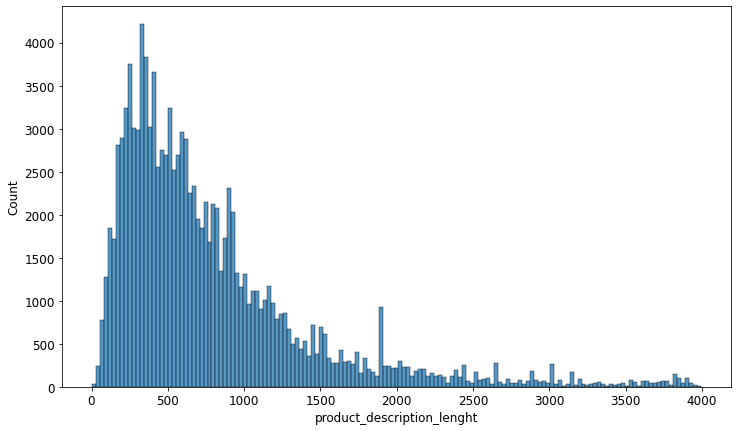

In [116]:
sns.histplot(df['product_description_lenght']);

In [117]:
for col in ['order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date','order_purchase_timestamp']:
    df[col] = pd.to_datetime(df[col])

In [118]:
df['delivery_time'] = df['order_delivered_customer_date'] - df['order_approved_at']

In [119]:
def get_hours(x):
    return x.total_seconds()
df['delivery_time'] = df['delivery_time'].apply(get_hours)

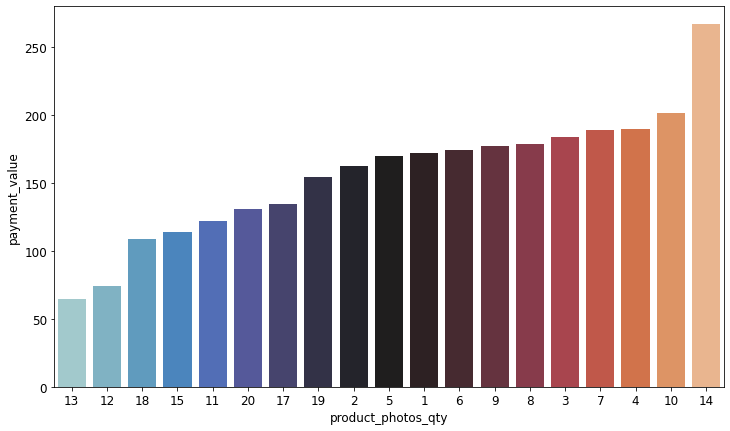

In [120]:
b = df.groupby(by='product_photos_qty')['payment_value'].mean().to_frame().reset_index().sort_values(by='payment_value')
b['product_photos_qty'] = b['product_photos_qty'].astype(int).astype(str)
sns.barplot(b['product_photos_qty'], b['payment_value'], palette = 'icefire');

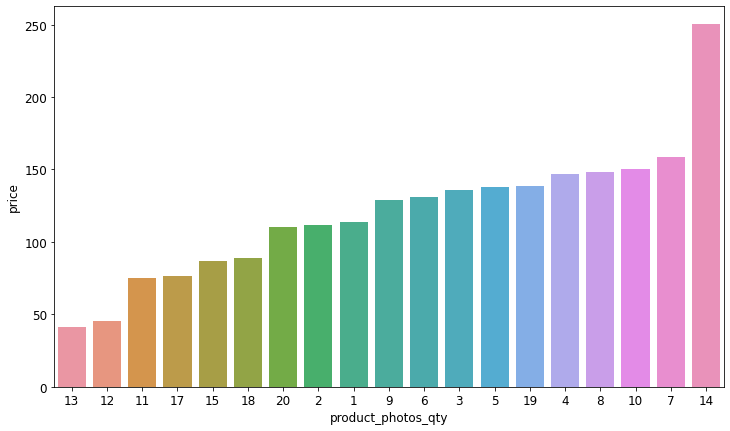

In [121]:
b = df.groupby(by='product_photos_qty')['price'].mean().to_frame().reset_index().sort_values(by='price')
b['product_photos_qty'] = b['product_photos_qty'].astype(int).astype(str)
sns.barplot(b['product_photos_qty'], b['price']);

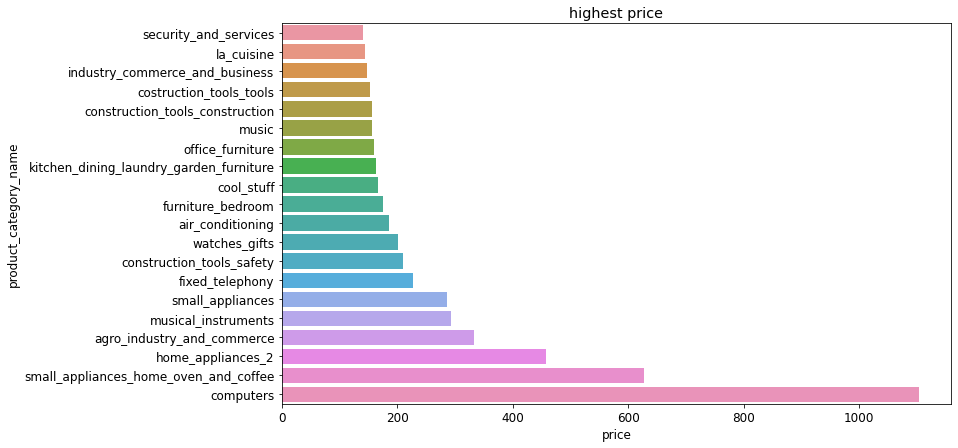

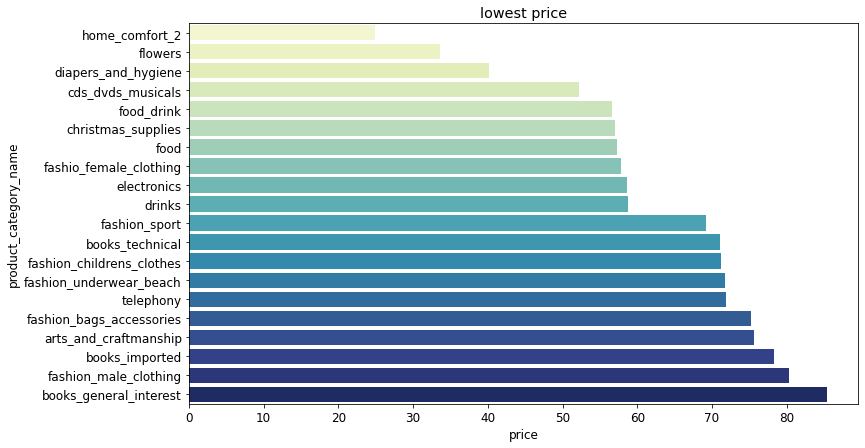

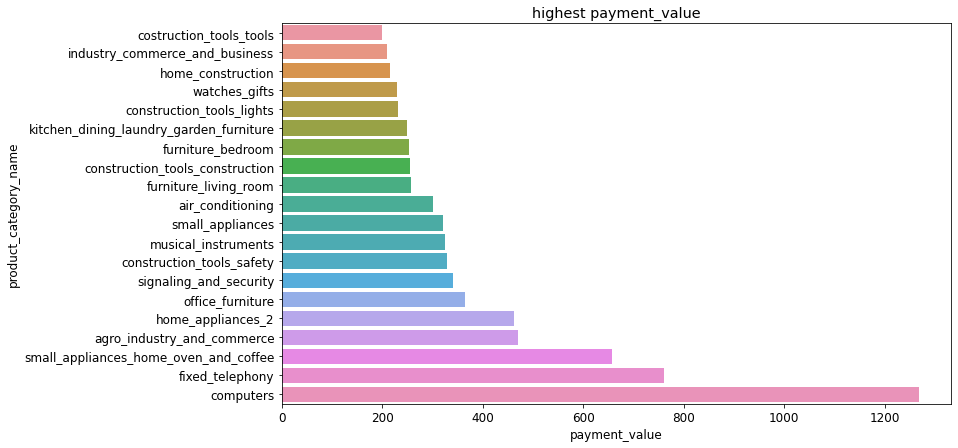

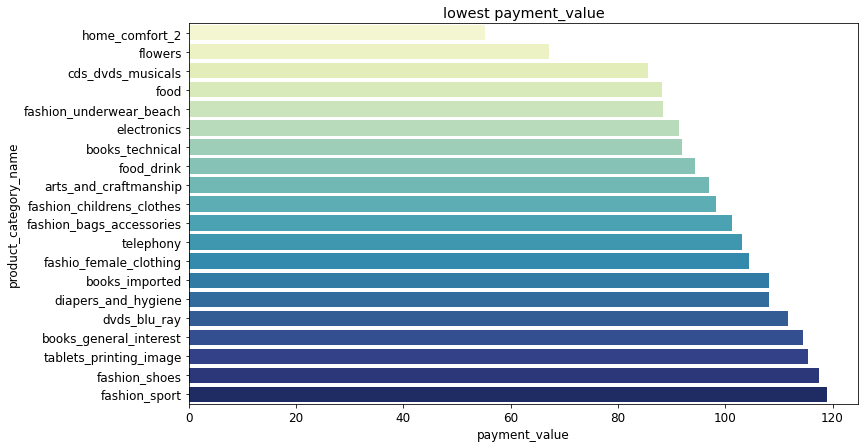

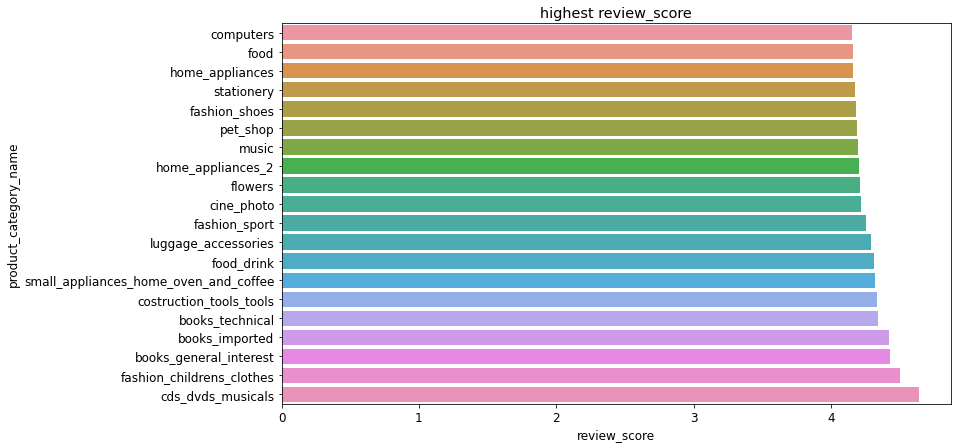

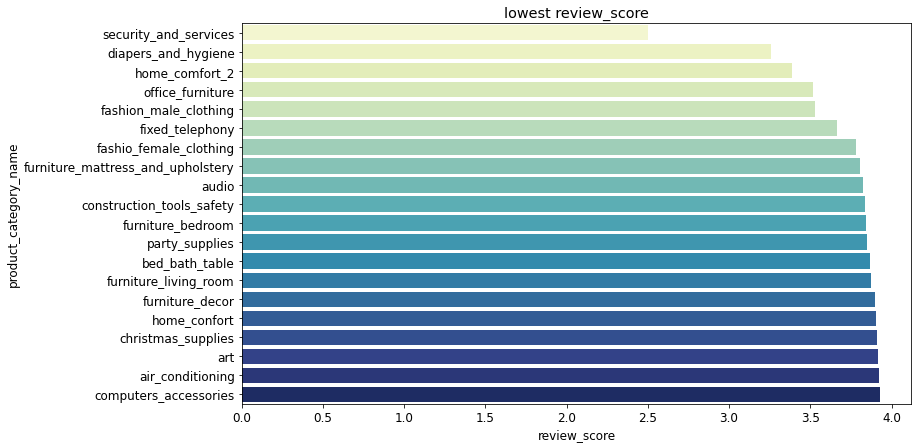

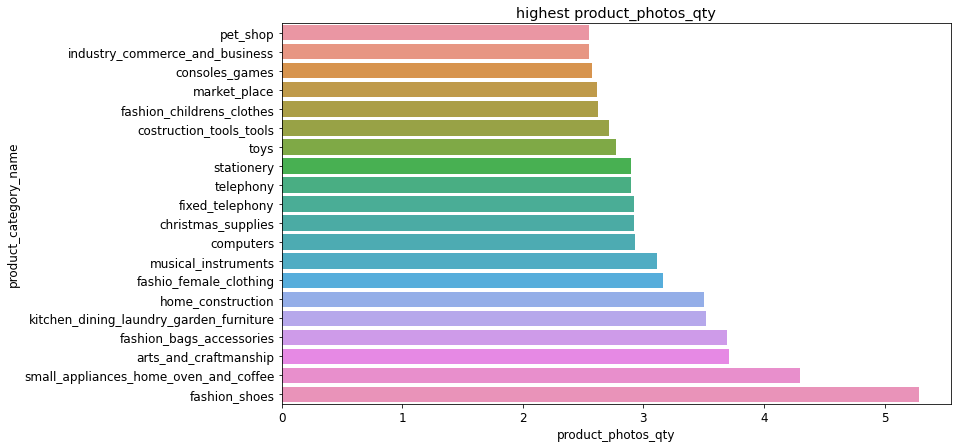

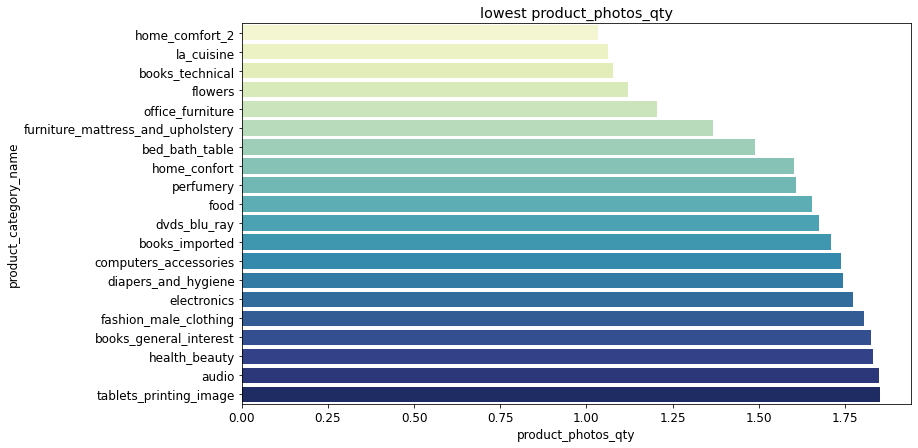

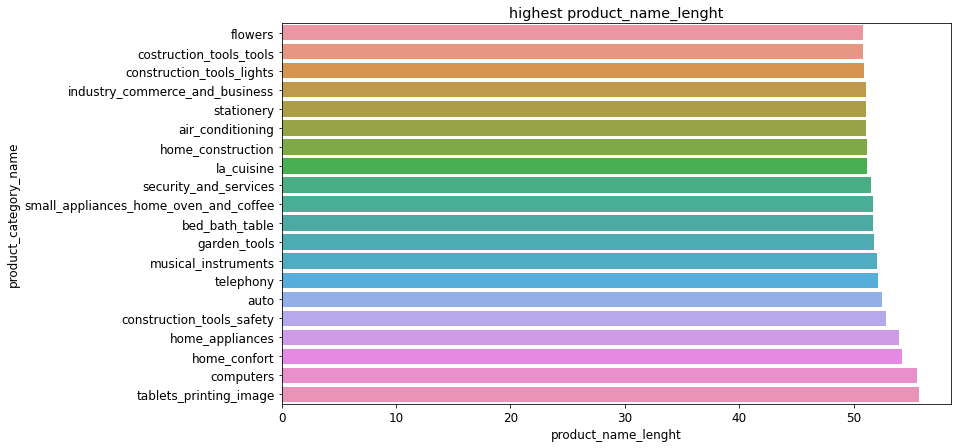

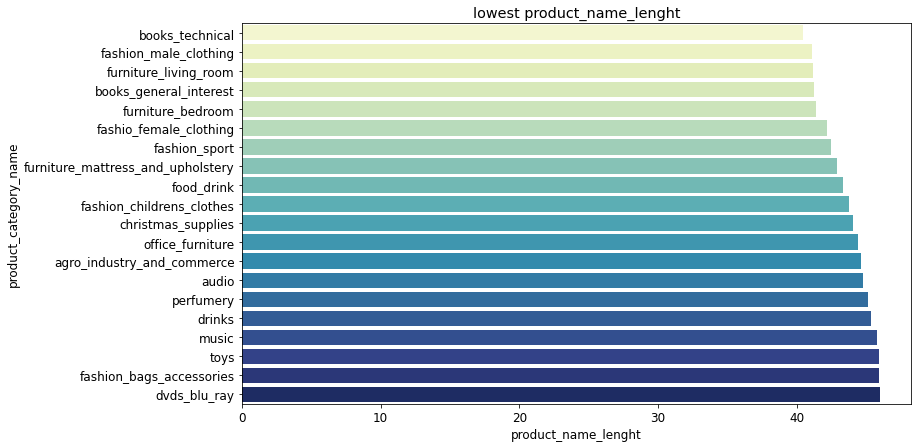

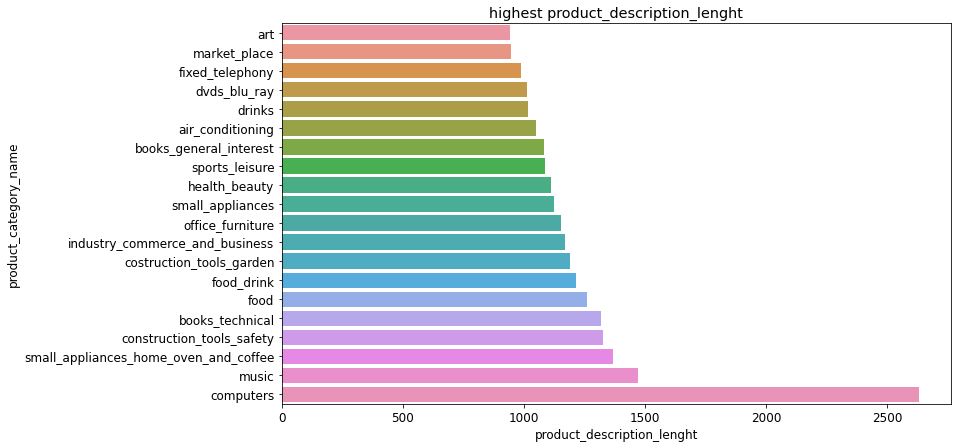

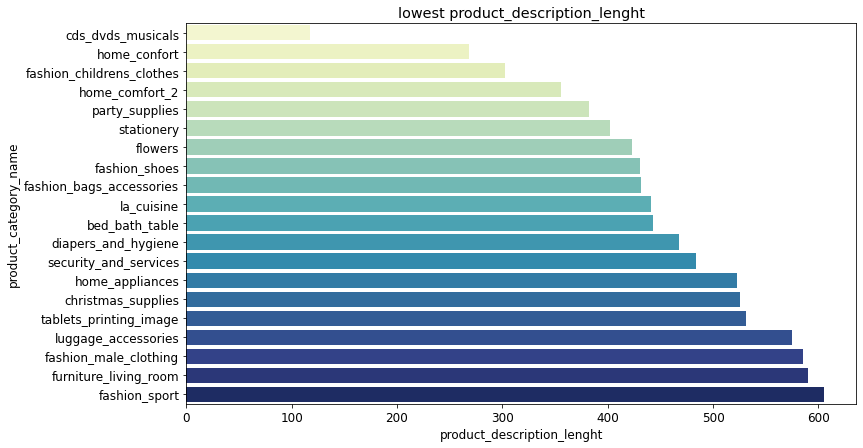

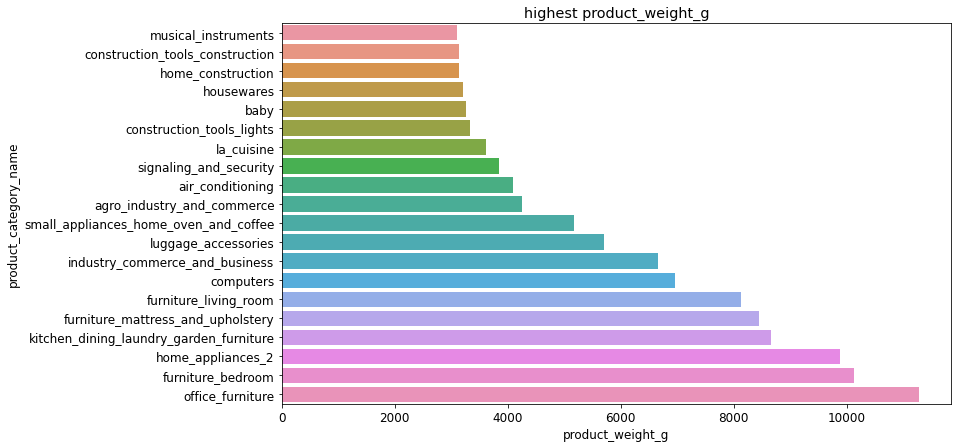

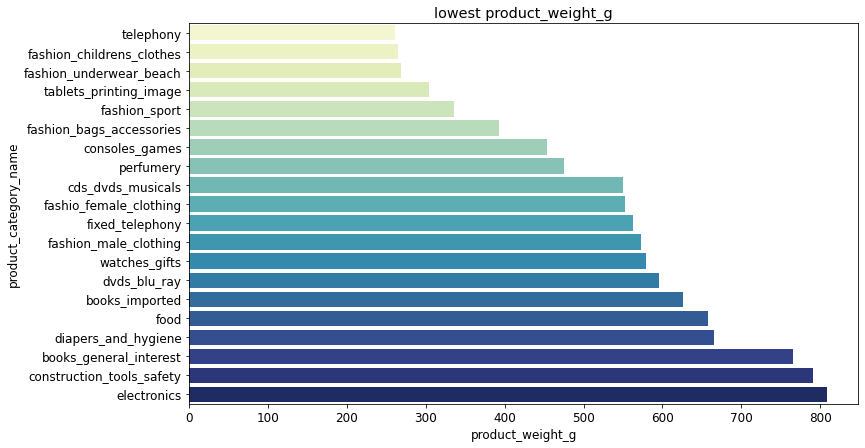

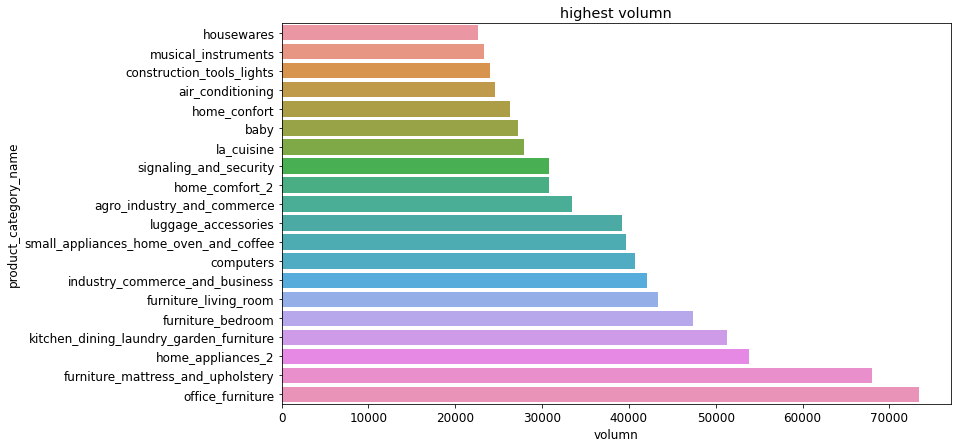

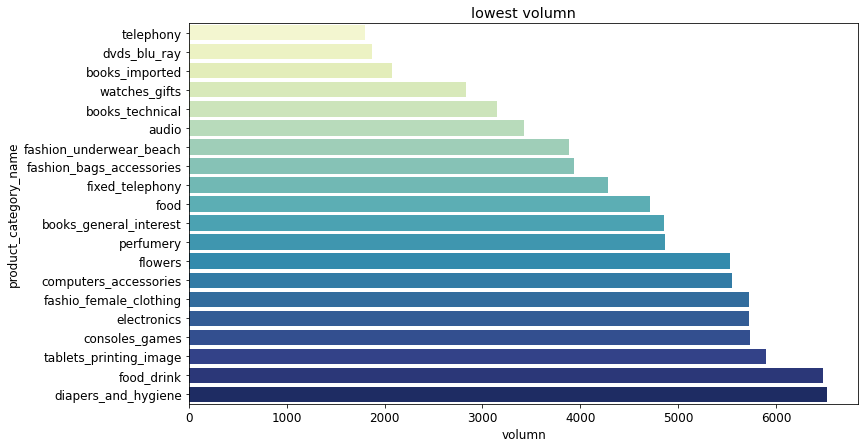

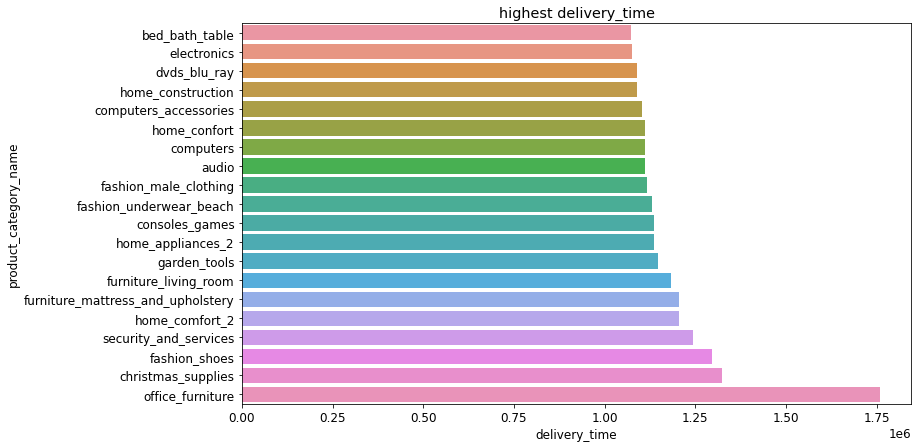

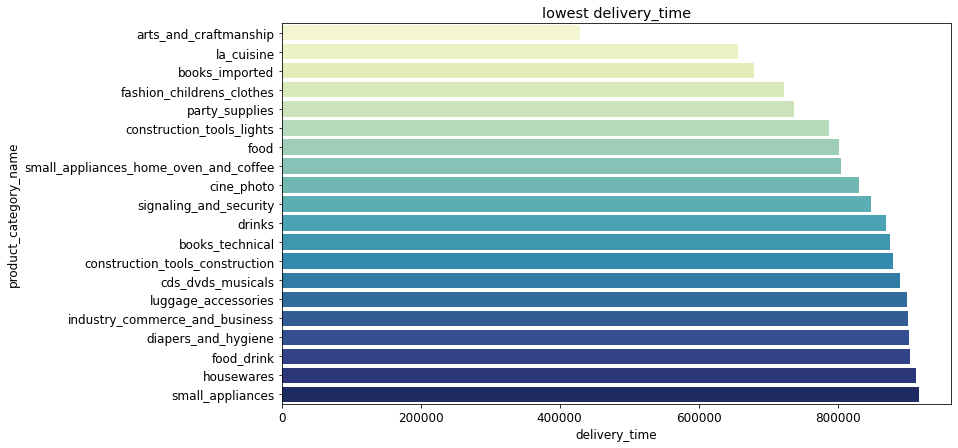

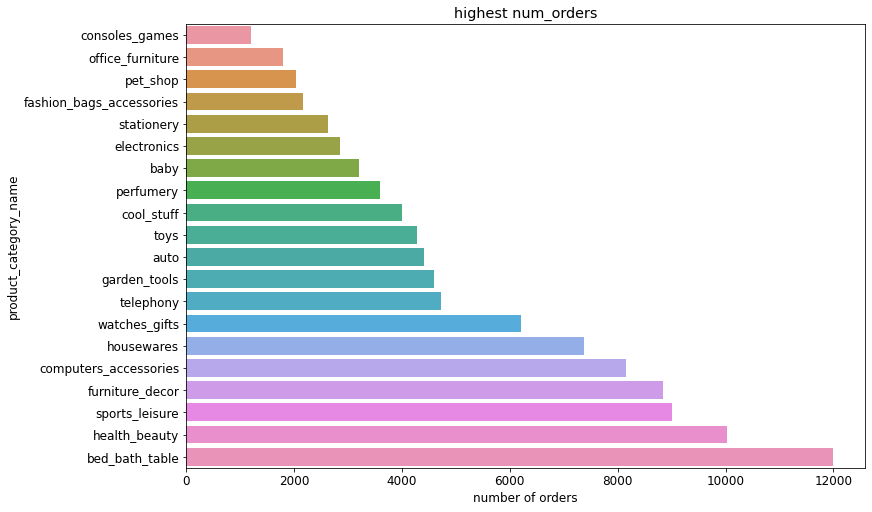

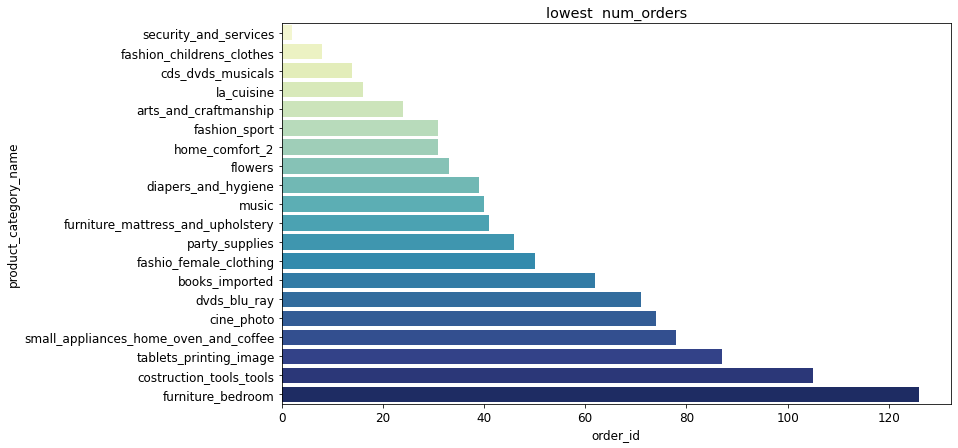

In [122]:
for i in ['price', 'payment_value', 'review_score', 'product_photos_qty', 'product_name_lenght', 'product_description_lenght', 'product_weight_g', 'volumn', 'delivery_time']:
    b = df.groupby(by='product_category_name')[i].mean().to_frame().reset_index().sort_values(by=i)
    plt.figure()
    ax = sns.barplot(b[i][-20:], b['product_category_name'][-20:]);
    ax.set_title('highest '+i)
    plt.figure()
    ax = sns.barplot(b[i][:20], b['product_category_name'][:20], palette='YlGnBu');
    ax.set_title('lowest '+i)
    
b = df.groupby(by='product_category_name')['order_id'].count().to_frame().reset_index().sort_values(by='order_id')
plt.figure(constrained_layout=True)
ax = sns.barplot(b['order_id'][-20:], b['product_category_name'][-20:]);
ax.set_title('highest '+'num_orders')
plt.xlabel('number of orders');
plt.figure()
ax=sns.barplot(b['order_id'][:20], b['product_category_name'][:20], palette='YlGnBu');
ax.set_title('lowest  '+'num_orders');

 - The heaviest-weight products usually have longer delivery time
 - Fashion shoes has the the most number of photos
 - Computers has longest product_description_lenght

<a id="3.3"></a>
<font color="dimgrey" size=+2.0><b>3.3 E-Commerce Around Brazil</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

For preparing the data to a workaround analysis on brazilian's states e-commerce, we will take the following steps:

    1. Merge the orders data to order_items data;
    2. Use an API (brazilian government) to return the region of each customer_state;
    3. Purpose useful charts to answear business questions.

* Brazilian APIs ans links for geolocation info:

        https://servicodados.ibge.gov.br/api/docs/localidades?versao=1

Thanks to Andre Sionek that threated the geolocation lat and long on his kernel!

In [123]:
# Merging orders and order_items
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_year_month2 order_purchase_date  \
0                    201710                    2017-10            20171002   
1                    201807                    2018-07            20180724   
2                    201808                    2018-08            20180808   
3                    201711                    2017-11            20171118   
4                    201802                    2018-02            20180213   

   order_purchase_day  order_purchase_dayofweek order_purchase_dayofweek_name  \
0                   2                         0                           Mon   
1                  24                         1                           Tue   
2                   8                         2                           Wed   
3                  18                         5                           Sat   
4                  13                         1                           Tue   

   order_purchase_hour order_purchase_time_day  order_item_id  \
0                   10                 Morning         1.0000   
1                   20                   Night         1.0000   
2                    8                 Morning         1.0000   
3                   19                   Night         1.0000   
4                   21                   Night         1.0000   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb3

___
* _An overview of customer's order by region, state and city_
___

In [124]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

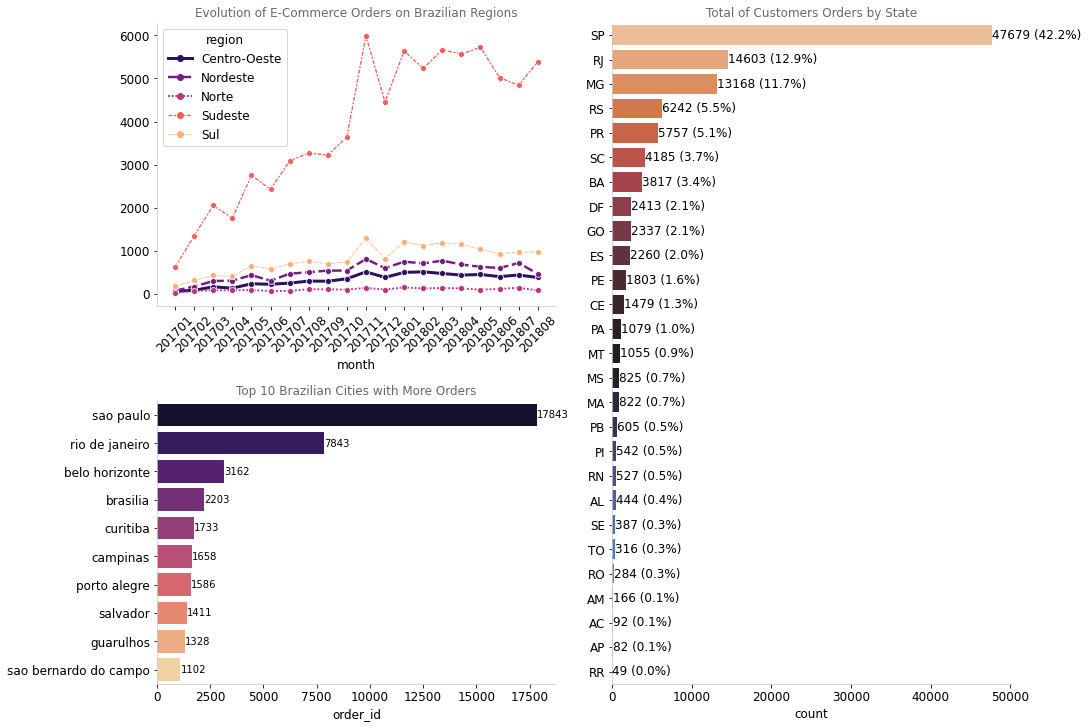

In [125]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='magma', markers=['o'] * 5)
format_spines(ax1, right_border=False)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
single_countplot(y='customer_state', ax=ax3, df=df_orders_filt, palette='icefire_r')
ax3.set_title('Total of Customers Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')

plt.show()

___
* _How customers are distributed in Brazil? (a 30k orders sample from 2018 in a map)_
___

In [126]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

___
* _**HeatMaps:** a good view to see where are the core of brazilian e-commerce customers_
___

By the map we showed above, we have already the insight that the southeast of Brazil has the highest number of orders given through e-commerce. So, let's see it in a HeatMap!

In [127]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(map1)

map1

use folium plugin _[HeatMapWithTime](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/HeatMapWithTime.ipynb)_ to see the evolution of e-commerce orders among time.

For [limitations](https://github.com/python-visualization/folium/issues/859) purpose (i.e. jupyter and Chrome limitations for total number of points shown at HeatMapWithTime, we will show the evolution of orders from January 2018 to July 2018)


In [128]:
epoch_list = []
heatmap_evl_data = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201801)]
heatmap_evl_data = heatmap_evl_data[(heatmap_evl_data['order_purchase_year_month'].astype(int) <= 201807)]
time_index = heatmap_evl_data['order_purchase_year_month'].sort_values().unique()
for epoch in time_index:
    data_temp = heatmap_evl_data.query('order_purchase_year_month == @epoch')
    data_temp = data_temp.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count()
    data_temp = data_temp.sort_values(by='order_id', ascending=False).iloc[:, :3]
    epoch_list.append(data_temp.values.tolist())
    
# Creating a mapa using folium
map2 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMapWithTime
HeatMapWithTime(
    name='Evolution of Orders in a Geolocation Perspective',
    data=epoch_list,
    radius=10,
    index=list(time_index)
).add_to(map2)

map2

<a id="3.4"></a>
<font color="dimgrey" size=+2.0><b>3.4 E-Commerce Impact on Economy</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Until now, we just answered questions on E-commerce scenario considering the number of orders received. We could see the volumetry amonth months, day of week, time of the day and even the geolocation states.

Now, we will analyze the money movemented by e-commerce by looking at order prices, freights and others.

___
* _How about the e-commerce sales? Did they grow up over time?_
___

For answear this question, let's first group our data in a way to look at the evolution overall.

In [129]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

order_purchase_year order_purchase_year_month  order_id        price  \
0                 2017                    201701       966 120,312.8700   
1                 2017                    201702      1998 247,303.0200   
2                 2017                    201703      3041 374,344.3000   
3                 2017                    201704      2697 359,927.2300   
4                 2017                    201705      4176 506,071.1400   

   freight_value  price_per_order  freight_per_order  
0    16,875.6200         124.5475            17.4696  
1    38,977.6000         123.7753            19.5083  
2    57,704.2900         123.0991            18.9754  
3    52,495.0100         133.4547            19.4642  
4    80,119.8100         121.1856            19.1858

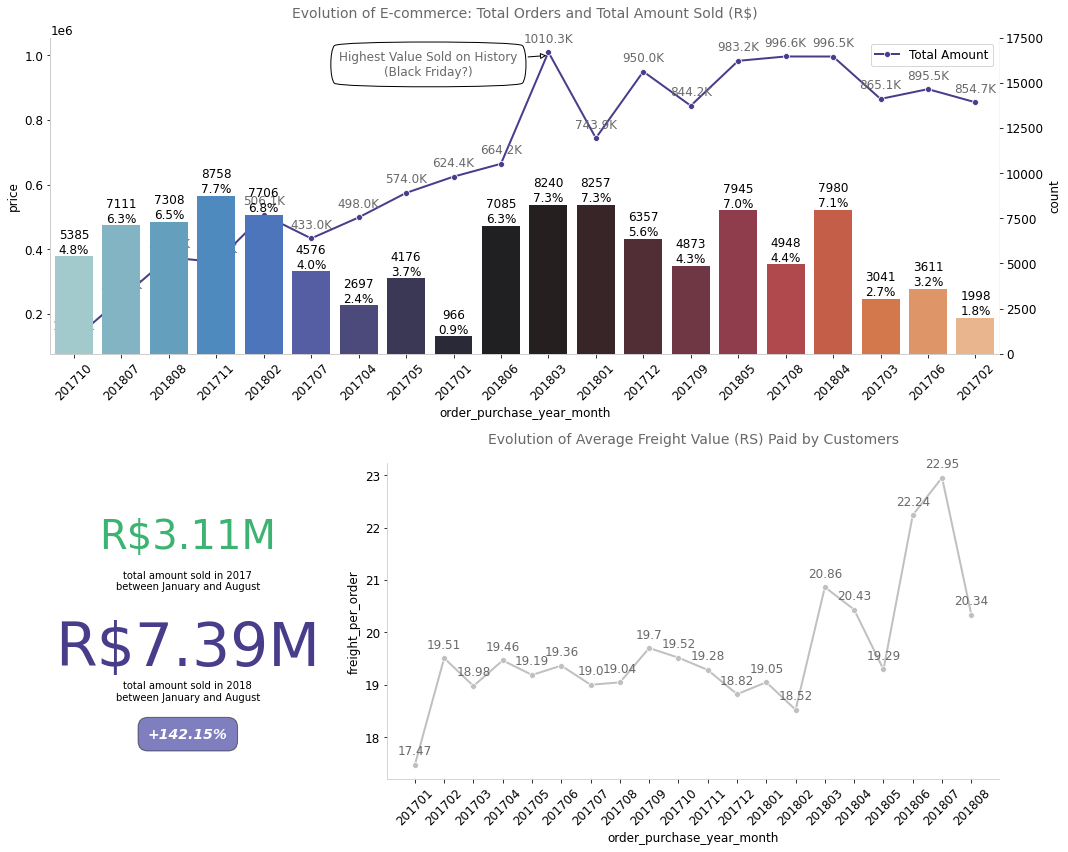

In [130]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
single_countplot(df_orders_filt, x='order_purchase_year_month', ax=ax1_twx, order=False, palette='icefire')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
format_spines(ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax1.annotate(f'Highest Value Sold on History\n(Black Friday?)', (10, 1000000), xytext=(-120, -20), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)
format_spines(ax3, right_border=False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

___
* _How the total sales (sum of price) are concentraded in brazilian states?_
___

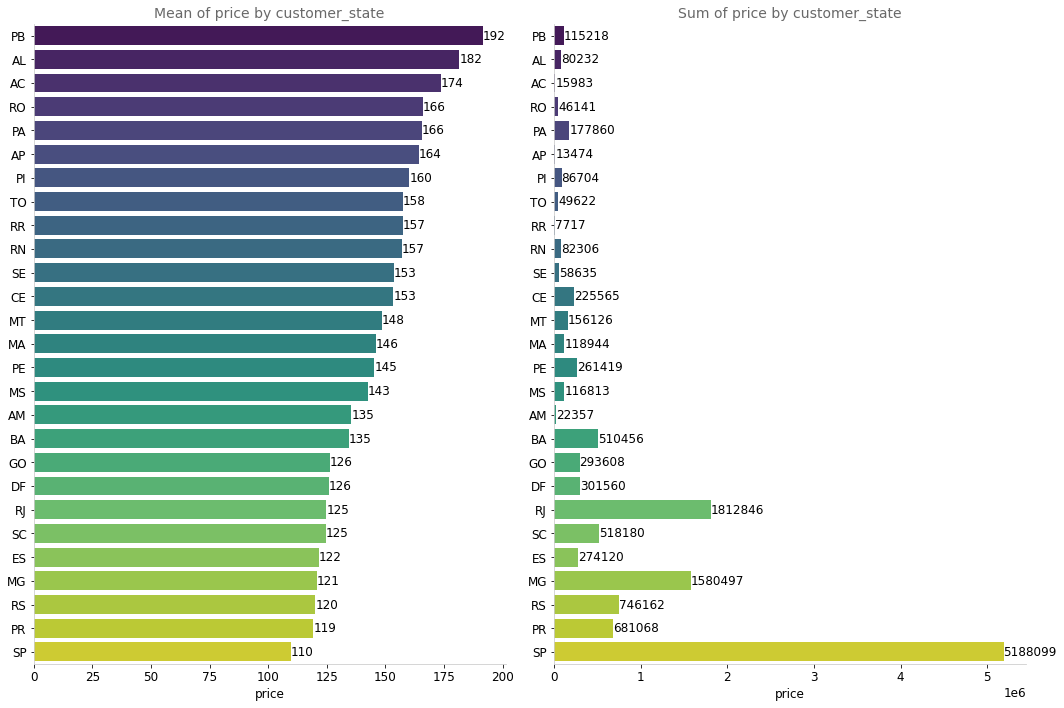

In [131]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'price', palette='viridis', figsize=(15, 10))

It's very interesting to see how some states have a high total amount sold and a low price per order. If we look at SP (São Paulo) for example, it's possible to see that it is the state with most valuable state for e-commerce (5,188,099 sold) but it is also where customers pay less per order (110.00 per order).

How about the freight?

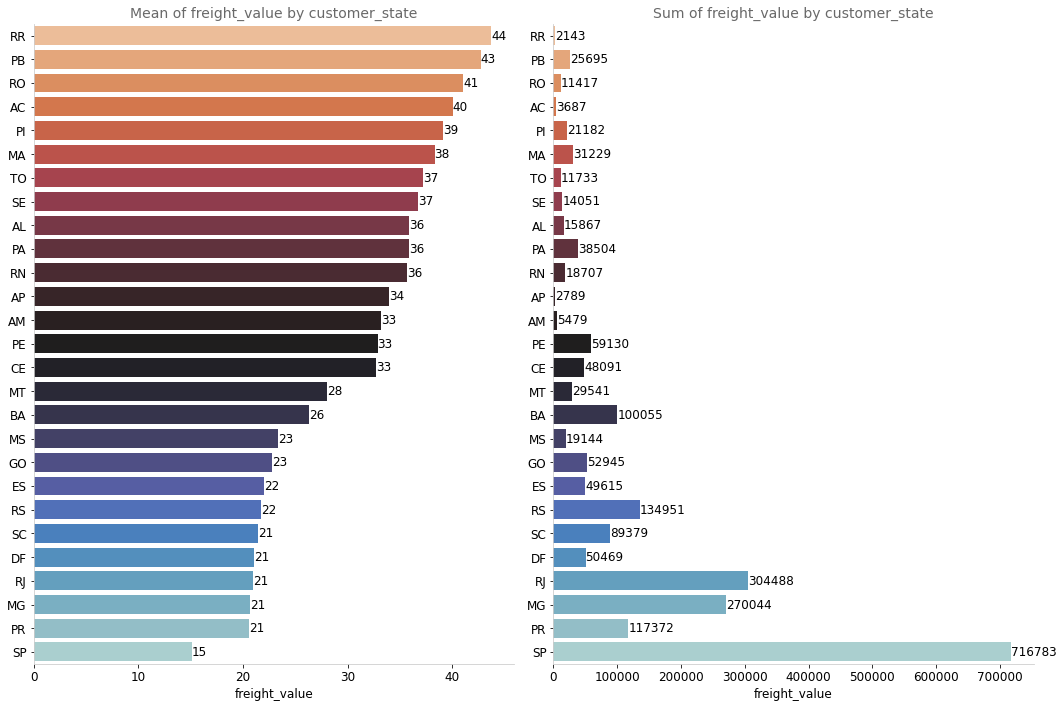

In [132]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'freight_value', palette='icefire_r', figsize=(15, 10))

Here we can get insights about the customers states with highest mean freight value. For example, customers in Roraima (RR), Paraíba (PB), Rondônia (RO) and Acre (AC) normaly pays more than anyone on freights.

#### Mean Freight by States
The objective here is to get the mean value when Seller is from X State and Customer from Y State.
- I will select only the more frequent states to a better view 

In [133]:
df_st = olist_orders.merge(olist_order_items, on='order_id')
df_st = df_st.merge(cus, on = 'customer_id')
df_st = df_st.merge(sellers, on='seller_id')

In [134]:
# Seting regions
sudeste = ['SP', 'RJ', 'ES','MG']
nordeste= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF' ]
sul = ['SC', 'RS', 'PR']

In [135]:
df_st.loc[df_st['customer_state'].isin(sudeste), 'cust_Region'] = 'Southeast'
df_st.loc[df_st['customer_state'].isin(nordeste), 'cust_Region'] = 'Northeast'
df_st.loc[df_st['customer_state'].isin(norte), 'cust_Region'] = 'North'
df_st.loc[df_st['customer_state'].isin(centro_oeste), 'cust_Region'] = 'Midwest'
df_st.loc[df_st['customer_state'].isin(sul), 'cust_Region'] = 'South'

In [136]:
df_st['cust_Region'].value_counts()

Southeast    77413
South        16151
Northeast    10409
Midwest       6613
North         2064
Name: cust_Region, dtype: int64

In [137]:
def cross_heatmap(df_st, cols, normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df_st[temp[0]], df_st[temp[1]], 
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)
cross_heatmap(df_st[df_st['price'] != -1], ['seller_state', 'cust_Region'], 
              values=df_st[df_st['price'] != -1]['freight_value'], aggfunc='mean')

___
* _What are the best states to buy in Brazil? An analysis on sales, freight and delivery time_
___

In [138]:
# Calculating working days between purchasing, delivering and estimated delivery
purchasing = df_orders_filt['order_purchase_timestamp']
delivered = df_orders_filt['order_delivered_customer_date']
estimated = df_orders_filt['order_estimated_delivery_date']
df_orders_filt['time_to_delivery'] = calc_working_days(purchasing, delivered, convert=True)
df_orders_filt['diff_estimated_delivery'] = calc_working_days(estimated, delivered, convert=True)

# Grouping data by state
states_avg_grouped = df_orders_filt.groupby(by='customer_state', as_index=False).mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]

# Sorting data
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery', ascending=False)
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery')

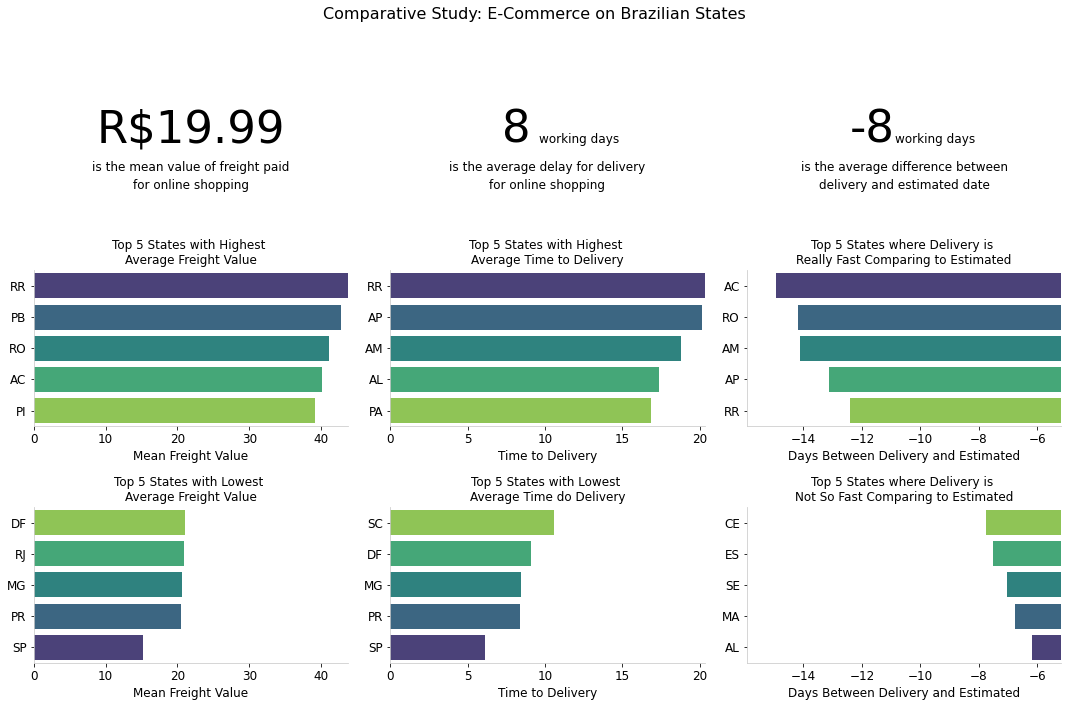

In [139]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot Pack 01 - Freight value paid on states
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.head(), ax=axs[1, 0], palette='viridis')
axs[1, 0].set_title('Top 5 States with Highest \nAverage Freight Value', size=12, color='black')
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.tail(), ax=axs[2, 0], palette='viridis_r')
axs[2, 0].set_title('Top 5 States with Lowest \nAverage Freight Value', size=12, color='black')
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('Mean Freight Value')
    ax.set_xlim(0, states_freight_paid['freight_value'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 0].text(0.50, 0.30, f'R${round(df_orders_filt.freight_value.mean(), 2)}', fontsize=45, ha='center')
axs[0, 0].text(0.50, 0.12, 'is the mean value of freight paid', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, 'for online shopping', fontsize=12, ha='center')
axs[0, 0].axis('off')

# Plot Pack 02 - Time to delivery on states
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.head(), ax=axs[1, 1], palette='viridis')
axs[1, 1].set_title('Top 5 States with Highest \nAverage Time to Delivery', size=12, color='black')
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.tail(), ax=axs[2, 1], palette='viridis_r')
axs[2, 1].set_title('Top 5 States with Lowest \nAverage Time do Delivery', size=12, color='black')
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('Time to Delivery')
    ax.set_xlim(0, states_time_to_delivery['time_to_delivery'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')
    
# Annotations
axs[0, 1].text(0.40, 0.30, f'{int(df_orders_filt.time_to_delivery.mean())}', fontsize=45, ha='center')
axs[0, 1].text(0.60, 0.30, 'working days', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.12, 'is the average delay for delivery', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, 'for online shopping', fontsize=12, ha='center')
axs[0, 1].axis('off')
    
# Plot Pack 03 - Differnece between delivered and estimated on states
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.head(), ax=axs[1, 2], palette='viridis')
axs[1, 2].set_title('Top 5 States where Delivery is \nReally Fast Comparing to Estimated', size=12, color='black')
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.tail(), ax=axs[2, 2], palette='viridis_r')
axs[2, 2].set_title('Top 5 States where Delivery is \nNot So Fast Comparing to Estimated', size=12, color='black')
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Days Between Delivery and Estimated')
    ax.set_xlim(states_estimated_delivery['diff_estimated_delivery'].min()-1, 
                states_estimated_delivery['diff_estimated_delivery'].max()+1)
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 2].text(0.40, 0.30, f'{int(df_orders_filt.diff_estimated_delivery.mean())}', fontsize=45, ha='center')
axs[0, 2].text(0.60, 0.30, 'working days', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.12, 'is the average difference between', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'delivery and estimated date', fontsize=12, ha='center')
axs[0, 2].axis('off') 
    
plt.suptitle('Comparative Study: E-Commerce on Brazilian States', size=16)
plt.tight_layout()
plt.show()

<a id="3.5"></a>
<font color="dimgrey" size=+2.0><b>3.5 Payment Type Analysis</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

One of the datasets provided have informations about order's payment. To see how payments can take influence on e-commerce, we can build a mini-dashboard with main concepts: `payments type` and `payments installments`. The idea is to present enough information to clarify how e-commerce buyers usually prefer to pay orders.

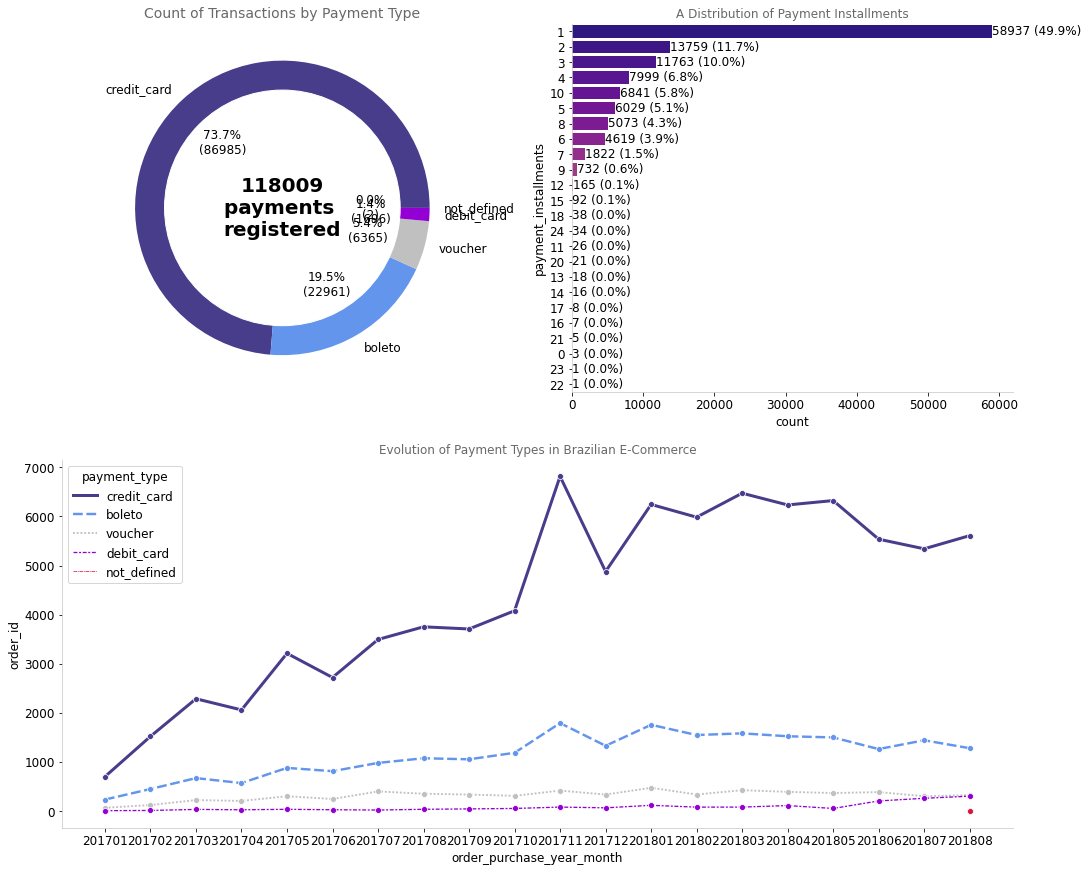

In [140]:
# Grouping data
df_orders_pay = df_orders_filt.merge(olist_order_payments, how='left', on='order_id')

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Plot 1 - Payment types in a donut chart
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
label_names = df_orders_pay['payment_type'].value_counts().index
donut_plot(df_orders_pay, col='payment_type', ax=ax1, label_names=label_names, colors=colors,
           title='Count of Transactions by Payment Type', text=f'{len(df_orders_pay)}\npayments \nregistered')

# Plot 2 - Payment installments
single_countplot(df_orders_pay, ax=ax2, y='payment_installments')
ax2.set_title('A Distribution of Payment Installments', color='dimgrey', size=12)

# Plot 3 - Evolution of payment types
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', size='payment_type', palette=colors, marker='o')
format_spines(ax3, right_border=False)
ax3.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=12, color='dimgrey')
plt.show()

In fact, we can see by the line chart that payments made by credit card really took marjority place on brazilian e-commerce. Besides that, since 201803 it's possible to see a little decrease on this type of payment. By the other side, payments made by debit card is showing a growing trend since 201805, wich is a good opportunity for investor to improve services for payments like this.

On the bar chart above, we can see how brazilian customers prefer to pay the orders: mostly of them pay once into 1 installment and it's worth to point out the quantity of payments done by 10 installments.

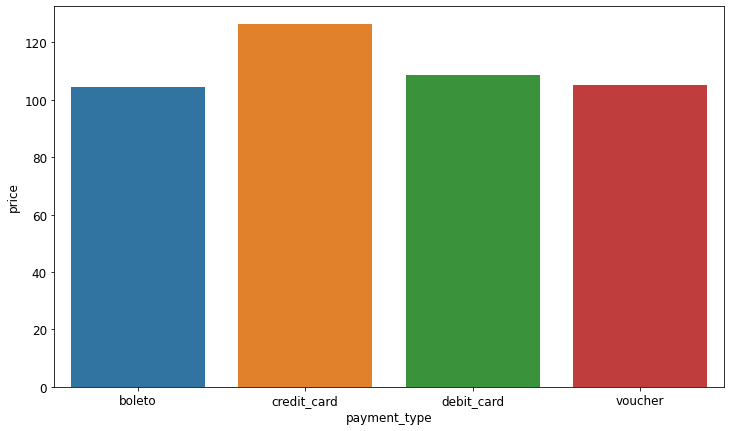

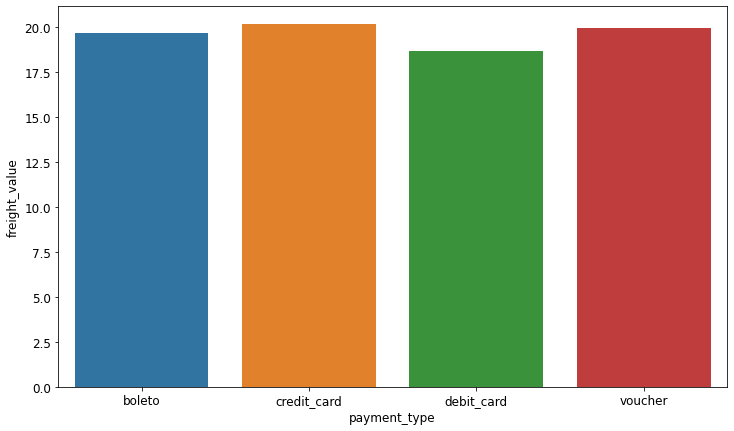

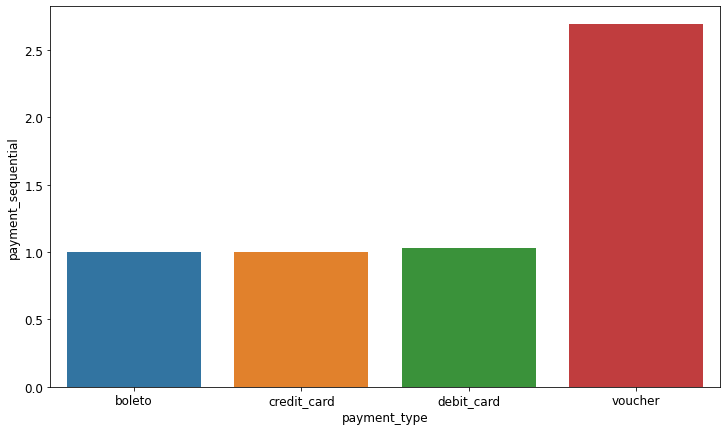

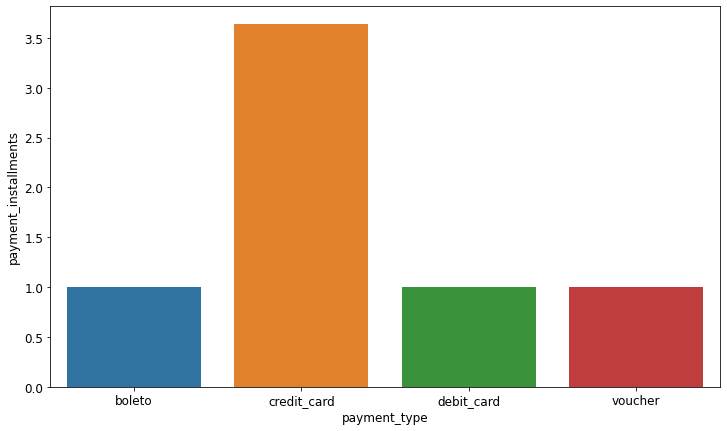

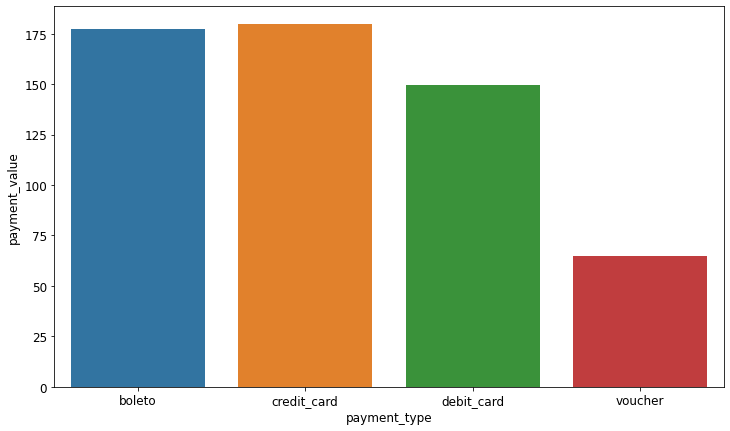

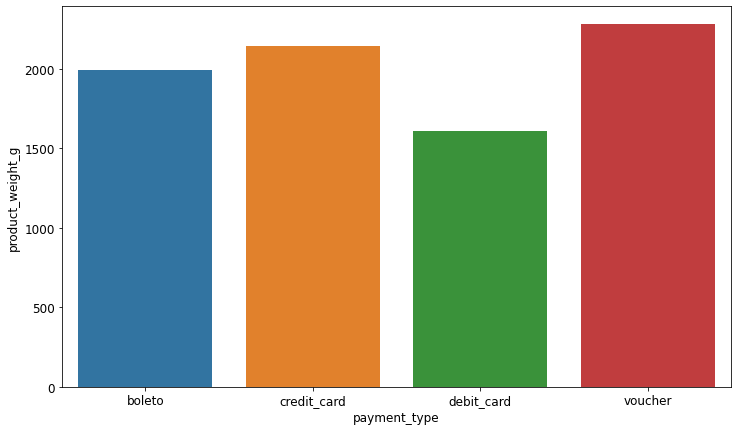

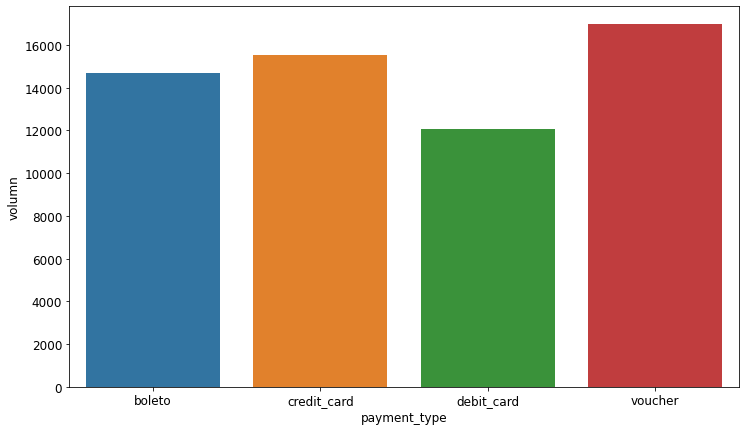

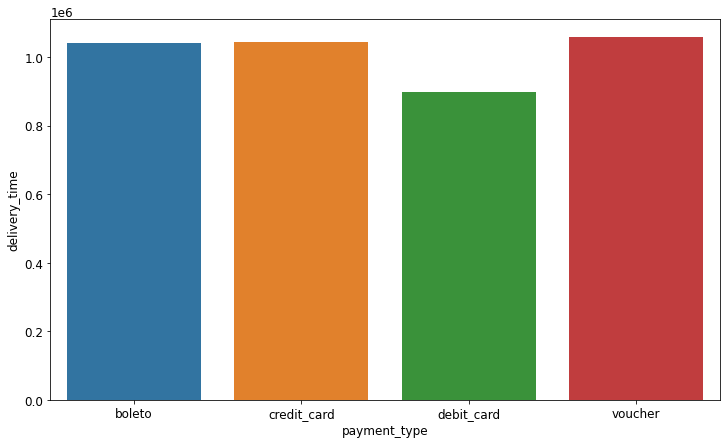

In [141]:
pmt = df.groupby(by='payment_type').mean()
pmt = pmt.reset_index()
for i in ['price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 'product_weight_g', 'volumn', 'delivery_time']:
    plt.figure()
    sns.barplot(x='payment_type', y=i, data=pmt);

- vouchers are used for small trades but with big product???
- payment insstallment of credit card is much larger than the others


<a id="4"></a>
<font color="darkslateblue" size=+2.4><b>4. RFM, Cohort analysis, CLV</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

<a href="http://localhost:8888/notebooks/Desktop/Customer%20Segmentation-20210504T015643Z-001/RFM%2C%20Cohort%2C%20CLV.ipynb">I do it in a separate notebook</a>

<a id="5"></a>
<font color="darkslateblue" size=+2.5><b>5. Customer Segmentation</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

## Create features for customers

In [142]:
df['payment_type2'] = df['payment_type'].replace({'not_defined':0, 'credit_card':4, 'voucher':2, 'boleto':3, 'debit_card':1})

In [143]:
snapshot_date = df['order_purchase_timestamp'].max() + datetime.timedelta(days=1)

In [144]:
df_cus = df.groupby(['customer_id']).agg({
'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
'order_id': 'count',
'payment_value': 'sum',
'review_score': 'mean',
'payment_type2': 'last',
'payment_type': 'last',
})

In [145]:
df_cus = df_cus.reset_index()
df_cus.columns=['customer_id', 'days_since_last_buy', 'num_orders', 'payment_value', 'review_score', 'payment_type', 'payment_type_in_letters']

In [146]:
df_cus

customer_id  days_since_last_buy  num_orders  \
0      00012a2ce6f8dcda20d059ce98491703                  293           1   
1      000161a058600d5901f007fab4c27140                  414           1   
2      0001fd6190edaaf884bcaf3d49edf079                  552           1   
3      0002414f95344307404f0ace7a26f1d5                  383           1   
4      000379cdec625522490c315e70c7a9fb                  154           1   
...                                 ...                  ...         ...   
98660  fffcb937e9dd47a13f05ecb8290f4d3e                  171           1   
98661  fffecc9f79fd8c764f843e9951b11341                  158           3   
98662  fffeda5b6d849fbd39689bb92087f431                  104           1   
98663  ffff42319e9b2d713724ae527742af25                   82           1   
98664  ffffa3172527f765de70084a7e53aae8                  366           2   

       payment_value  review_score  payment_type payment_type_in_letters  
0           114.7400        1.0000             4             credit_card  
1            67.4100        4.0000             4             credit_card  
2           195.4200        5.0000             4             credit_card  
3           179.3500        5.0000             3                  boleto  
4           107.0100        4.0000             3                  boleto  
...              ...           ...           ...                     ...  
98660        91.9100        5.0000             4             credit_card  
98661        81.3600        3.0000             2                 voucher  
98662        63.1300        4.0000             4             credit_card  
98663       214.1300        5.0000             4             credit_card  
98664        91.0000        5.0000             4             credit_card  

[98665 rows x 7 columns]

In [147]:
df_cus = df_cus[df_cus['payment_value']<680]

In [148]:
columns = ['days_since_last_buy', 'num_orders', 'payment_value', 'review_score', 'payment_type']

In [149]:
df1 = df_cus.copy()
# scale
df2 = df1.copy()
scaler = MinMaxScaler()
for i in columns:
    scaler.fit(df2[[i]])
    df2[[i]] = scaler.transform(df2[[i]])

## k-means

In [150]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
X = df2[columns]
K = range(1, 10) 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X) 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

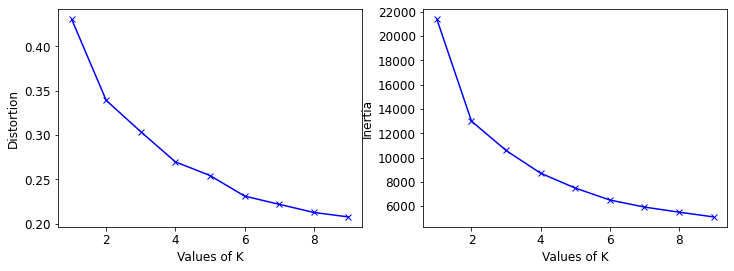

In [151]:
fig, ax = plt.subplots(1,2, figsize=[12,4])
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('Values of K')
ax[0].set_ylabel('Distortion')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('Values of K')
ax[1].set_ylabel('Inertia');

In [152]:
kmeans = KMeans(n_clusters=5, max_iter=500, random_state=42)
kmeans.fit(df2[columns])

KMeans(max_iter=500, n_clusters=5, random_state=42)

In [153]:
df_cus['cluster'] = kmeans.labels_

In [154]:
df_cus['cluster'].value_counts()

4    34959
3    22500
0    15514
2    13168
1     8021
Name: cluster, dtype: int64

In [155]:
pd.options.display.float_format = '{:,.4f}'.format
df_cus.groupby(by='cluster').mean().T

cluster                    0        1        2        3        4
days_since_last_buy 201.6185 236.3905 249.5287 430.3098 147.1311
num_orders            1.2106   1.4674   1.2340   1.0717   1.0513
payment_value       104.7655 419.5135 165.4447 112.4779 107.9868
review_score          4.5692   4.5476   1.2243   4.5495   4.6064
payment_type          2.6829   3.8504   3.7094   3.8610   4.0000

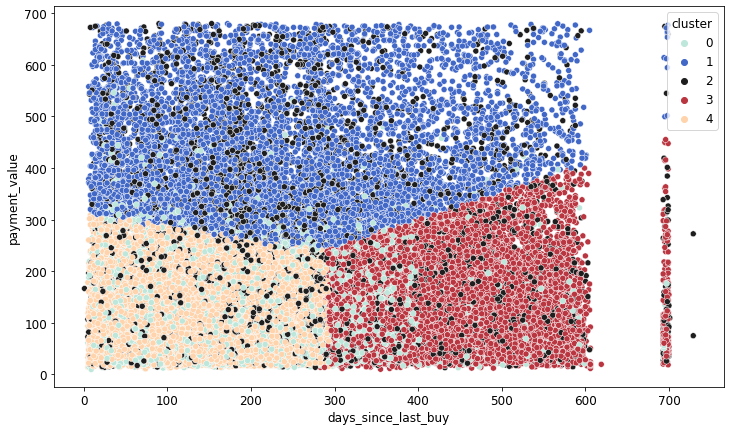

In [156]:
sns.scatterplot(x='days_since_last_buy', y='payment_value', hue='cluster', data=df_cus, palette='icefire');

In [157]:
a = df_cus.groupby(by='cluster').mean().reset_index()

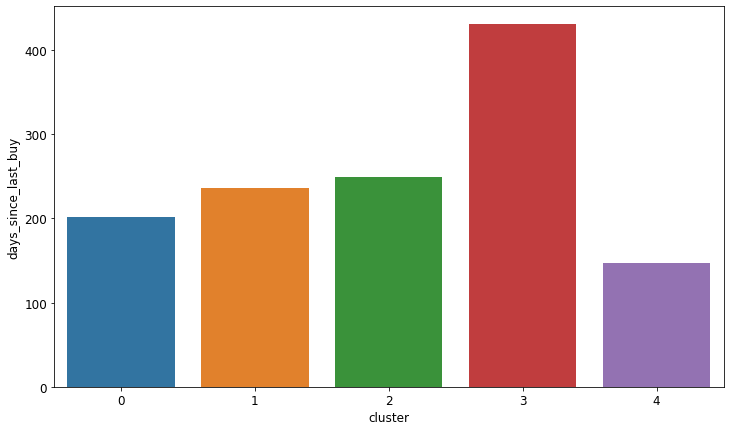

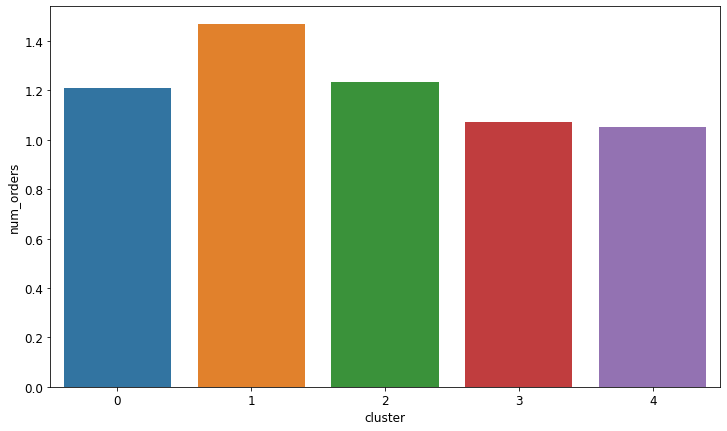

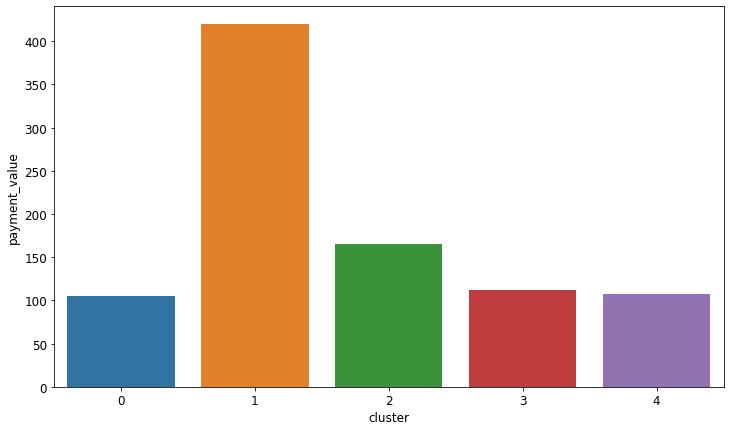

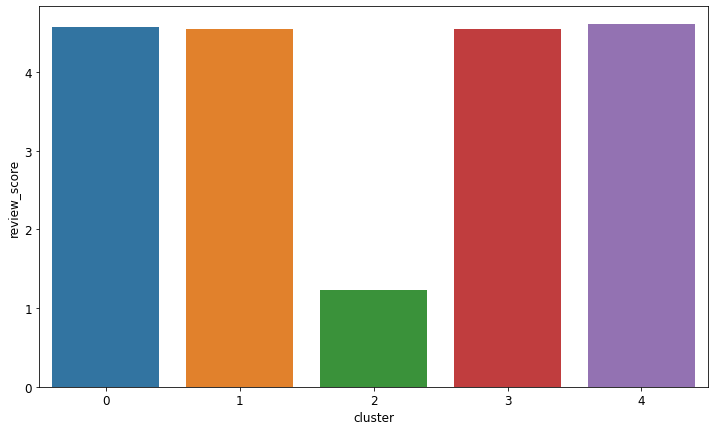

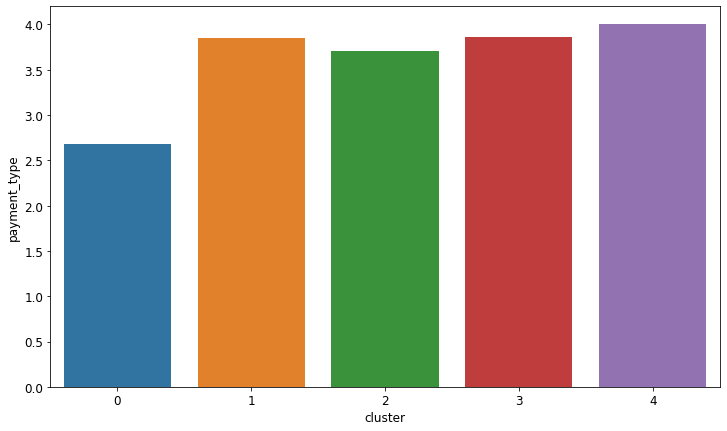

In [158]:
for i in a.columns[1:]:
    plt.figure()
    sns.barplot(x='cluster', y=i, data=a)

In [159]:
a = df_cus.groupby(by='cluster')['payment_type_in_letters'].value_counts().to_frame()
a.columns=['count']
a = a.reset_index()

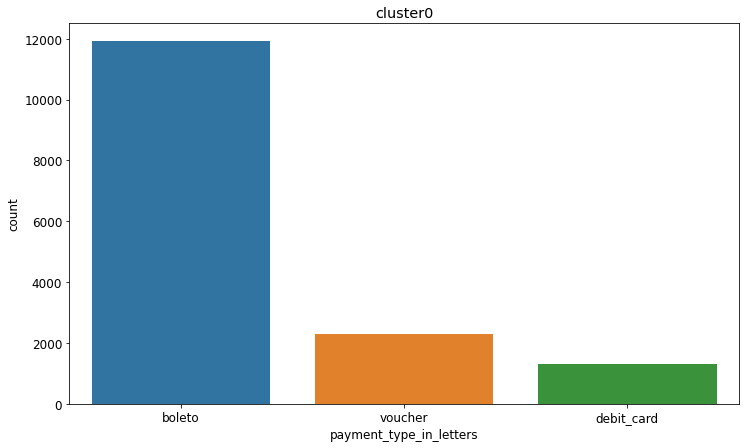

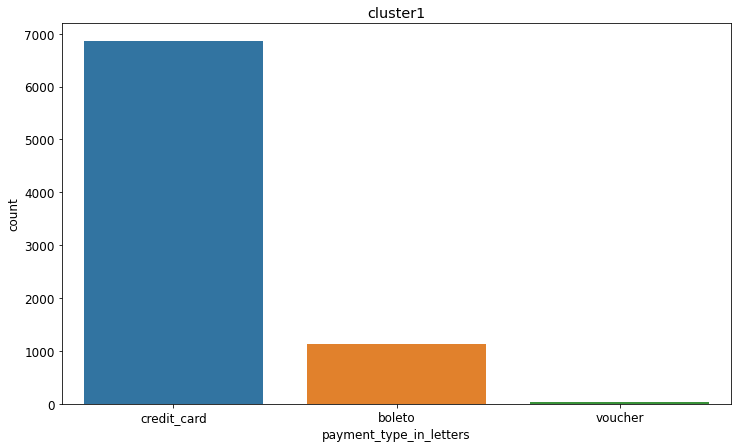

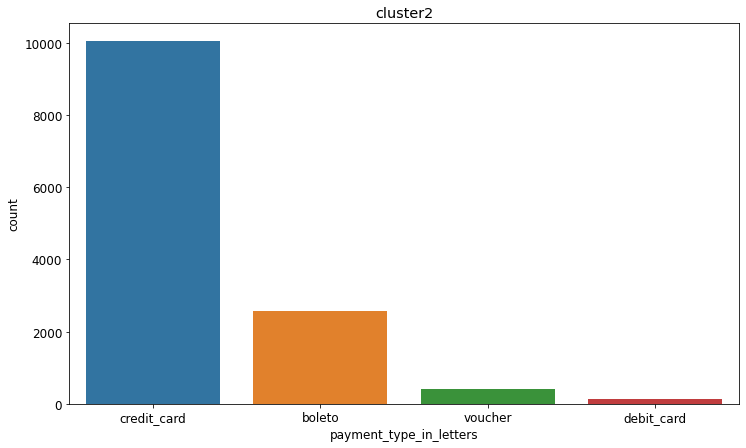

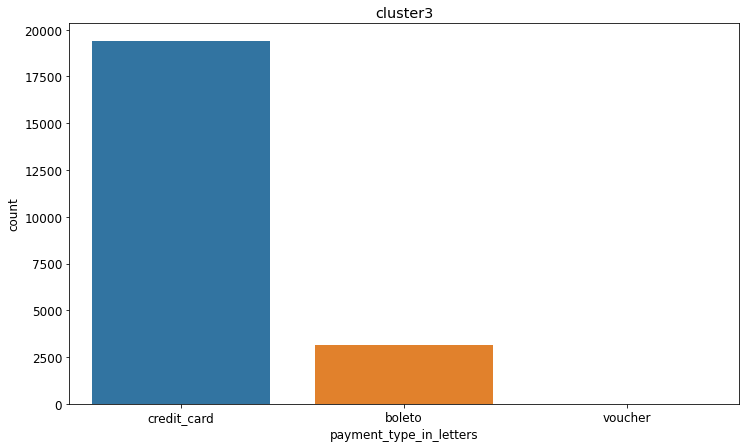

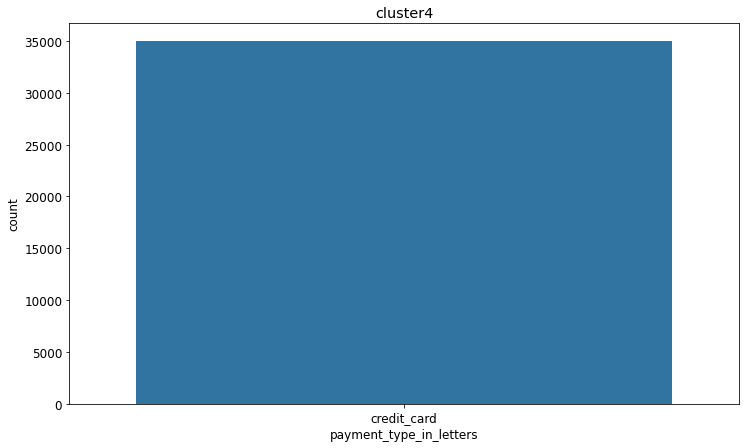

In [160]:
for i in a['cluster'].unique():
    df_sub = a[a['cluster']==i]
    plt.figure()
    sns.barplot(x='payment_type_in_letters', y='count', data=df_sub)
    plt.title('cluster'+str(i))

## SpectralBiclustering

In [169]:
from sklearn.cluster import SpectralBiclustering
cluster = SpectralBiclustering(n_clusters=5, method='bistochastic')
cluster.fit(df1[columns])

SpectralBiclustering(n_clusters=5)

In [170]:
df_cus['cluster2'] = cluster.row_labels_

In [171]:
df_cus['cluster2'].value_counts()

1    30900
4    29626
0    19296
3     7534
2     6806
Name: cluster2, dtype: int64

In [172]:
a = df_cus.groupby(by='cluster2').mean().reset_index()

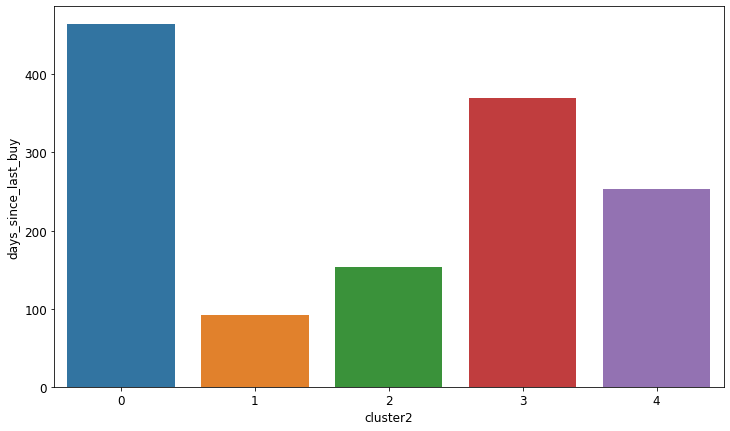

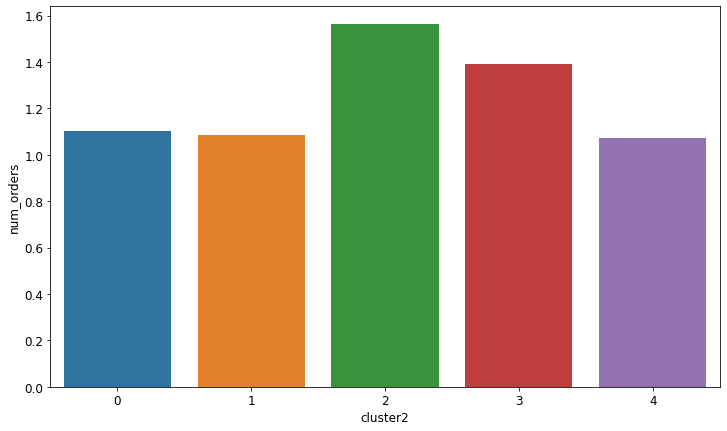

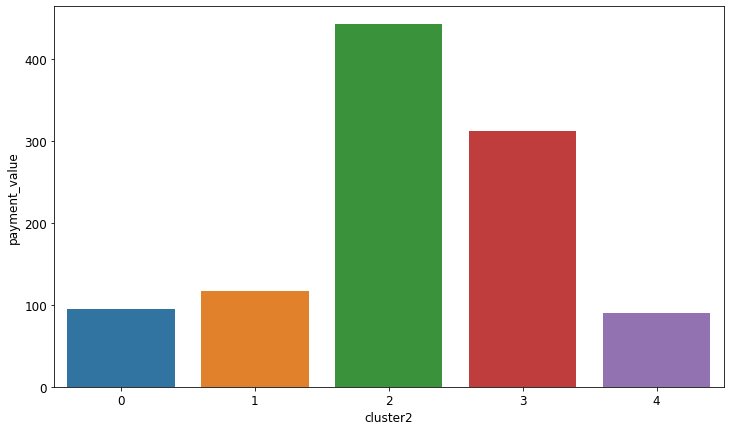

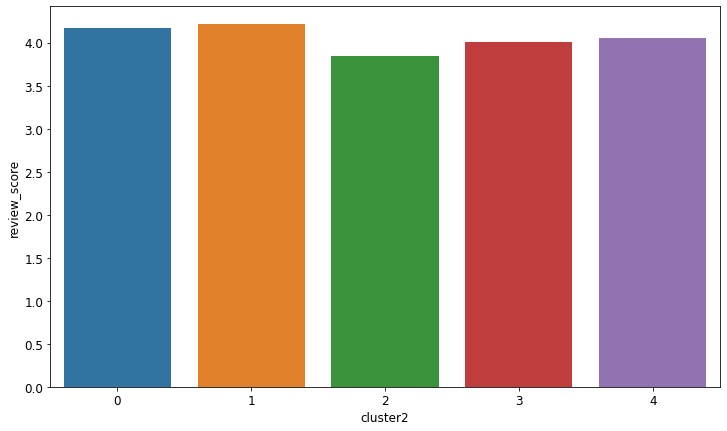

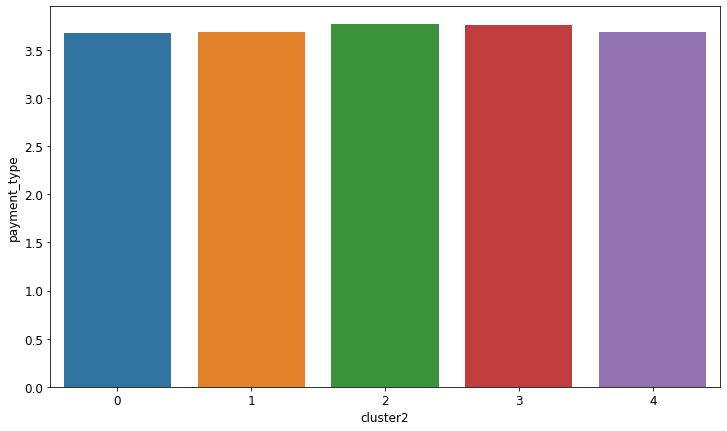

In [173]:
for i in a.columns[1:-1]:
    plt.figure()
    sns.barplot(x='cluster2', y=i, data=a)

In [174]:
a = df_cus.groupby(by='cluster2')['payment_type_in_letters'].value_counts().to_frame()
a.columns=['count']
a = a.reset_index()

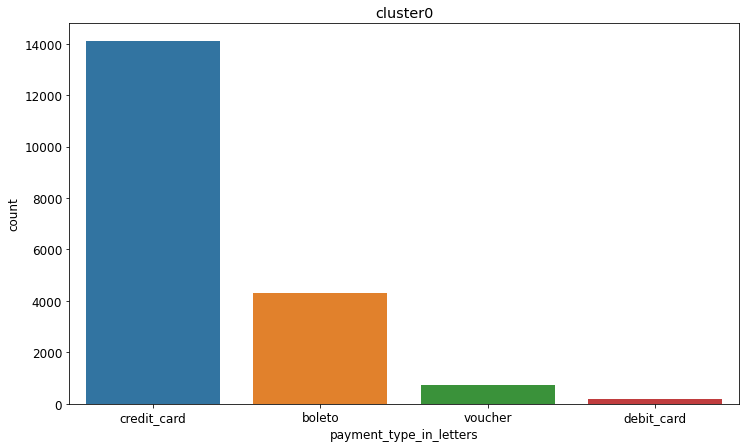

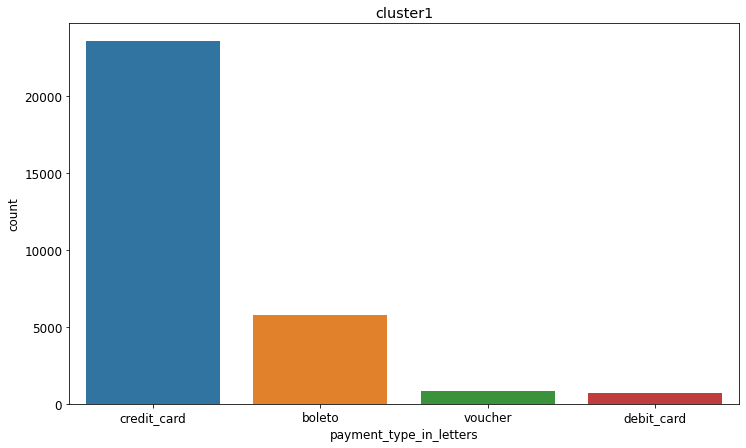

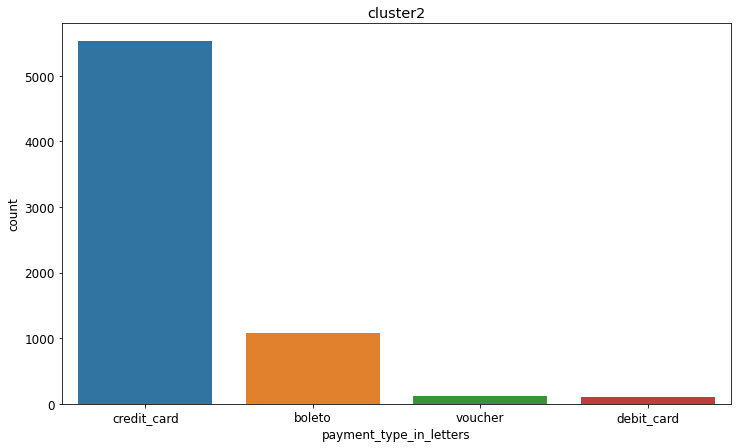

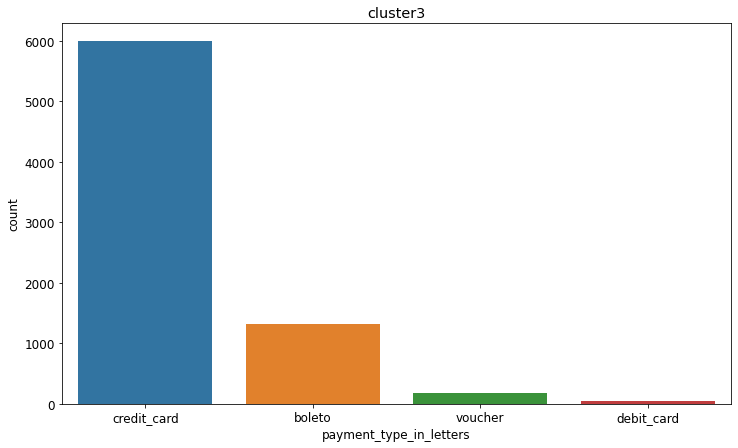

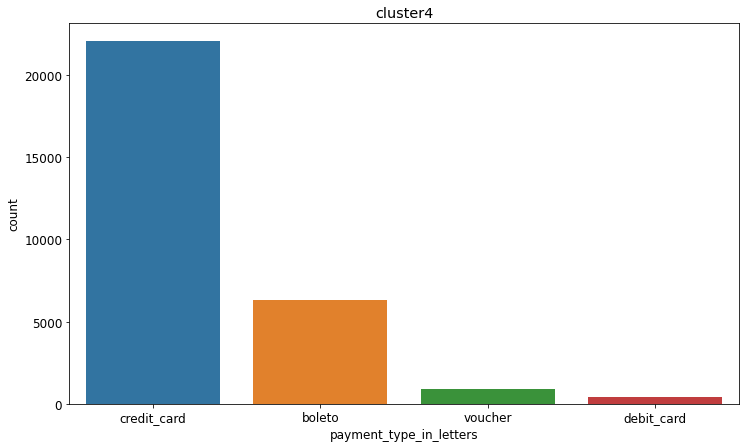

In [175]:
for i in a['cluster2'].unique():
    df_sub = a[a['cluster2']==i]
    plt.figure()
    sns.barplot(x='payment_type_in_letters', y='count', data=df_sub)
    plt.title('cluster'+str(i))

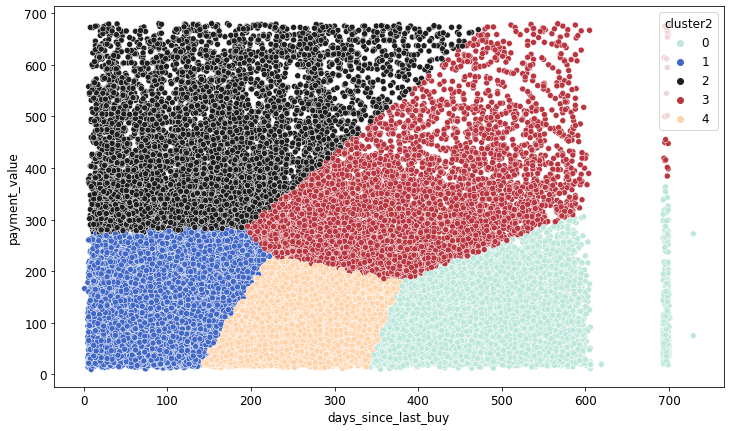

In [176]:
sns.scatterplot(x='days_since_last_buy', y='payment_value', hue='cluster2', data=df_cus, palette='icefire');

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>